<a href="https://colab.research.google.com/github/mahaley22/Uncertainty-Scoring/blob/master/Machine_Translation_with_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####   **Using Uncertainty Scoring for a Seq2seq MT model**  
2020 Mike Haley.




(Adapted from: <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    Neural machine translation with attention</a>)

This notebook trains a sequence to sequence (seq2seq) model for machine translation, using Attention. However, instead of looking at the Attention plots, we will be looking at a whole lot of Uncertainty plots and aggregating by uncertainty to reveal some directions for analyzing avoidable bias, variance, and sampling for Active Learning.  

This work was inspired in part by *Human-in-the-Loop Machine Learning* by Robert Munro © 2020  The reader of this notebook can skip down to the sections where the bulk of my work begins [Translate (with Uncertainty!)](#Translate).

In [3]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?   Attribution: tatoeba.org #2245231 (CK) & #6077611 (fekundulo)
```


To import the training and validation data, (which we want to have even if we've already saved off a model), you'll have to run something like the following two cells.   If you want to just go with the spanish language as was originally used in the original notebook (referenced at the top of this notebook) there may be no need to download the file into a google drive folder somewhere.  I've had trouble doing so outside of the original notebook, but leave the option in the code below.  I happened change the original source input language from Spanish to Hebrew as a first go, but you might want to replace that below.


In [4]:
source_lang='heb'

In [5]:
if source_lang!='spa':
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFwyhw_lM9fn_lWrjyJ-hEE1H_6_w-xCdkigfVmwWa5MQ5Rhy0pb78
Mounted at /content/drive


In [6]:
# Download the file
def get_path_to_file(lang='spa'):
  if lang=='spa':  
    path_to_zip = tf.compat.v2.keras.utils.get_file(
      'spa-eng.zip', origin='https://drive.google.com/file/d/1X5vqyh0bVii_VLcC9uEY7JzruFlMnBCS/view?usp=sharing',
      extract=True)
    path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
    return path_to_file
  else: #your own google drive
    import zipfile
    my_colab_folder = "/content/drive/My Drive/Colab Notebooks"
    with zipfile.ZipFile(my_colab_folder + "/"+source_lang+"-eng.zip", 'r') as zip_ref:
      zip_ref.extractall(my_colab_folder)
    path_to_file = my_colab_folder+"/"+source_lang+".txt"
    return path_to_file

In [7]:
path_to_file = get_path_to_file(source_lang)
path_to_file

'/content/drive/My Drive/Colab Notebooks/heb.txt'

In [8]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w, lang):
  w = w.lower().strip() 
  if source_lang=="spa":
    unicode_to_ascii(w)

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",") - this is source langauge-specific! hence the conditional placeholder
  if source_lang=="spa": 
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [9]:
english_sentence = u"We ate.	"
source_sentence = u"אכלנו."
print(preprocess_sentence(english_sentence, source_lang))
source_sentence = preprocess_sentence(source_sentence, source_lang)
if source_lang=="spa": #use for other languages as well
  source_sentence.encode('utf-8')
print(source_sentence)

<start> we ate . <end>
<start> אכלנו . <end>


In [10]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SOURCE]
def create_dataset(path, num_examples):
  lines = io.open(path).read().strip().split('\n')#io.open(path, encoding='UTF-8').read().strip().split('\n')
  print(len(lines))
  print(lines[-30000])
  word_pairs = [[preprocess_sentence(w, source_lang) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  #print(word_pairs[-1])

  return zip(*word_pairs)

In [11]:
english, source = create_dataset(path_to_file, 30000)
print(english[0])
print(source[0])

126429
Are you going to the theater tonight?	האם אתה הולך לתיאטרון הערב?	CC-BY 2.0 (France) Attribution: tatoeba.org #243411 (CK) & #2151700 (MrShoval)
<start> hi . <end>
<start> היי . <end>


In [12]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [13]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  #print(inp_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [14]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_inp)

126429
Are you going to the theater tonight?	האם אתה הולך לתיאטרון הערב?	CC-BY 2.0 (France) Attribution: tatoeba.org #243411 (CK) & #2151700 (MrShoval)
11


In [15]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [16]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [17]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
394 ----> יורד
35 ----> עכשיו
215 ----> גשם
7 ----> ?
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
7 ----> is
9 ----> it
635 ----> raining
48 ----> now
6 ----> ?
2 ----> <end>


### Create a tf.data dataset

In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
#print(example_target_batch[0:])

(TensorShape([64, 11]), TensorShape([64, 10]))

In [20]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [21]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1) 

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    #concat = concatenator([a, s_prev])
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))
    #print(query_with_time_axis.shape) (64, 1, 1024)
    #print(values.shape) (64, 11, 1024)
    #print(score.shape) (64, 11, 1)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    #print(attention_weights.shape) (64, 11, 1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    #print(context_vector.shape) (64, 11, 1024)
    context_vector = tf.reduce_sum(context_vector, axis=1)
    #print(context_vector.shape) (64, 1024)

    return context_vector, attention_weights

In [23]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


In [24]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5303)


## Define the optimizer and the loss function

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [27]:
checkpoint_dir = './drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

<a id="Training"></a>
## Training

Details of training for this interested from original attention notebook:
1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [28]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [55]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3112
Epoch 1 Batch 100 Loss 0.2525
Epoch 1 Batch 200 Loss 0.2043
Epoch 1 Batch 300 Loss 0.2753
Epoch 1 Loss 0.2578
Time taken for 1 epoch 42.12251925468445 sec

Epoch 2 Batch 0 Loss 0.1828
Epoch 2 Batch 100 Loss 0.1317
Epoch 2 Batch 200 Loss 0.1234
Epoch 2 Batch 300 Loss 0.1352
Epoch 2 Loss 0.1367
Time taken for 1 epoch 32.27008390426636 sec

Epoch 3 Batch 0 Loss 0.0979
Epoch 3 Batch 100 Loss 0.0808
Epoch 3 Batch 200 Loss 0.1320
Epoch 3 Batch 300 Loss 0.0836
Epoch 3 Loss 0.0876
Time taken for 1 epoch 31.32612633705139 sec

Epoch 4 Batch 0 Loss 0.0920
Epoch 4 Batch 100 Loss 0.0683
Epoch 4 Batch 200 Loss 0.0559
Epoch 4 Batch 300 Loss 0.0841
Epoch 4 Loss 0.0698
Time taken for 1 epoch 32.656630992889404 sec

Epoch 5 Batch 0 Loss 0.0337
Epoch 5 Batch 100 Loss 0.0677
Epoch 5 Batch 200 Loss 0.0564
Epoch 5 Batch 300 Loss 0.0353
Epoch 5 Loss 0.0594
Time taken for 1 epoch 31.62119460105896 sec

Epoch 6 Batch 0 Loss 0.0526
Epoch 6 Batch 100 Loss 0.0698
Epoch 6 Batch 200 Los

In [ ]:
# since this is a custom training loop, cannot use below.  
# (cf. Chapter 6 Deep Learning With Python (2nd edition))
#loss_and_metrics = decoder.evaluate(input_tensor_val, target_tensor_val, batch_size=128)


<a id=’Translate’></a>
##Translate (with Uncertainty!)

Here's where the fun begins.  Instead of keeping the attention weights around in order to plot them, we're going to use the final layer outputs in the following way:
* softmax normalization to yield a "probabilistic" uncertainty score.
* For every timestamp, we also remember the "runner-up" token.  This proves useful as some translations a high "runner-up" score can show us an alternate (acceptable) translation for that token, and also why there may be uncertainty
* We store scores for most confidence, Margin of Confidence between the first and second "score", and a combination (multiplicaton) of the two as our third plot.
* Later on, we will take an average across the entire sequence as an aggregate measure of sequence confidence.



In [29]:
def get_uncertainty_metrics_competing(uncertainty_scores, t, raw_scores):  
    softmax_scores = tf.nn.softmax(raw_scores)
    sorted_softmax_scores = tf.sort(softmax_scores, direction='DESCENDING')
    predicted_probability_score = sorted_softmax_scores[0].numpy()
    
    # 1. Least Confidence 
    #   here I did not bother to add the * (num_labels/(numlabels-1) as numlabels is equal to (large) vocab size)
    least_confidence = (1 - predicted_probability_score) 
    uncertainty_scores[t,0] = least_confidence

    # 2. Margin of Confidence
    margin = sorted_softmax_scores[0].numpy() - sorted_softmax_scores[1].numpy()   
    margin_of_confidence_score = (1-margin)
    uncertainty_scores[t,1] = margin_of_confidence_score

    # 3 Combined 
    combined_uncertainty_score = (1 - predicted_probability_score*margin)
    uncertainty_scores[t,2] = combined_uncertainty_score

    #print("For token: '" + predicted_word + "', probability score is: " + str(predicted_probability_score) +
    #      ", and Uncertainty Score: " + uncertainty_score + ", and Combined Uncertainty Score: " + str(combined_uncertainty_score)) 
    return uncertainty_scores 

In [30]:
def get_uncertainty_metrics_ranked(uncertainty_scores, t, raw_scores): 
  ranking = tf.argsort(raw_scores, direction='DESCENDING')
  uncertainty_scores = get_uncertainty_metrics_competing(uncertainty_scores, t, raw_scores)  
  uncertainty_scores[t,3] = ranking[0] #just add the raw score to indicate the level of information
  uncertainty_scores[t,4] = uncertainty_scores[t,2]*uncertainty_scores[t,3]
  return ranking, uncertainty_scores

For those interested or as a reference, here are some details from the original attention nb:
* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*. - NOT USED HERE
* Store the runner-up and uncertainty scores

Note: The encoder output is calculated only once for one input.

In [31]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence, source_lang)
  uncertainty_scores = np.zeros((max_length_targ, 5)) 

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  runner_up_result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on - NOT USED HERE
    #attention_weights = tf.reshape(attention_weights, (-1, ))
    #attention_plot[t] = attention_weights.numpy()

    ranking, uncertainty_scores = get_uncertainty_metrics_ranked(uncertainty_scores, t, predictions[0])

    #ranking = tf.argsort(softmax_output, direction='DESCENDING') #TODO doing an argsort twice, once here and once in get_uncertainty_metrics
    predicted_id = ranking[0].numpy() #equivalent to tf.argmax(softmax_output).numpy()
    runner_up_id = ranking[1].numpy()
    predicted_word = targ_lang.index_word[predicted_id]
    runner_up_word = targ_lang.index_word[runner_up_id] 

    result += predicted_word + ' '
    runner_up_result += runner_up_word + ' '

    if predicted_word == '<end>':
      return result, runner_up_result, sentence, uncertainty_scores

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, runner_up_result, sentence, uncertainty_scores

In [32]:
#Below thresholds are arbitrary and are really for bar chart colors only.  We'll get to optimization later!
high_confidence_threshold = 0.67
medium_confidence_threshold = 0.33

In [65]:
def label_bar(ax, plots):  
  for bar in plots:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, '{:.2g}'.format(yval), va='bottom') #va: vertical alignment y positional argument

# function for plotting the certainty scores
def plot_uncertainty(scores, titles, predicted_sentence):
  tokens = tuple(predicted_sentence)
  x = np.arange(len(tokens))
  plt.rcParams["figure.figsize"] = [8*1.618,2.5]
  fig, ax = plt.subplots(1, len(scores[1])) #don't include raw score for now
  plt.ylabel = "Uncertainty" #TODO don't know why this doesn't show up in left Y margin
  
  for p in range(len(scores[1])-2): #don't include raw score for now
    y = scores[:, p]

    mask_red = y > high_confidence_threshold
    mask_yellow = np.logical_and(y >= medium_confidence_threshold, y < high_confidence_threshold)
    mask_green = y < medium_confidence_threshold

    ax[p].set_ylim([0, 1])
    red_plots = ax[p].bar(x[mask_red], y[mask_red], color = 'red')
    label_bar(ax[p], red_plots)
    yellow_plots = ax[p].bar(x[mask_yellow], y[mask_yellow], color = 'yellow')
    label_bar(ax[p], yellow_plots)
    green_plots = ax[p].bar(x[mask_green], y[mask_green], color = 'green')
    label_bar(ax[p], green_plots)

    ax[p].set_xticks(x) 
    ax[p].set_xticklabels(predicted_sentence, rotation=90)   #plt.xticks(x, tokens) 
    ax[p].set_title(titles[p])
  
  for p in range(len(scores[1])-2, len(scores[1])): 
    raw = scores[:, p]
    plots = ax[p].bar(x, raw)
    label_bar(ax[p], plots)
    ax[p].set_xticks(x) 
    ax[p].set_xticklabels(predicted_sentence, rotation=90)   #plt.xticks(x, tokens) 
    ax[p].yaxis.set_label_position("right")
    ax[p].yaxis.tick_right()
    ax[p].set_title(titles[p])

  #plt.title('Output: {}'.format(predicted_sentence))
  plt.show()

In [40]:
def translate(sentence, verbose=True):
  result, runner_up, sentence, scores = evaluate(sentence)
  tokenized_result = [t for t in result.split(' ') if t] 
  if verbose:
    print('\nInput: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print('Runner-up translation: {}'.format(runner_up))
    titles = ['Least Conf', 'Margin of Conf', 'Combined Conf', "Raw Logits", "Combined Logits"]
    uncertainty_plot = scores[:len(tokenized_result)]
    plot_uncertainty(uncertainty_plot, titles, tokenized_result)
  else: 
    return scores, tokenized_result

## Restore the latest checkpoint and run a few sample translations
Bear in mind your model depends on the train/val distribution, so results may vary (feel free to input anything here and see what happens!).  Bear in mind that every source has one possible target (we don't have alternate reference translations).  Note in some cases that the **runner-up translation** token can explain some of the uncertainty in some cases.

In [35]:

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Target: Can I use this bike?

Input: <start> מותר לי להשתמש באופניים ? <end>
Predicted translation: may i use this bike ? <end> 
Runner-up translation: can i've album today ? . ? 


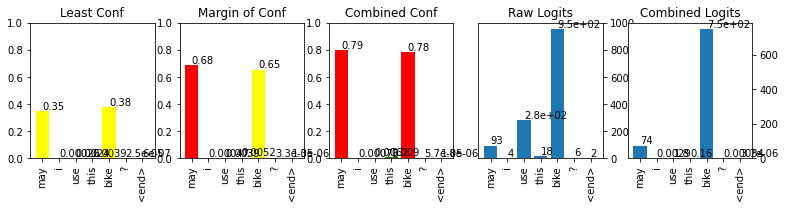

In [66]:
# here we see the 'may' vs. 'can' uncertainty, depending on the training 
print("Target: Can I use this bike?") 
translate(u'מותר לי להשתמש באופניים?')

Target: Is anything wrong?

Input: <start> משהו לא בסדר ? <end>
Predicted translation: is something wrong ? <end> 
Runner-up translation: isn't not okay ok ? 


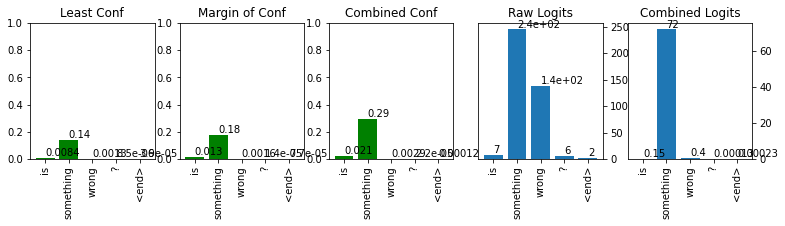

In [67]:
#"Anything" vs. "something" vs. "anyone" uncertainty 
print("Target: Is anything wrong?")
translate(u'משהו לא בסדר?')

Target: Is this our flight?

Input: <start> זאת הטיסה שלנו ? <end>
Predicted translation: is this our flight ? <end> 
Runner-up translation: how's it your our flight ? 


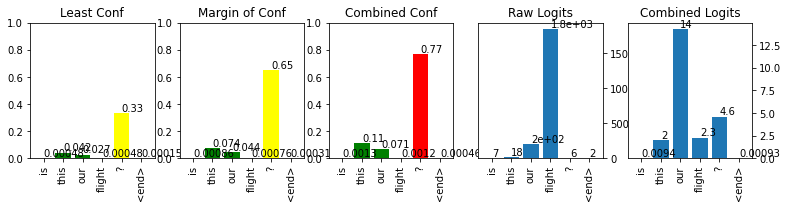

In [68]:
 # note the "this" versus "that" uncertainty.  In my run it got "Is this our book" but "book" has very high uncertainty
 print("Target: Is this our flight?")
 translate(u'זאת הטיסה שלנו?')

Target: Stop grumbling.

Input: <start> תפסיק להתלונן . <end>
Predicted translation: quit complaining . <end> 
Runner-up translation: stop grumbling up . 


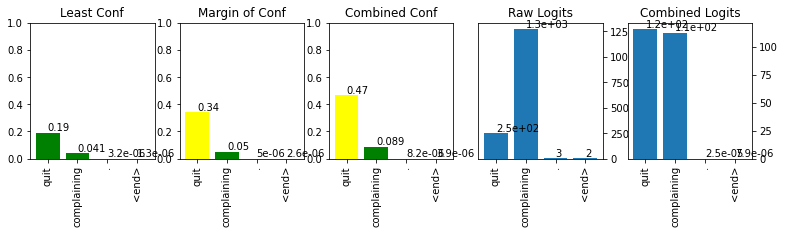

In [69]:
# "grumbling" vs. "complaining" uncertainty sometimes, "quit" vs. "stop" sometimes
print("Target: Stop grumbling.")
translate(u'תפסיק להתלונן.')



Target: Do you see it?

Input: <start> אתה רואה את זה ? <end>
Predicted translation: do you see it ? <end> 
Runner-up translation: can you're do this one ? 


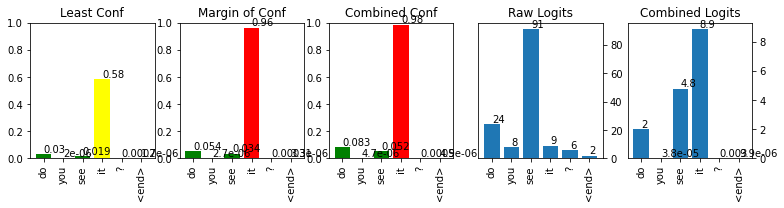

In [70]:
#"it" versus "that", or "do" vs. <empty>
print("Target: Do you see it?")
translate(u'אתה רואה את זה?')

Target: My cat loves toys.

Input: <start> החתול שלי אוהב צעצועים <end>
Predicted translation: my cat loves toys . <end> 
Runner-up translation: the coach love ! ! . 


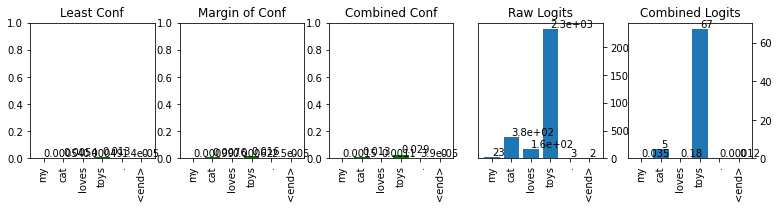

In [71]:
print("Target: My cat loves toys.")
translate(u'החתול שלי אוהב צעצועים')

In [133]:
#print("Target: If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.")
#translate(u'אם מישהו שאינו מכיר את הרקע שלכם אומר שאתם נשמעים כמו דוברים ילידים , פירוש הדבר שהוא מן הסתם הבחין במשהו בדיבורכם שגרם לו להבין שאינכם דוברים ילידים . במילים אחרות , אתם לא באמת נשמעים כמו דוברים ילידים .')


##Towards Uncertainty (and Certainty) Sampling
Now that we've seen some interesting values for individual translation tokens, we're ready to approach some uncertainty sampling using an aggregation across the entire sequence.

Let's just start with the admittedly arbitrary guess-timated thresholds below
and equally sized subsets of both our training and validation sets for testing against these thresholds.  We do want to choose these thresholds in a more sophisticated way, but for now it will do for exploration.

In [50]:
total_test_size=1000
uncertainty_sampling_treshold = 0.2
certainty_sampling_treshold = 0.02

In [51]:
#Some table-setting functions we'll need:

def convert_to_sentence(lang, tensor):
  sentence = "";
  for t in tensor:
    if t not in [0, 1, 2]:
      sentence = sentence + ' ' + lang.index_word[t]
  return sentence

def translate_sentences(inp_lang, targ_lang, input_tensor, target_tensor, range, verbose=True):
  scores = []
  results = []
  for s in range:
    input_sentence = convert_to_sentence(inp_lang, input_tensor[s])
    target_sentence = convert_to_sentence(targ_lang, target_tensor[s])
    if verbose:
      print("\n\nSentence: " + input_sentence)
      print("Target: " + target_sentence)
    score, result = translate(input_sentence, verbose)
    scores.append(score)
    results.append(result)
  return np.array(scores), np.array(results)



In [52]:
def get_high_uncertainty_sample_size(sequence_mean, threshold = uncertainty_sampling_treshold):
  mask_uncertainty = sequence_mean > threshold
  uncertainty_sample = sequence_mean[mask_uncertainty]
  uncertainty_sample_size = len(uncertainty_sample)
  print("Uncertainty set size: " + str(uncertainty_sample_size) + " out of " + str(len(sequence_mean)))
  return uncertainty_sample_size

def get_low_uncertainty_sample_size(sequence_mean, threshold = certainty_sampling_treshold):
  mask_uncertainty = sequence_mean <= threshold
  certainty_sample = sequence_mean[mask_uncertainty]
  certainty_sample_size = len(certainty_sample)
  print("Certainty subset size: " + str(certainty_sample_size) + " out of " + str(len(sequence_mean)))
  return certainty_sample_size

Depending on the size of the test (above) the two cells below  may take a minute or two each for 1000 translations on a GPU.   

In [57]:
train_score_plots, training_results = translate_sentences(inp_lang, targ_lang, input_tensor_train, target_tensor_train, range(total_test_size), verbose=False)
#print(train_score_plots.shape) (1000, 10, 4)
train_set_mean = tf.math.reduce_mean(train_score_plots[:,:,0:3], axis=[0,1])
print("Training set uncertainty means: " + str(train_set_mean.numpy()))
training_sequences_means = tf.math.reduce_mean(train_score_plots[:,:,2], axis=1).numpy() #sequence mean as our sample aggregation function TODO consider using minimum
training_high_uncertainty_sample_size = get_high_uncertainty_sample_size(training_sequences_means)
training_low_uncertainty_sample_size = get_low_uncertainty_sample_size(training_sequences_means)

Training set uncertainty means: [0.01499686 0.02466971 0.03296367]
Uncertainty set size: 7 out of 1000
Certainty subset size: 572 out of 1000


In [59]:
val_score_plots, val_results = translate_sentences(inp_lang, targ_lang, input_tensor_val, target_tensor_val, range(total_test_size), verbose=False)
val_set_mean = tf.math.reduce_mean(val_score_plots[:,:,0:3], axis=[0,1])
print("Validation set uncertainty means: " + str(val_set_mean.numpy()))
val_sequences_means = tf.math.reduce_mean(val_score_plots[:,:,2], axis=1).numpy() #sequence mean as our sample aggregation function
val_high_uncertainty_sample_size = get_high_uncertainty_sample_size(val_sequences_means)
val_low_uncertainty_sample_size = get_low_uncertainty_sample_size(val_sequences_means)


Validation set uncertainty means: [0.05201507 0.07672008 0.09437553]
Uncertainty set size: 96 out of 1000
Certainty subset size: 209 out of 1000


Not surprisingly:
* the overall uncertainty means across all three measures are higher for the validation set
* the "certain" cohort is larger for the training set versus the validation set.

A little more suprisingly:
* while the above remains true, for the same thresholds, different "slices" of 1000 out of our total training and validation sets can yield different total #'s and 'uncertain' vs. 'certain' cohorts.  We'll explore that below.

### Exploring Underfitting and (Un)certainty
So to look for avoidable bias (underfitting), now let's take a look at which of our confident mis-matches (at least according to our crude 1-1 matching algorithm with no alternate reference translations considered):

In [60]:

def get_ranked_uncertainty(sequences_means, size, target_tensor=None, input_tensor=None, 
                           direction='DESCENDING', display=True, ranking=None, results=None,  targ_lang=targ_lang):
  matches = []
  non_matches = []
  if ranking is None:
    ranking = tf.argsort(sequences_means, direction=direction)
  for u in range(size):
    #print(ranking[u]) 
    target = convert_to_sentence(targ_lang, target_tensor[ranking[u]])
    #print("\n\nTarget: " + target)
    if display:
      print("\n\nTarget: " + target)
      print("Aggregate Sequence Uncertainty: " + str(sequences_means[ranking[u]]))
      translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]))
    else:
      tokenized_result = results[ranking[u]] #_, tokenized_result = translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]), verbose=False)
      if "<end>" in tokenized_result:
        tokenized_result.remove('<end>')
      if ' '.join(tokenized_result).strip() == target.strip():
        matches.append(ranking[u])
      else:
        #print(' '.join(tokenized_result).strip()) #- if you want to display the non-match inline
        #print(target.strip())
        non_matches.append(ranking[u])
  return np.array(matches), np.array(non_matches)


In [61]:
training_matches, training_non_matches = get_ranked_uncertainty(training_sequences_means, training_low_uncertainty_sample_size, target_tensor_train,
                                              direction='ASCENDING', display=False, results=training_results)
#print(training_matches[-1])
print("Training set confident matches: " + str(len(training_matches)))
print("Training set confident non-Matches: " + str(len(training_non_matches)))
print("Matching: {:.1%}".format((len(training_matches)/(len(training_matches)+len(training_non_matches)))))

Training set confident matches: 561
Training set confident non-Matches: 11
Matching: 98.1%


Yay!  A high percentage of matches (accuracy) in the large highly confident set is what we like to see.  Let's look at the non-matches:



Target:  i need advice .
Aggregate Sequence Uncertainty: 0.0012813925743103028

Input: <start> אני זקוקה לעצה . <end>
Predicted translation: i need some advice . <end> 
Runner-up translation: i've like advice . again . 


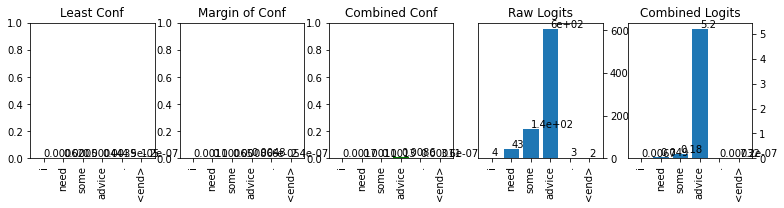



Target:  you're harsh .
Aggregate Sequence Uncertainty: 0.0012939870357513428

Input: <start> את קשוחה . <end>
Predicted translation: you're tough . <end> 
Runner-up translation: you harsh ! . 


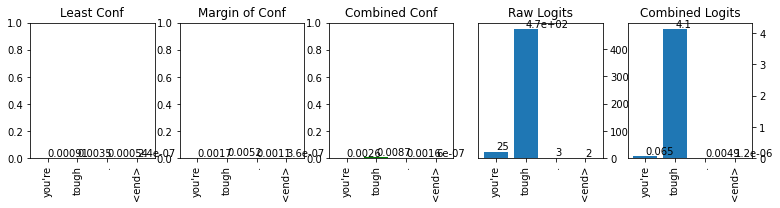



Target:  he cannot swim .
Aggregate Sequence Uncertainty: 0.001873701810836792

Input: <start> הוא לא יודע לשחות . <end>
Predicted translation: he can't swim . <end> 
Runner-up translation: he's cannot tell well . 


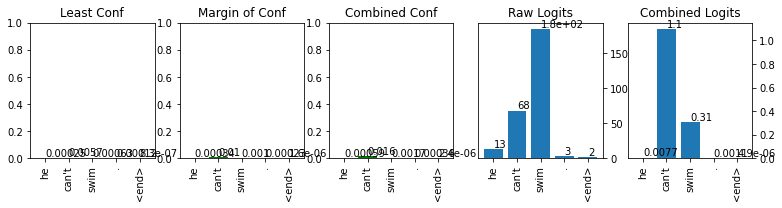



Target:  tom is clueless .
Aggregate Sequence Uncertainty: 0.00556570291519165

Input: <start> טום חסר אונים . <end>
Predicted translation: tom is powerless . <end> 
Runner-up translation: tom's has helpless of . 


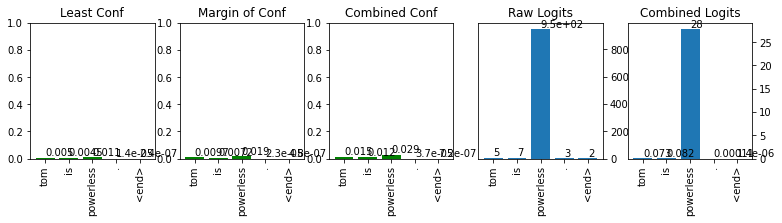



Target:  i saw an airplane .
Aggregate Sequence Uncertainty: 0.005762821435928345

Input: <start> ראיתי אווירון . <end>
Predicted translation: i saw a plane . <end> 
Runner-up translation: i've kept an cake asleep . 


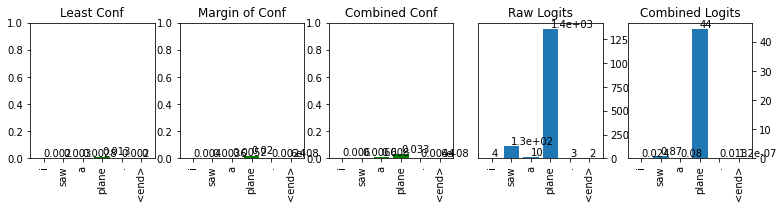



Target:  why would i care ?
Aggregate Sequence Uncertainty: 0.006001359224319458

Input: <start> למה שיהיה לי אכפת ? <end>
Predicted translation: why should i care ? <end> 
Runner-up translation: what i we like care ? 


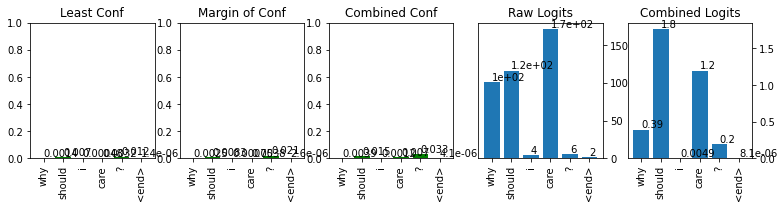



Target:  are you trustworthy ?
Aggregate Sequence Uncertainty: 0.010475212335586548

Input: <start> אפשר לסמוך עליך ? <end>
Predicted translation: are you dependable ? <end> 
Runner-up translation: can we certain . ? 


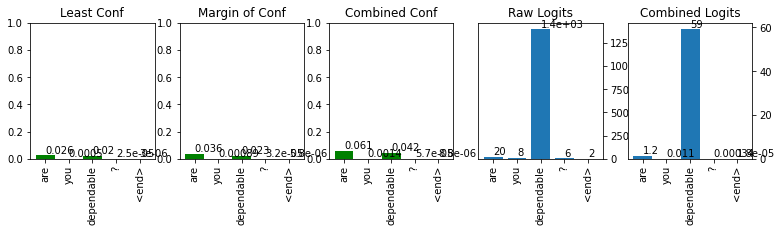



Target:  tom left me .
Aggregate Sequence Uncertainty: 0.013827103376388549

Input: <start> תום עזב אותי . <end>
Predicted translation: tom has left me . <end> 
Runner-up translation: everyone left me left out me 


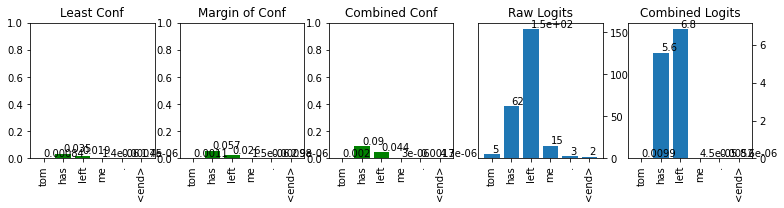



Target:  i assume so .
Aggregate Sequence Uncertainty: 0.015359050035476685

Input: <start> כך אני מניח . <end>
Predicted translation: i suppose so . <end> 
Runner-up translation: that's assume i tells you 


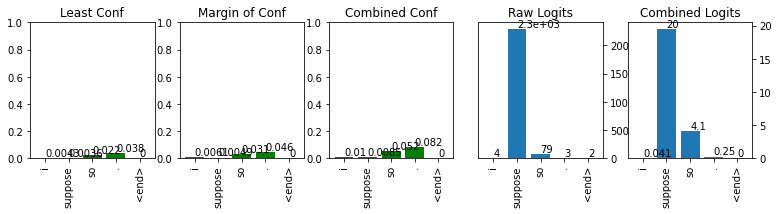



Target:  you were correct .
Aggregate Sequence Uncertainty: 0.016908103227615358

Input: <start> צדקת . <end>
Predicted translation: you were right . <end> 
Runner-up translation: you're tried correct out . 


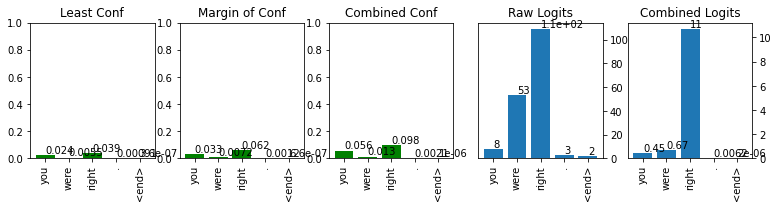



Target:  everybody's tired .
Aggregate Sequence Uncertainty: 0.017495083808898925

Input: <start> כל אחד עייף . <end>
Predicted translation: everyone is tired . <end> 
Runner-up translation: happy isn't happy ! . 


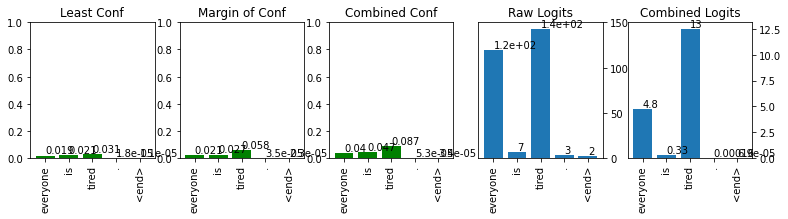

(array([], dtype=float64), array([], dtype=float64))

In [72]:
get_ranked_uncertainty(training_sequences_means, len(training_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_non_matches, results=training_results)

OK!  Some of these departures from the strict ground truth would probably qualify as alternate reference translations, or even better translations.  (There also seems to be an issue where the model doesn't "know" that it has an issue with tense, so there's an area to target for underfitting.) 

Overall, for our set of sentences with a high "certainty" threshold of 0.02, the size can range widely from 28% to just over 63% of the training set!.  But no matter its size (keep in mind this is so far a fairly arbitrary threshold) we are pretty close to fully fitting for this high confidence level.  

Before we get too full of ourselves and forget what we're really after in an Active Learning cycle, let's look at the least confident ones, and along the way try to find some examples of underfitting:




In [74]:
training_unsure_matches, training_unsure_non_matches = get_ranked_uncertainty(training_sequences_means, training_high_uncertainty_sample_size, target_tensor_train,
                                              display=False, results=training_results)
print("Training set highly non-confident matches: " + str(len(training_unsure_matches)))
print("Training set highly non-confident non-Matches: " + str(len(training_unsure_non_matches)))

Training set highly non-confident matches: 0
Training set highly non-confident non-Matches: 7




Target:  i sleep pretty well .
Aggregate Sequence Uncertainty: 0.4118628318421543

Input: <start> אני ישן די טוב . <end>
Predicted translation: i'm kind of good . <end> 
Runner-up translation: i sleep pretty lot day . 


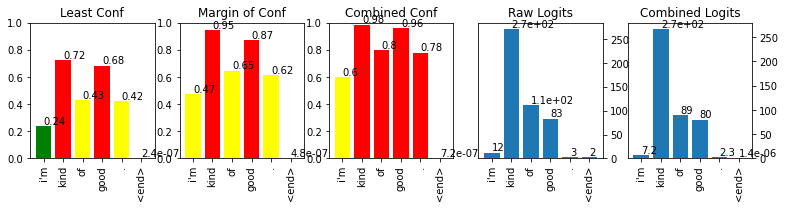



Target:  let's let tom speak .
Aggregate Sequence Uncertainty: 0.33489710013382135

Input: <start> בוא ניתן לתום לדבר . <end>
Predicted translation: tom can speak to speak . <end> 
Runner-up translation: let's loved eat talking talk in tom 


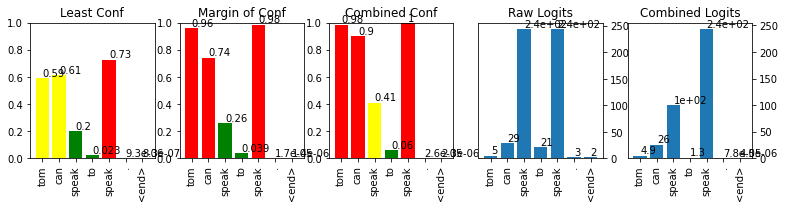



Target:  i am to blame .
Aggregate Sequence Uncertainty: 0.29528659097850324

Input: <start> אני אשמה בזה . <end>
Predicted translation: i'm guilty to blame . <end> 
Runner-up translation: i watching that it ? that 


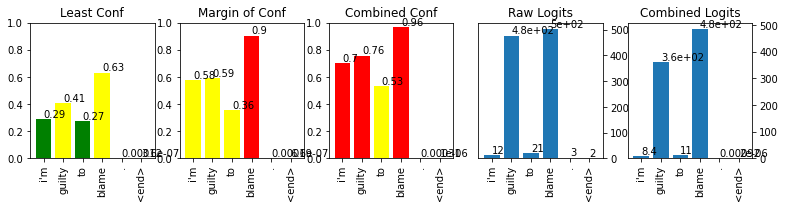



Target:  tom can do it all .
Aggregate Sequence Uncertainty: 0.2470932114869356

Input: <start> תום יכול לעשות את כל זה . <end>
Predicted translation: tom can do it all , too . <end> 
Runner-up translation: he can't be it's out . please all it 


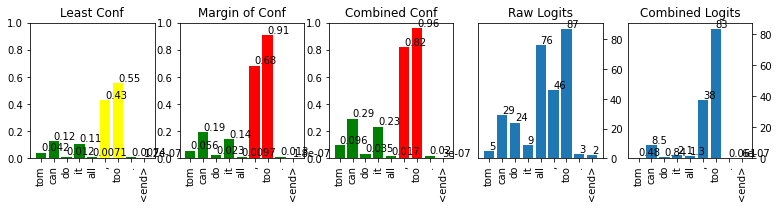



Target:  i told you so .
Aggregate Sequence Uncertainty: 0.2236082971096039

Input: <start> הזהרתי אותך . <end>
Predicted translation: i told you know you . <end> 
Runner-up translation: i've warned you're mind . ! you 


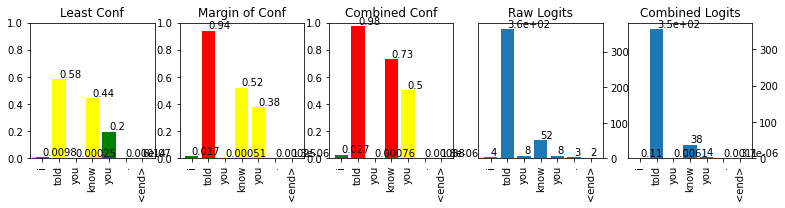



Target:  this is how it is .
Aggregate Sequence Uncertainty: 0.217018823325634

Input: <start> ככה זה . <end>
Predicted translation: that's how it is . <end> 
Runner-up translation: this so of . it . 


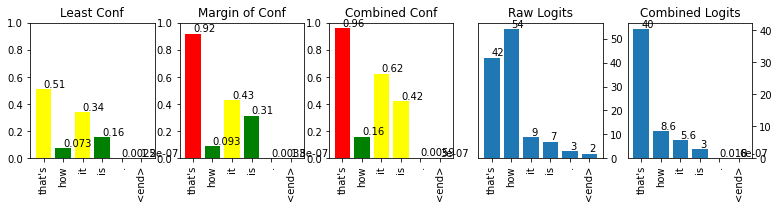



Target:  where is your cap ?
Aggregate Sequence Uncertainty: 0.21565011329948902

Input: <start> איפה הכובע שלך ? <end>
Predicted translation: where's the cap ? <end> 
Runner-up translation: where your hat is ? 


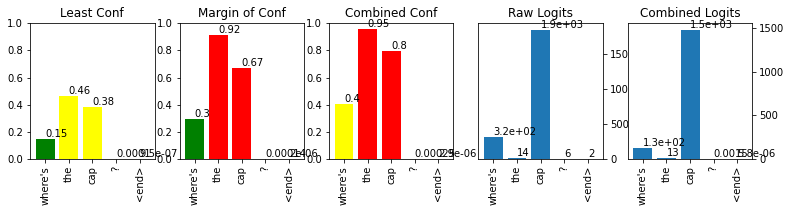

(array([], dtype=float64), array([], dtype=float64))

In [75]:
get_ranked_uncertainty(training_sequences_means, len(training_unsure_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_unsure_non_matches, results=training_results)

Alright, a few issues here among the low certainty cohort.  Not all of these are bad translations in one set I ran "He's not home" becomes "He isn't at home", or "Let me out!" becomes "I want to leave!" 

Its interesting to note sometimes which individual words/tokens will have high uncertainty, often indicating where the translation went awry.  This could be of help for humans in the loop correcting these translations, for example.  

But let's be hard on ourselves and assume they're all one way or another examples of underfitting - at least finding them by means of low aggregate uncertainty ranking.  Now we'd have to candidates for an Active Learning cycle.  Also, playing with the thresholds (and ultimately, optimizing them) would be the next thing to try in future cycles.  But let's move on to the validation set.

### Exploring Variance and (Un)certainty


Previously we saw that the validation results had fewer high confidence examples.  Let's start by looking at those:


In [76]:
val_conf_matches, val_conf_non_matches = get_ranked_uncertainty(val_sequences_means, val_low_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set confident matches: " + str(len(val_conf_matches)))
print("Validation set confident non-matches: " + str(len(val_conf_non_matches)))
print("Matching: {:.1%}".format((len(val_conf_matches)/(len(val_conf_matches)+len(val_conf_non_matches)))))

Validation set confident matches: 146
Validation set confident non-matches: 63
Matching: 69.9%


Usually we have fewer overall high-certainty results from the validation set compared with the training set (using the same threshold as training). (However, some n-1000 test batches I've run happen to match or even exceed the training set!) 

It's also not surprising that we have a higher number of confident non-Matches.  As we did before, let's check out those high certainty non-matches:



Target:  he gave in .
Aggregate Sequence Uncertainty: 7.365942001342773e-05

Input: <start> הוא נכנע . <end>
Predicted translation: he surrendered . <end> 
Runner-up translation: everybody gave in . 


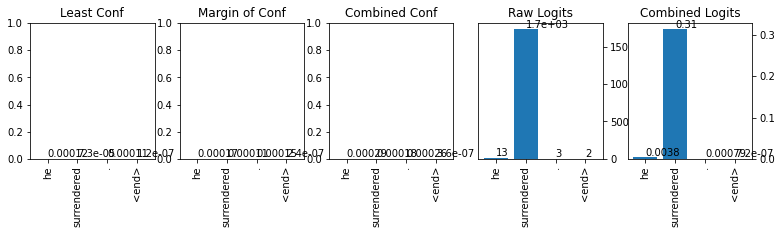



Target:  i'm taking off now .
Aggregate Sequence Uncertainty: 0.0007881343364715577

Input: <start> אני יוצא עכשיו . <end>
Predicted translation: i'm leaving now . <end> 
Runner-up translation: leave going to ! . 


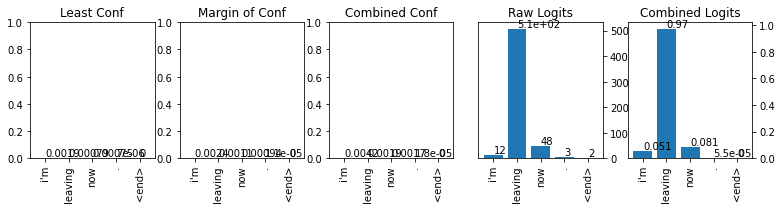



Target:  he is lying .
Aggregate Sequence Uncertainty: 0.0010245084762573243

Input: <start> הוא משקר . <end>
Predicted translation: he's lying . <end> 
Runner-up translation: how a lying . 


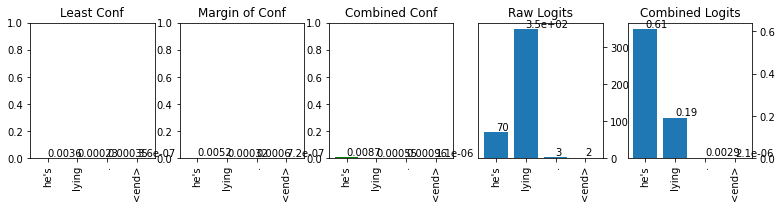



Target:  i'm feeling hungry .
Aggregate Sequence Uncertainty: 0.0011825740337371826

Input: <start> אני חש רעב . <end>
Predicted translation: i feel hungry . <end> 
Runner-up translation: i'm felt shocked ! . 


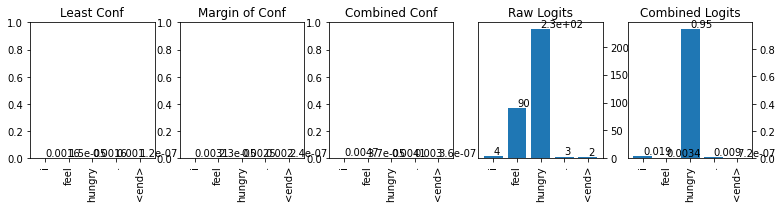



Target:  i trust you .
Aggregate Sequence Uncertainty: 0.001427936553955078

Input: <start> אני סומכת עליך . <end>
Predicted translation: i'm counting on you . <end> 
Runner-up translation: i in in you're in you 


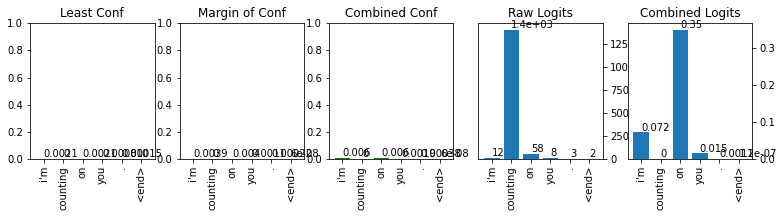



Target:  i'm so sorry .
Aggregate Sequence Uncertainty: 0.0017369568347930908

Input: <start> אני מאד מצטער . <end>
Predicted translation: i'm very sorry . <end> 
Runner-up translation: i so answer ! . 


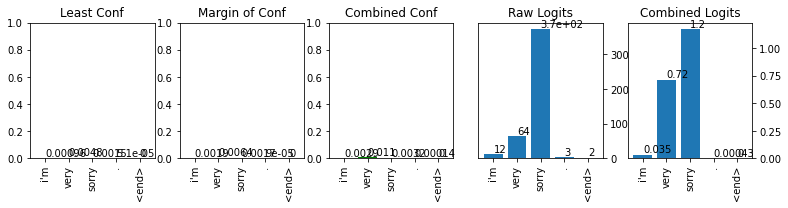



Target:  we trusted you .
Aggregate Sequence Uncertainty: 0.001938384771347046

Input: <start> האמנו לכם . <end>
Predicted translation: we believed you . <end> 
Runner-up translation: they all for ! you 


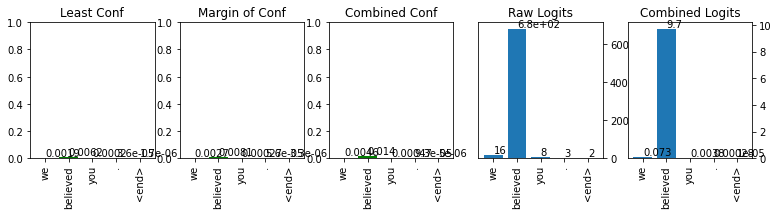



Target:  he closed the door .
Aggregate Sequence Uncertainty: 0.002068054676055908

Input: <start> הוא סגר את הדלת . <end>
Predicted translation: he shut the door . <end> 
Runner-up translation: he's away it room the you 


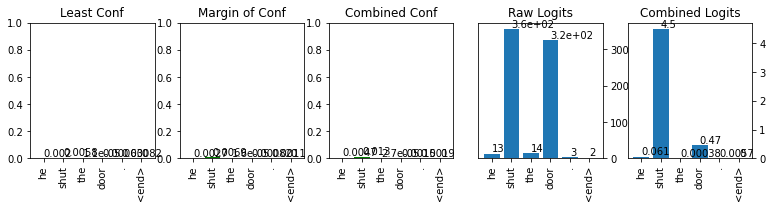



Target:  they hurried off .
Aggregate Sequence Uncertainty: 0.0021899044513702393

Input: <start> הם מיהרו הלאה . <end>
Predicted translation: they hurried on . <end> 
Runner-up translation: they'll window off here . 


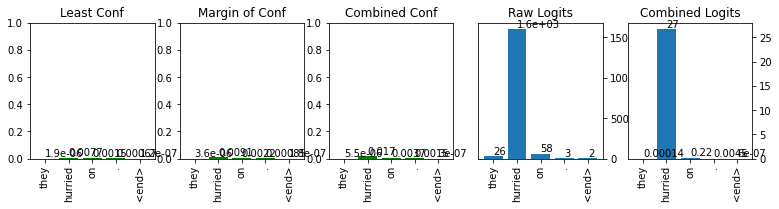



Target:  tom can swim well .
Aggregate Sequence Uncertainty: 0.0026843249797821045

Input: <start> תום שוחה היטב . <end>
Predicted translation: tom swims well . <end> 
Runner-up translation: tom's wanted strong well . 


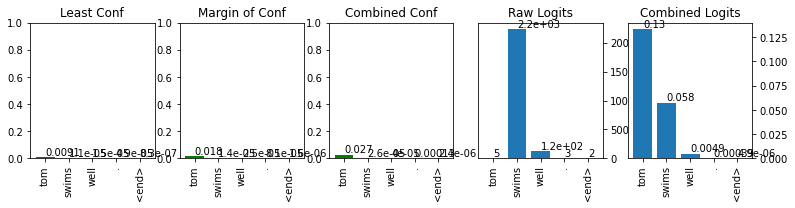



Target:  you're diligent .
Aggregate Sequence Uncertainty: 0.002795034646987915

Input: <start> אתם חרוצים . <end>
Predicted translation: you're hardworking . <end> 
Runner-up translation: you diligent ! . 


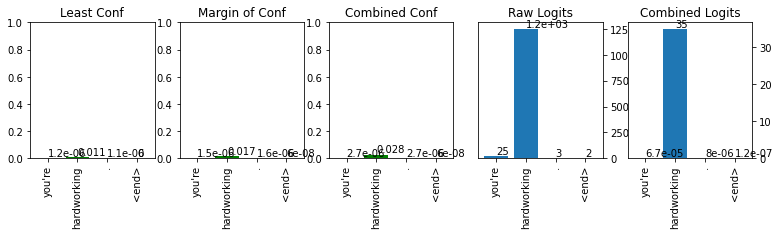



Target:  she worships him .
Aggregate Sequence Uncertainty: 0.0031607568264007567

Input: <start> היא מעריצה אותו . <end>
Predicted translation: she adores him . <end> 
Runner-up translation: her worships it out him 


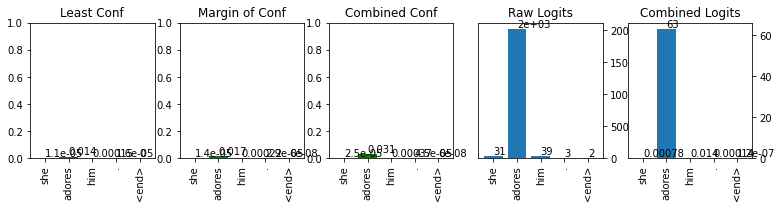



Target:  i can't quit now .
Aggregate Sequence Uncertainty: 0.0033872902393341066

Input: <start> אני לא יכול לעזוב עכשיו . <end>
Predicted translation: i can't leave now . <end> 
Runner-up translation: can't cannot find here ! you 


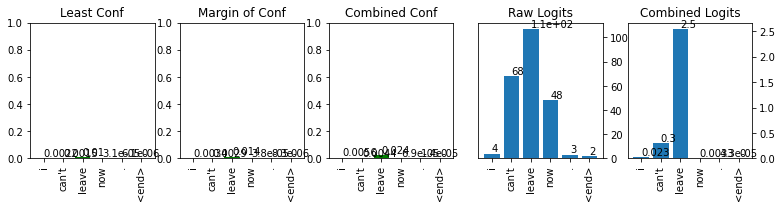



Target:  stop complaining .
Aggregate Sequence Uncertainty: 0.003395378589630127

Input: <start> תפסיקי להתלונן ! <end>
Predicted translation: quit complaining . <end> 
Runner-up translation: stop quick ! ? 


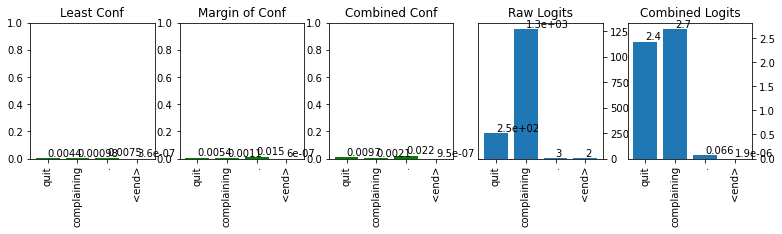



Target:  that's suicide .
Aggregate Sequence Uncertainty: 0.003416687250137329

Input: <start> זאת התאבדות . <end>
Predicted translation: it's suicide . <end> 
Runner-up translation: that's disturbing ! . 


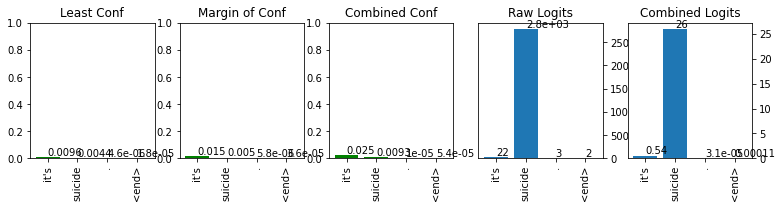



Target:  we were worried .
Aggregate Sequence Uncertainty: 0.004567807912826538

Input: <start> היינו מודאגים . <end>
Predicted translation: we were concerned . <end> 
Runner-up translation: we're talked worried ? . 


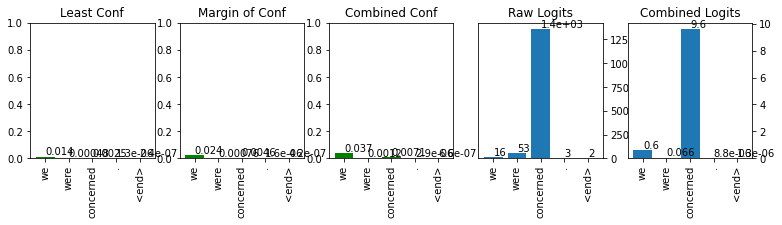



Target:  are you ignoring me ?
Aggregate Sequence Uncertainty: 0.004805797338485717

Input: <start> אתה מתעלם ממני ? <end>
Predicted translation: are you accusing me ? <end> 
Runner-up translation: do me afraid out out ? 


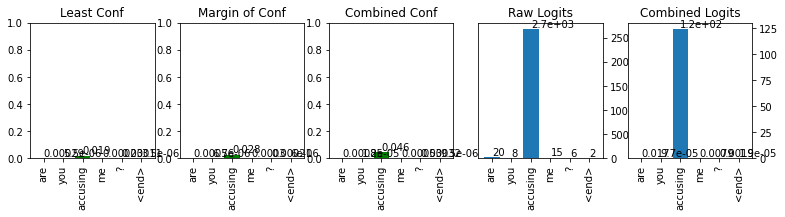



Target:  dad isn't home .
Aggregate Sequence Uncertainty: 0.004840081930160523

Input: <start> אבא לא בבית . <end>
Predicted translation: dad's not home . <end> 
Runner-up translation: my no alone ! . 


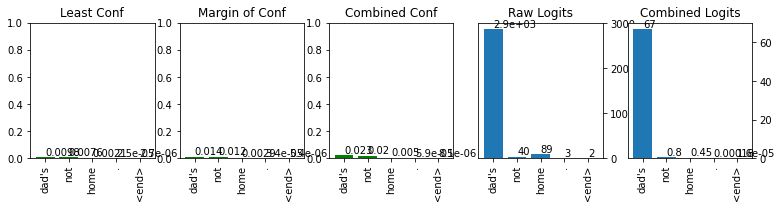



Target:  we learned french .
Aggregate Sequence Uncertainty: 0.0051432371139526365

Input: <start> למדנו צרפתית . <end>
Predicted translation: we studied french . <end> 
Runner-up translation: we've learned shooting ? . 


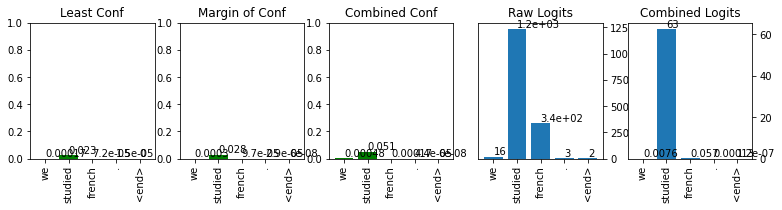



Target:  they're kids .
Aggregate Sequence Uncertainty: 0.005441933870315552

Input: <start> הם ילדים . <end>
Predicted translation: they're children . <end> 
Runner-up translation: they kids are . 


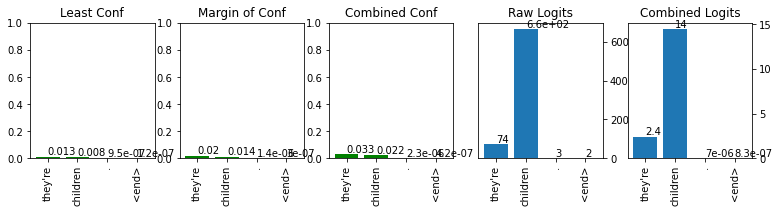



Target:  tom had a pistol .
Aggregate Sequence Uncertainty: 0.005558526515960694

Input: <start> לתום היה אקדח . <end>
Predicted translation: tom had a gun . <end> 
Runner-up translation: i was cover message on . 


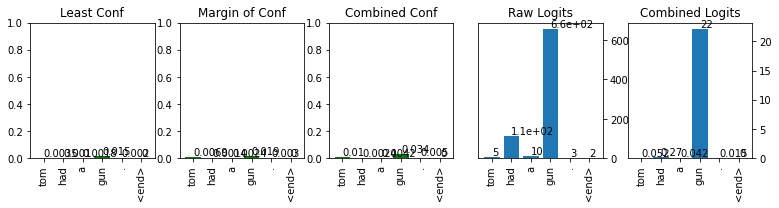



Target:  i helped .
Aggregate Sequence Uncertainty: 0.005908441543579101

Input: <start> עזרתי . <end>
Predicted translation: i helped out . <end> 
Runner-up translation: help forgot . here . 


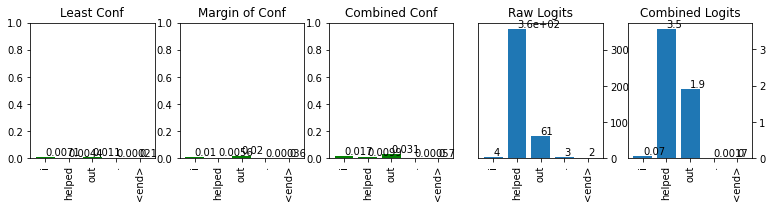



Target:  you're mean .
Aggregate Sequence Uncertainty: 0.005945026874542236

Input: <start> אתם מרושעים . <end>
Predicted translation: you're wicked . <end> 
Runner-up translation: we're mean ? . 


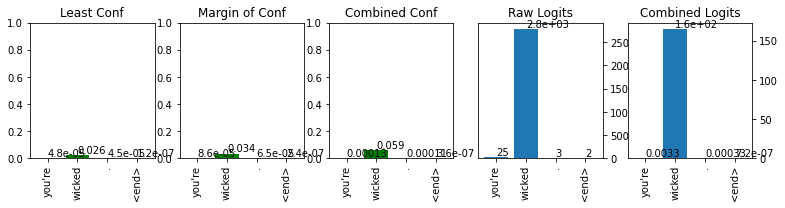



Target:  i don't doubt it .
Aggregate Sequence Uncertainty: 0.006082040071487427

Input: <start> אינני מטילה בכך ספק . <end>
Predicted translation: i don't doubt that . <end> 
Runner-up translation: i'm never buy it ? that 


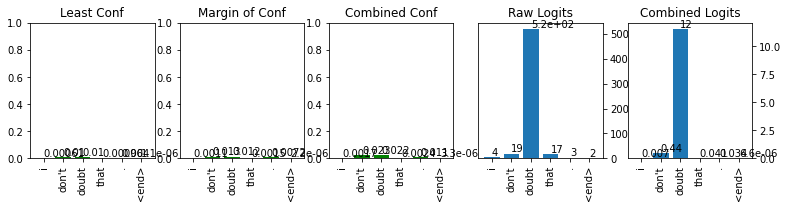



Target:  this is a picture .
Aggregate Sequence Uncertainty: 0.006175714731216431

Input: <start> זאת תמונה . <end>
Predicted translation: this is a painting . <end> 
Runner-up translation: that will the mistake that . 


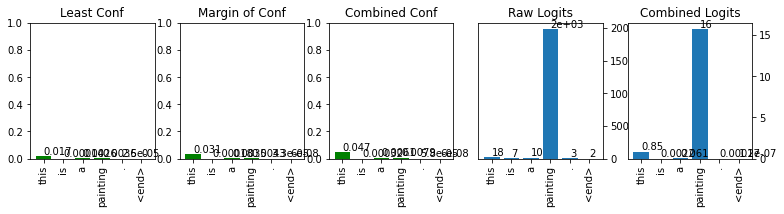



Target:  life can be rough .
Aggregate Sequence Uncertainty: 0.006334632635116577

Input: <start> החיים יכולים להיות קשים . <end>
Predicted translation: life can be hard . <end> 
Runner-up translation: maybe could work difficult hard . 


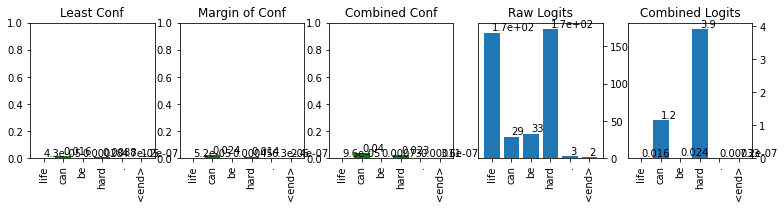



Target:  tom was nosy .
Aggregate Sequence Uncertainty: 0.006347334384918213

Input: <start> תום היה חטטן . <end>
Predicted translation: tom was nosey . <end> 
Runner-up translation: tom's came nosy up . 


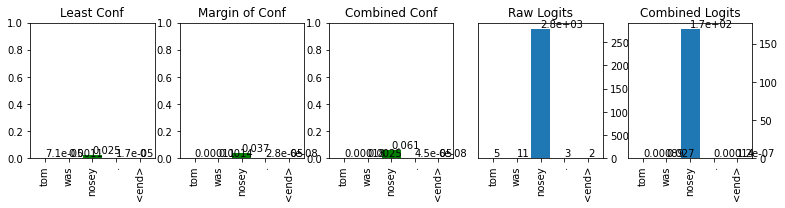



Target:  i'm curious .
Aggregate Sequence Uncertainty: 0.0064326047897338865

Input: <start> אני מסוקרן . <end>
Predicted translation: i'm intrigued . <end> 
Runner-up translation: i diplomatic ! . 


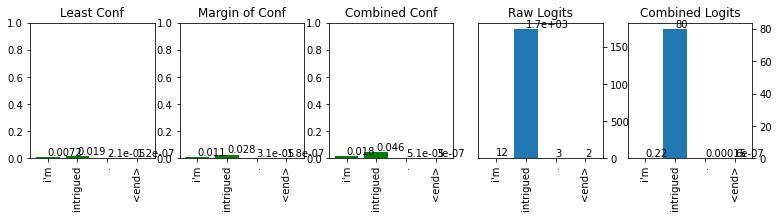



Target:  i have asked him .
Aggregate Sequence Uncertainty: 0.0064497292041778564

Input: <start> שאלתי אותו . <end>
Predicted translation: i asked after him . <end> 
Runner-up translation: i'm kept him it out him 


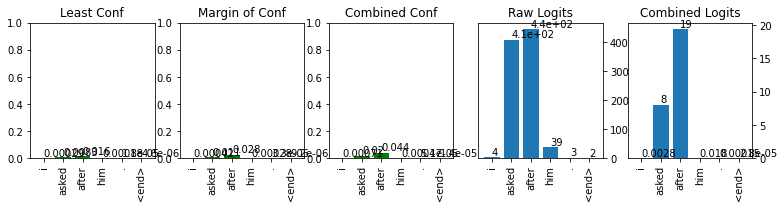



Target:  i don't doubt that .
Aggregate Sequence Uncertainty: 0.006732863187789917

Input: <start> אינני מפקפק בכך . <end>
Predicted translation: i don't doubt it . <end> 
Runner-up translation: i'm hardly care that ? that 


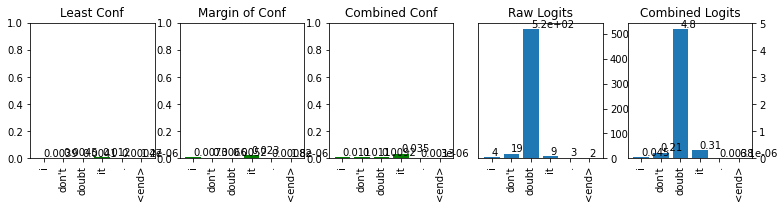



Target:  can i come in ?
Aggregate Sequence Uncertainty: 0.006870472431182861

Input: <start> אני יכולה להיכנס ? <end>
Predicted translation: may i come in ? <end> 
Runner-up translation: can me go to in ? 


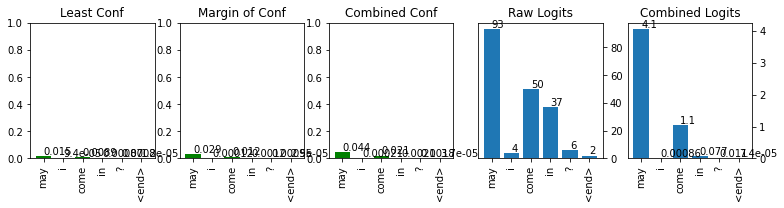



Target:  tom is arrogant .
Aggregate Sequence Uncertainty: 0.0070935249328613285

Input: <start> תום יהיר . <end>
Predicted translation: tom is vain . <end> 
Runner-up translation: tom's will magnificent ! . 


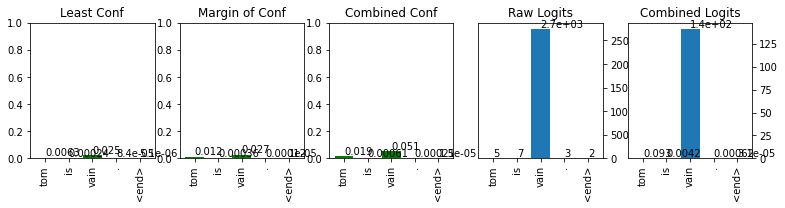



Target:  i have to study .
Aggregate Sequence Uncertainty: 0.007261413335800171

Input: <start> אני חייב ללמוד . <end>
Predicted translation: i need to study . <end> 
Runner-up translation: i've must study love music . 


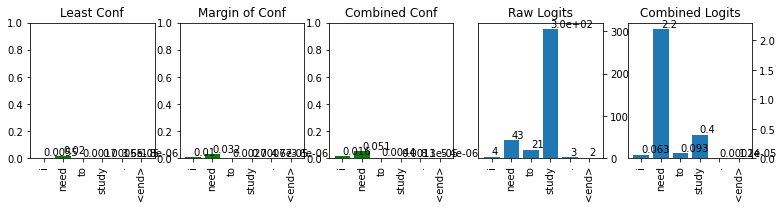



Target:  i have a proposal .
Aggregate Sequence Uncertainty: 0.007563787698745728

Input: <start> יש לי הצעה . <end>
Predicted translation: i have a suggestion . <end> 
Runner-up translation: i'm got an bit an . 


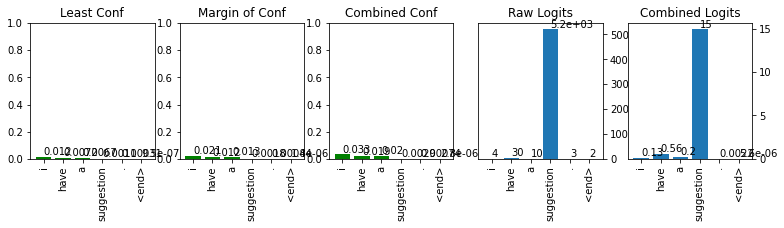



Target:  have you seen it ?
Aggregate Sequence Uncertainty: 0.007573658227920532

Input: <start> ראית את זה ? <end>
Predicted translation: did you see that ? <end> 
Runner-up translation: can i drink it one ? 


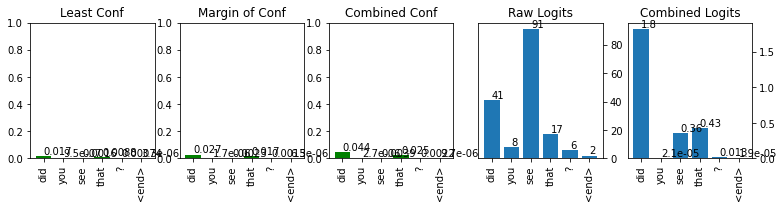



Target:  we're rich .
Aggregate Sequence Uncertainty: 0.007757747173309326

Input: <start> אנו עשירים . <end>
Predicted translation: we're wealthy . <end> 
Runner-up translation: we rich ? . 


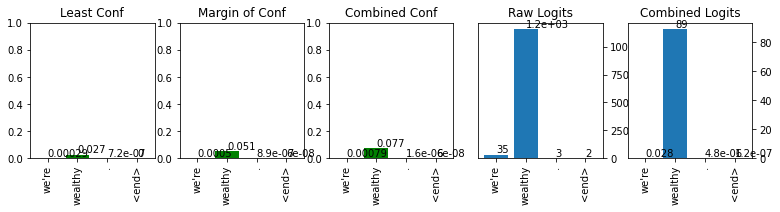



Target:  i'll quit .
Aggregate Sequence Uncertainty: 0.007927995920181275

Input: <start> אני אוותר . <end>
Predicted translation: i'll pass . <end> 
Runner-up translation: i'm fail we . 


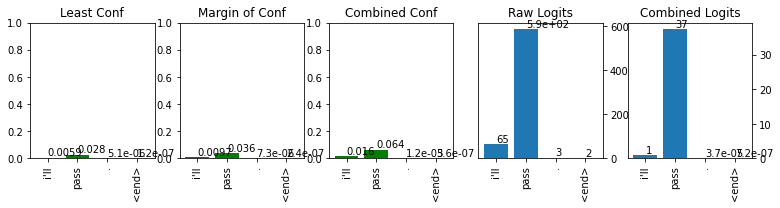



Target:  i was wrong .
Aggregate Sequence Uncertainty: 0.007953864336013795

Input: <start> טעיתי . <end>
Predicted translation: i was mistaken . <end> 
Runner-up translation: i'd didn't wrong ? ? 


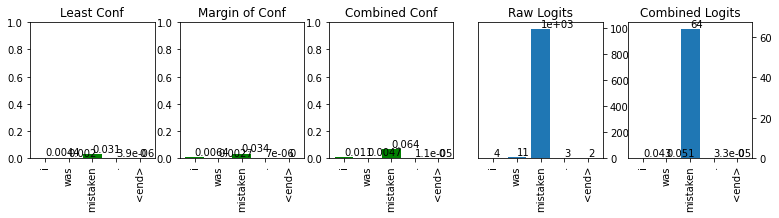



Target:  tom didn't respond .
Aggregate Sequence Uncertainty: 0.008219468593597411

Input: <start> תום לא ענה . <end>
Predicted translation: tom didn't answer . <end> 
Runner-up translation: tom's isn't respond somebody . 


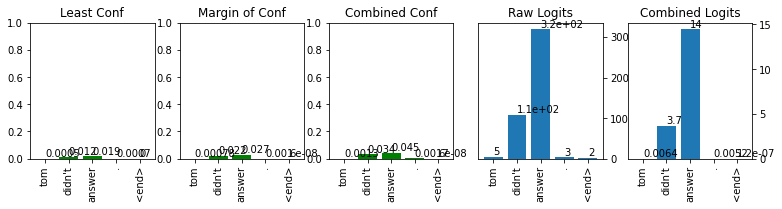



Target:  just a moment . . .
Aggregate Sequence Uncertainty: 0.008288949728012085

Input: <start> המתן שניה . <end>
Predicted translation: hang on a minute . <end> 
Runner-up translation: wait a on seat ! . 


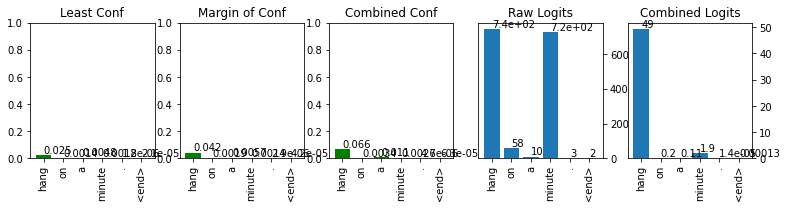



Target:  i eat here .
Aggregate Sequence Uncertainty: 0.00835220217704773

Input: <start> אני אוכלת פה . <end>
Predicted translation: i'm eating here . <end> 
Runner-up translation: i eat on again . 


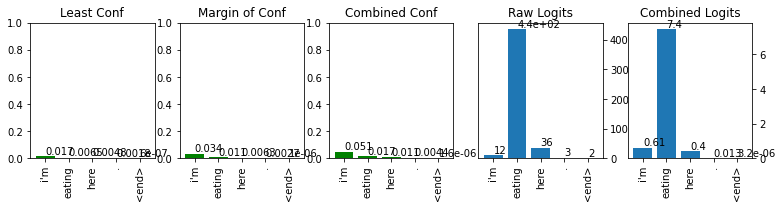



Target:  you are late .
Aggregate Sequence Uncertainty: 0.008600491285324096

Input: <start> אתה מאחר . <end>
Predicted translation: you're late . <end> 
Runner-up translation: we're bluffing ! . 


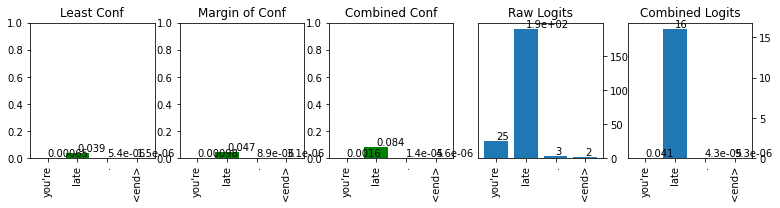



Target:  i got fired .
Aggregate Sequence Uncertainty: 0.009304946660995484

Input: <start> פיטרו אותי . <end>
Predicted translation: i was fired . <end> 
Runner-up translation: i've got shot now . 


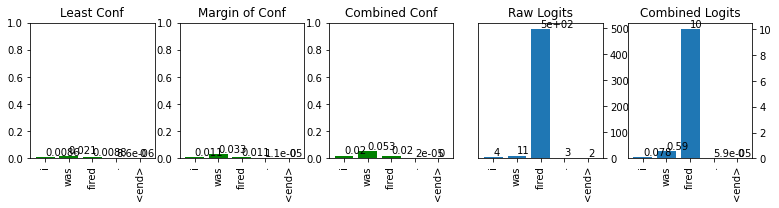



Target:  tom was cheating .
Aggregate Sequence Uncertainty: 0.009340649843215943

Input: <start> תום רימה . <end>
Predicted translation: tom cheated . <end> 
Runner-up translation: tom's was out . 




Target:  we were not afraid .
Aggregate Sequence Uncertainty: 0.009443509578704833

Input: <start> לא פחדנו . <end>
Predicted translation: we weren't scared . <end> 
Runner-up translation: we're misjudged finished we . 


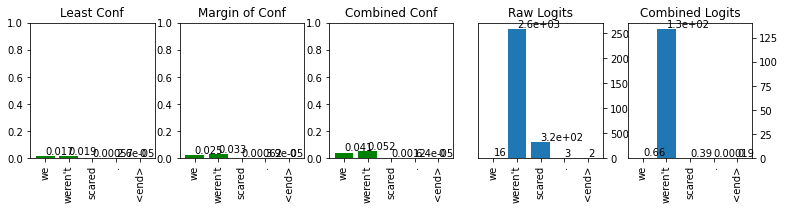



Target:  i'm slightly hungry .
Aggregate Sequence Uncertainty: 0.009447664022445679

Input: <start> אני קצת רעב . <end>
Predicted translation: i'm a bit hungry . <end> 
Runner-up translation: i somewhat little to ! . 


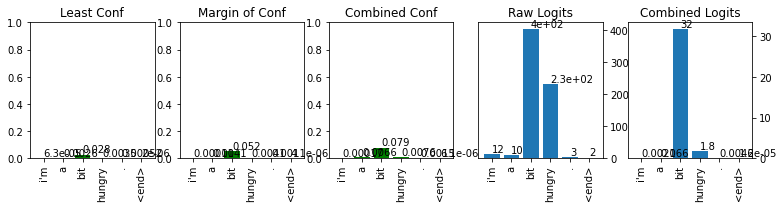



Target:  that was harsh .
Aggregate Sequence Uncertainty: 0.011083424091339111

Input: <start> זה היה אכזרי . <end>
Predicted translation: it was cruel . <end> 
Runner-up translation: that came stressful up . 


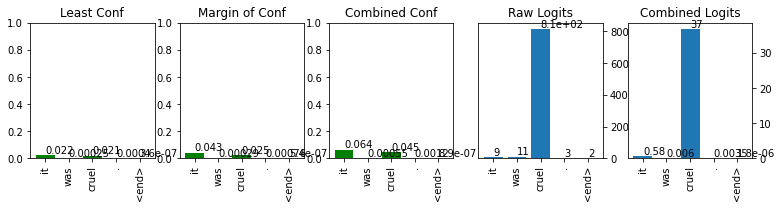



Target:  let me alone .
Aggregate Sequence Uncertainty: 0.011180365085601806

Input: <start> עזוב אותי . <end>
Predicted translation: leave me . <end> 
Runner-up translation: let leave in me 


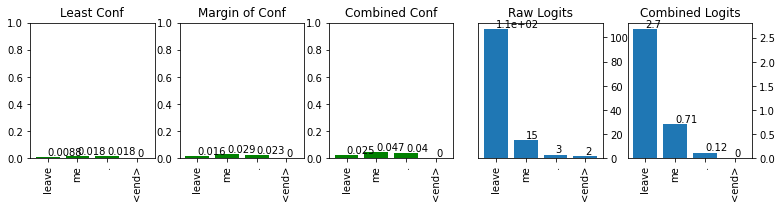



Target:  please come in .
Aggregate Sequence Uncertainty: 0.011643409729003906

Input: <start> הכנסו בבקשה פנימה . <end>
Predicted translation: please step inside . <end> 
Runner-up translation: step come in ! . 


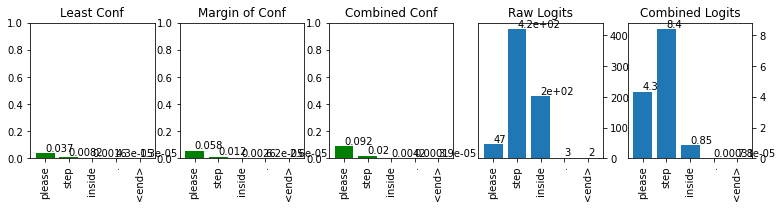



Target:  please have a seat .
Aggregate Sequence Uncertainty: 0.012052226066589355

Input: <start> שב בבקשה . <end>
Predicted translation: sit down , please . <end> 
Runner-up translation: please up . . go . 


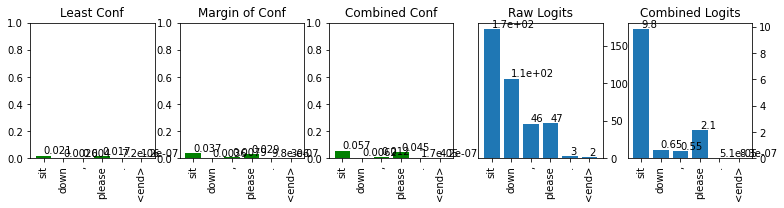



Target:  i exercise .
Aggregate Sequence Uncertainty: 0.01216515302658081

Input: <start> אני מתעמל . <end>
Predicted translation: i work out . <end> 
Runner-up translation: i'm made in myself . 




Target:  you're funny .
Aggregate Sequence Uncertainty: 0.012355649471282959

Input: <start> את משעשעת . <end>
Predicted translation: you're fun . <end> 
Runner-up translation: you funny ? . 




Target:  it may snow .
Aggregate Sequence Uncertainty: 0.012486040592193604

Input: <start> אולי ירד שלג . <end>
Predicted translation: maybe it'll snow . <end> 
Runner-up translation: it it be it . 




Target:  hi .
Aggregate Sequence Uncertainty: 0.012494939565658569

Input: <start> אהלן . <end>
Predicted translation: hello ! <end> 
Runner-up translation: shove is us 


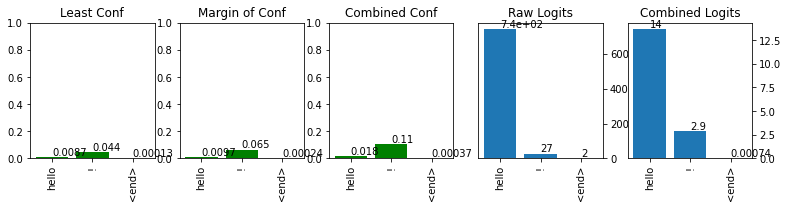



Target:  tom is quitting .
Aggregate Sequence Uncertainty: 0.012560039758682251

Input: <start> תום מתפטר . <end>
Predicted translation: tom is resigning . <end> 
Runner-up translation: tom's has quitting ? . 




Target:  we're serious .
Aggregate Sequence Uncertainty: 0.012838363647460938

Input: <start> אנו רציניים . <end>
Predicted translation: we mean business . <end> 
Runner-up translation: we're were . ? . 


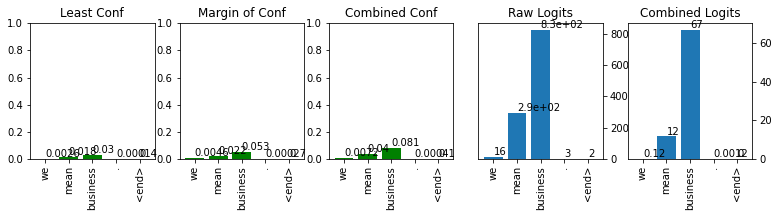



Target:  it was embarrassing .
Aggregate Sequence Uncertainty: 0.014061284065246583

Input: <start> זה היה מביש . <end>
Predicted translation: it was disgraceful . <end> 
Runner-up translation: that been frustrating up . 




Target:  you're satisfied .
Aggregate Sequence Uncertainty: 0.014553713798522949

Input: <start> אתם מרוצים . <end>
Predicted translation: we're contented . <end> 
Runner-up translation: you're talked ? . 


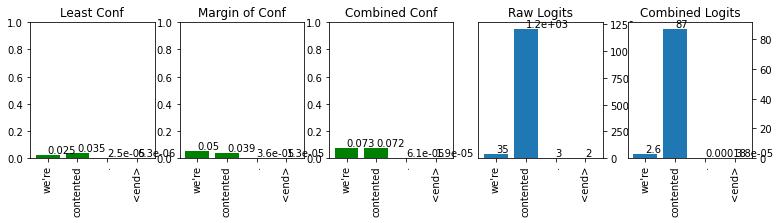



Target:  this was fun .
Aggregate Sequence Uncertainty: 0.015285056829452515

Input: <start> זה היה כיף . <end>
Predicted translation: it was fun . <end> 
Runner-up translation: that made an to . 


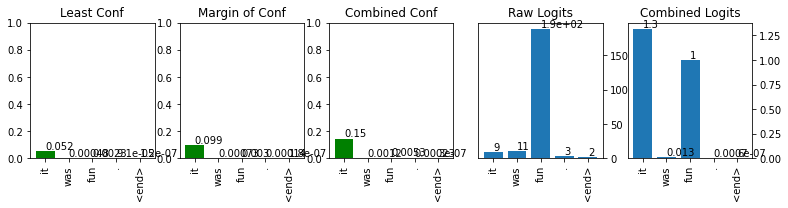



Target:  he is aggressive .
Aggregate Sequence Uncertainty: 0.015922743082046508

Input: <start> תום תוקפני . <end>
Predicted translation: tom is aggressive . <end> 
Runner-up translation: tom's sang sociable is . 




Target:  she cried .
Aggregate Sequence Uncertainty: 0.0164544939994812

Input: <start> היא בכתה . <end>
Predicted translation: she was crying . <end> 
Runner-up translation: she's is asleep ? . 


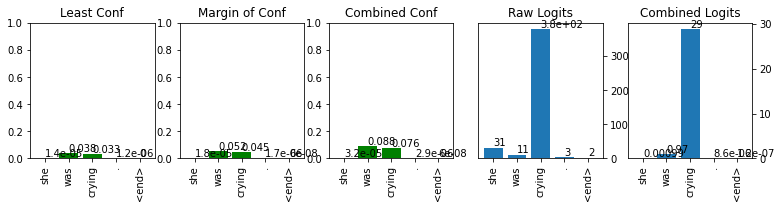



Target:  i'm not blaming you .
Aggregate Sequence Uncertainty: 0.017464929819107057

Input: <start> אינני מאשים אותך . <end>
Predicted translation: i don't blame you . <end> 
Runner-up translation: i'm hardly blaming you're ! you 


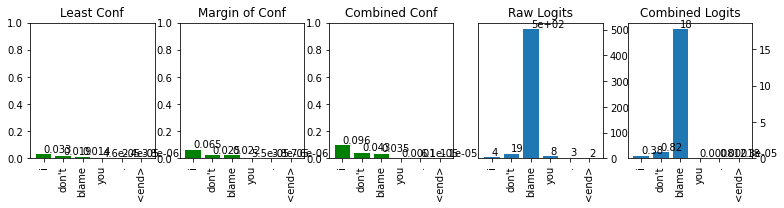



Target:  this is theirs .
Aggregate Sequence Uncertainty: 0.017982995510101317

Input: <start> זה שלהם . <end>
Predicted translation: that's theirs . <end> 
Runner-up translation: it's obvious of . 


(array([], dtype=float64), array([], dtype=float64))

In [77]:
get_ranked_uncertainty(val_sequences_means, len(val_conf_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_conf_non_matches, results=val_results)

The majority of these are decent alternate translations, and again uncovers issues where MT result is better than the "ground truth" e.g. in my set the translation "i'm here" is better than "I'm in here". So, it's kind of cool to see it generalizing in a correct way. We'll explore this more below. 

Let's look at the much larger least confident cohort:

In [78]:
val_unsure_matches, val_unsure_non_matches = get_ranked_uncertainty(val_sequences_means, val_high_uncertainty_sample_size, target_tensor_val,
                                              display=False, results=val_results)
print("Validation set highly non-confident matches: " + str(len(val_unsure_matches)))
print("Validation set highly non-confident non-Matches: " + str(len(val_unsure_non_matches)))
print("Matching: {:.1%}".format(len(val_unsure_matches)/(len(val_unsure_matches)+len(val_unsure_non_matches))))

Validation set highly non-confident matches: 13
Validation set highly non-confident non-Matches: 83
Matching: 13.5%




Target:  read this now .
Aggregate Sequence Uncertainty: 0.4327251685783267

Input: <start> קראו את זה עכשיו . <end>
Predicted translation: when it now it now . <end> 
Runner-up translation: bring do right that . ? that 


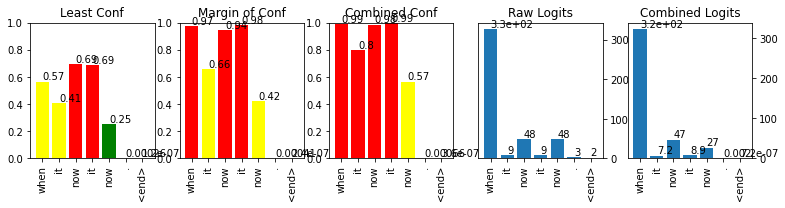



Target:  my phone died .
Aggregate Sequence Uncertainty: 0.37362364218570293

Input: <start> הטלפון שלי הפסיק לפעול . <end>
Predicted translation: the sun to love . <end> 
Runner-up translation: my phone like work rich . 




Target:  i like wild flowers .
Aggregate Sequence Uncertainty: 0.3629726618528366

Input: <start> אני אוהב פרחי בר . <end>
Predicted translation: i like love of ok . <end> 
Runner-up translation: i'd love tom's myself the <end> . 




Target:  i caught the flu .
Aggregate Sequence Uncertainty: 0.3441784563008696

Input: <start> תפסה אותי שפעת . <end>
Predicted translation: i let you go . <end> 
Runner-up translation: now sent me changed in you 


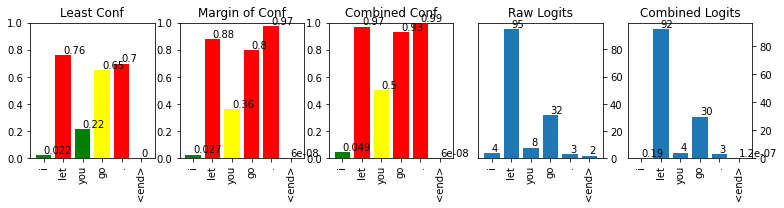



Target:  that's how it was .
Aggregate Sequence Uncertainty: 0.3408499345183372

Input: <start> הנה כך זה היה . <end>
Predicted translation: there it was it was . <end> 
Runner-up translation: here was wasn't that . that it 


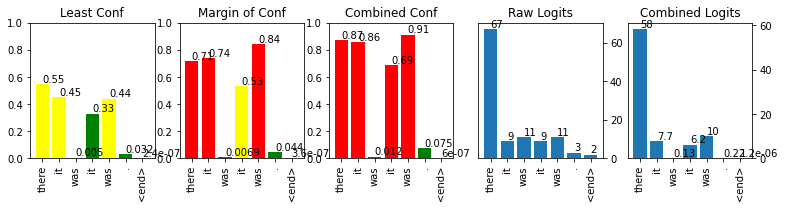



Target:  i got paid today .
Aggregate Sequence Uncertainty: 0.3346091156825423

Input: <start> שילמו לי היום . <end>
Predicted translation: the soldier is today . <end> 
Runner-up translation: i answer hurts boring today today 


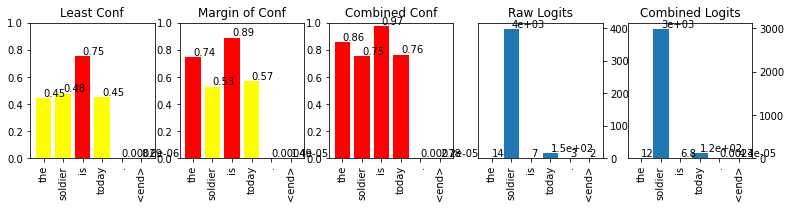



Target:  i'm afraid not .
Aggregate Sequence Uncertainty: 0.33280215319246054

Input: <start> חוששני שלא . <end>
Predicted translation: i'm sorry not . <end> 
Runner-up translation: i homesick . amused . 


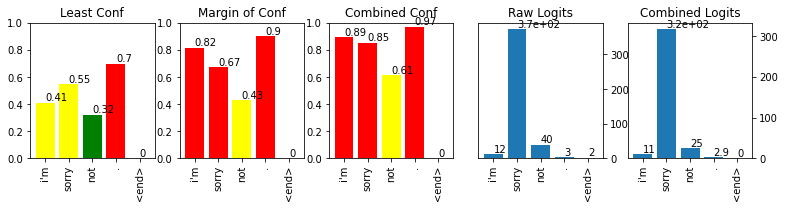



Target:  today is my treat .
Aggregate Sequence Uncertainty: 0.33244844879955054

Input: <start> היום אני מזמין . <end>
Predicted translation: it's not my treat . <end> 
Runner-up translation: i'm my the place now . 


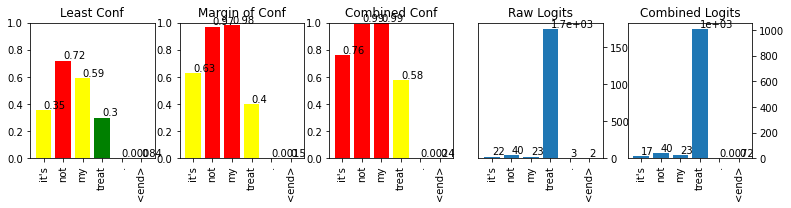



Target:  tom is going .
Aggregate Sequence Uncertainty: 0.3302962325513363

Input: <start> תום הולך . <end>
Predicted translation: tom is going to go . <end> 
Runner-up translation: tom's will walking . leave ! . 


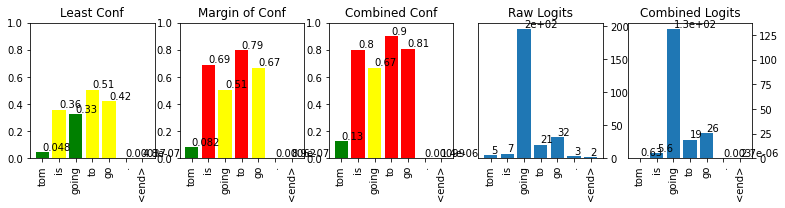



Target:  there is no doubt .
Aggregate Sequence Uncertainty: 0.3291417796164751

Input: <start> אין ספק . <end>
Predicted translation: that does no music . <end> 
Runner-up translation: we're has that way ? . 


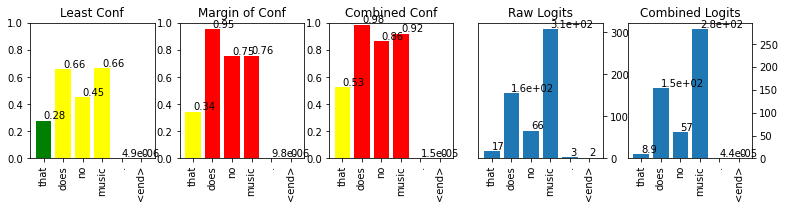



Target:  tom made partner .
Aggregate Sequence Uncertainty: 0.32475554198026657

Input: <start> תום השיג עמדת שותף . <end>
Predicted translation: tom came to hold , please . <end> 
Runner-up translation: tom's bought soundly wait bum sight sight . 


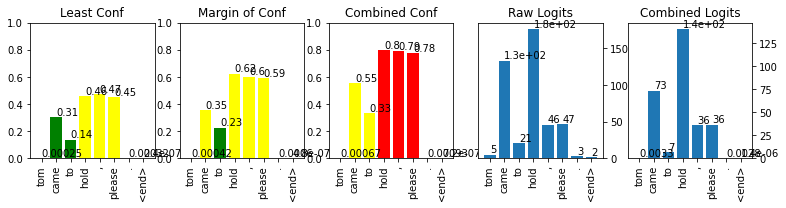



Target:  i was partly right .
Aggregate Sequence Uncertainty: 0.3246976599097252

Input: <start> צדקתי חלקית . <end>
Predicted translation: the be right back . <end> 
Runner-up translation: i pain careful down ? . 


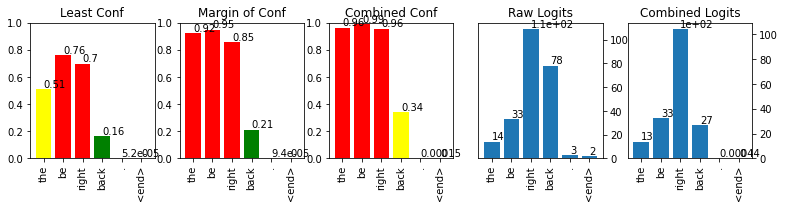



Target:  let it dry .
Aggregate Sequence Uncertainty: 0.3186707335524261

Input: <start> תן לזה להתייבש . <end>
Predicted translation: let it by the break . <end> 
Runner-up translation: it this dry break gun ? . 


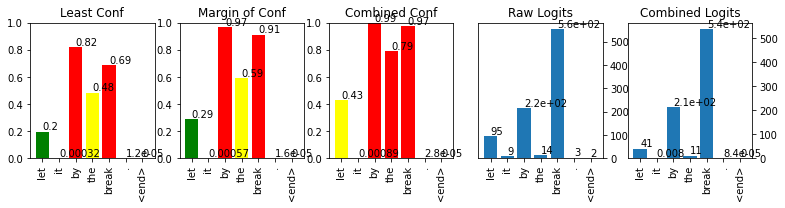



Target:  i worry about him .
Aggregate Sequence Uncertainty: 0.31807399047538637

Input: <start> אני מודאגת בגללו . <end>
Predicted translation: i'm not to the same . <end> 
Runner-up translation: i absolutely in blame photo out it 


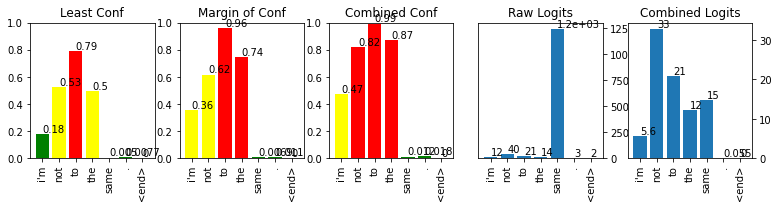



Target:  i'll see how tom is .
Aggregate Sequence Uncertainty: 0.31338913813233377

Input: <start> אראה מה עם תום . <end>
Predicted translation: i'll show what to tom . <end> 
Runner-up translation: see see some tom say is . 


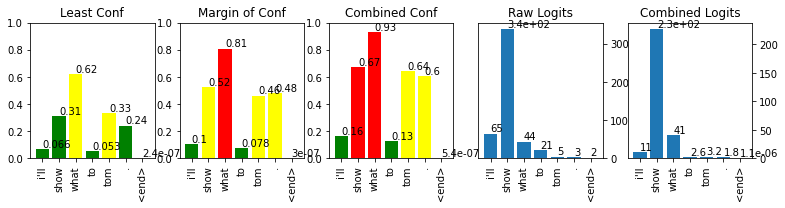



Target:  there she stands .
Aggregate Sequence Uncertainty: 0.3100893993396312

Input: <start> שם היא עומדת . <end>
Predicted translation: she is standing up . <end> 
Runner-up translation: there stood a back quick . 


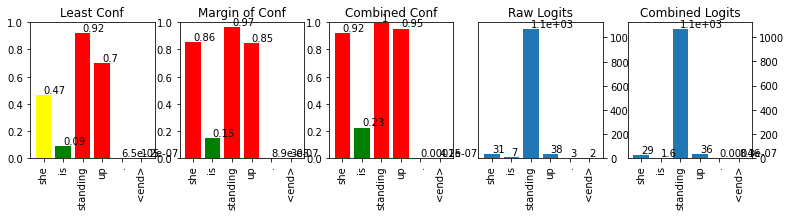



Target:  must i write in ink ?
Aggregate Sequence Uncertainty: 0.30235341042280195

Input: <start> אני חייבת לכתוב בדיו ? <end>
Predicted translation: may i eat in fight ? <end> 
Runner-up translation: can need speak myself ? . ? 


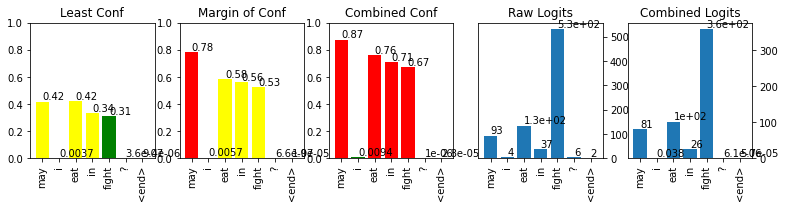



Target:  i'll live .
Aggregate Sequence Uncertainty: 0.2988463940564543

Input: <start> אחיה . <end>
Predicted translation: i'll come in . <end> 
Runner-up translation: i stop out here us 


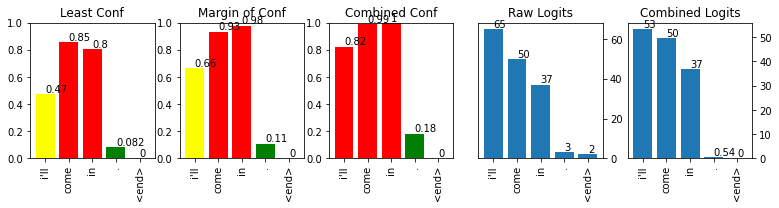



Target:  he's a creationist .
Aggregate Sequence Uncertainty: 0.2931405222043395

Input: <start> הוא מאמין בבריאת העולם . <end>
Predicted translation: he just eat on 1960 . <end> 
Runner-up translation: nobody must kept crazy town ? fuji 


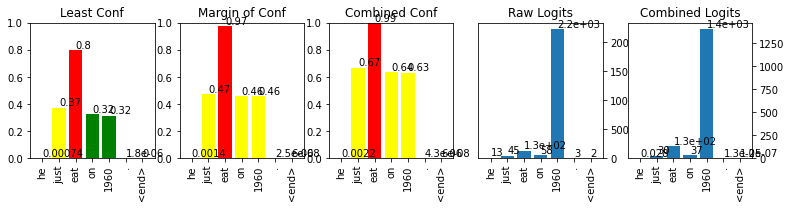



Target:  now listen up .
Aggregate Sequence Uncertainty: 0.29276331611908973

Input: <start> הסכת ושמע . <end>
Predicted translation: we'll wait up . <end> 
Runner-up translation: now be over now . 


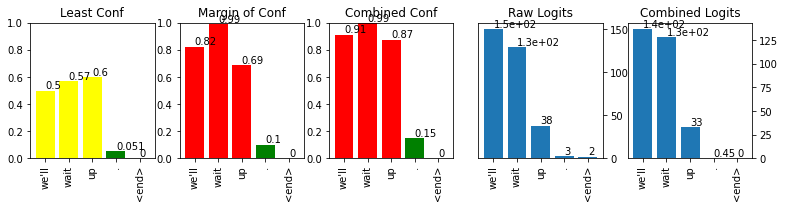



Target:  he loved the change .
Aggregate Sequence Uncertainty: 0.29242137679830194

Input: <start> השינוי נראה לו . <end>
Predicted translation: he went to her . <end> 
Runner-up translation: she hit his him came him 


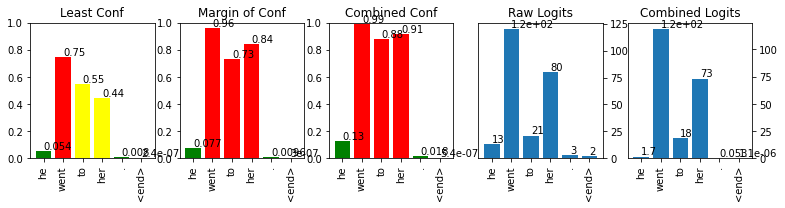



Target:  i'm behind schedule .
Aggregate Sequence Uncertainty: 0.2907161837443709

Input: <start> אני מפגר בלוח הזמנים . <end>
Predicted translation: i'm counting at once . <end> 
Runner-up translation: i the sorry i'm out fuji 


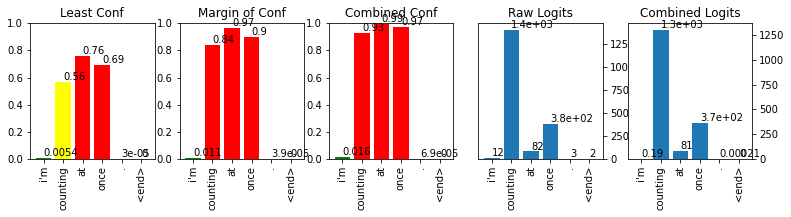



Target:  cops are everywhere .
Aggregate Sequence Uncertainty: 0.2887143546715379

Input: <start> שוטרים בכל מקום . <end>
Predicted translation: it's both died . <end> 
Runner-up translation: cops everywhere two of . 


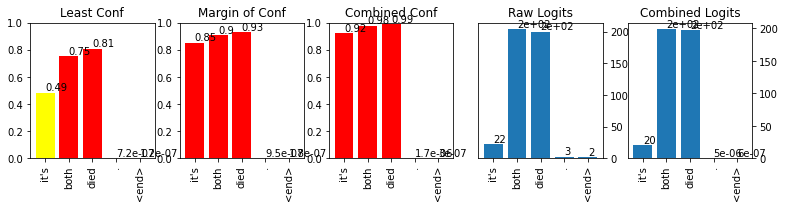



Target:  it'd be illegal .
Aggregate Sequence Uncertainty: 0.2863563006743789

Input: <start> זה יהיה בלתי חוקי . <end>
Predicted translation: it's never illegal . <end> 
Runner-up translation: it'd be use it . 


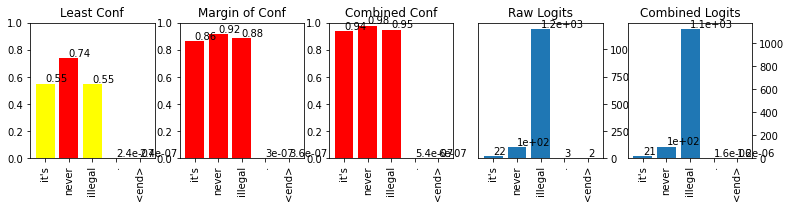



Target:  i'm late , aren't i ?
Aggregate Sequence Uncertainty: 0.2863376853987575

Input: <start> אני באיחור , לא כן ? <end>
Predicted translation: i'm out , isn't ? <end> 
Runner-up translation: am going yet aren't out ? 


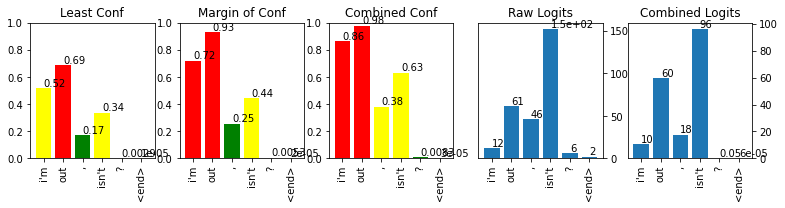



Target:  nothing comes easy .
Aggregate Sequence Uncertainty: 0.2828369652852416

Input: <start> שום דבר לא בא בקלות . <end>
Predicted translation: nothing is easily . <end> 
Runner-up translation: all came up go . 


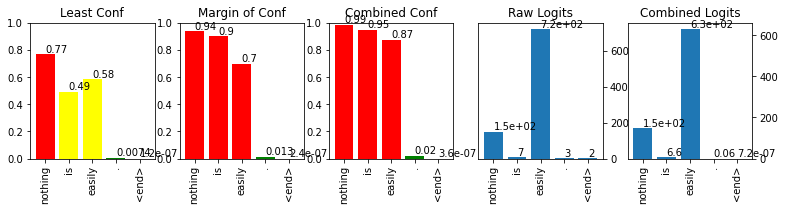



Target:  move over .
Aggregate Sequence Uncertainty: 0.27620097659528253

Input: <start> זוז הלאה . <end>
Predicted translation: move on the bill . <end> 
Runner-up translation: step over check check ? you 


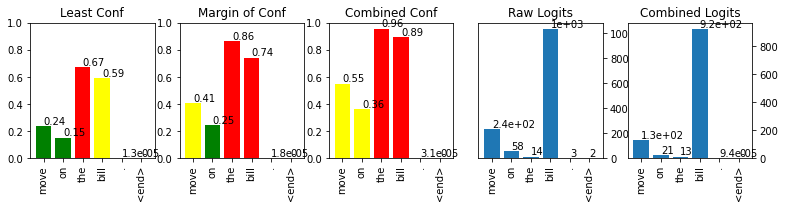



Target:  we need both .
Aggregate Sequence Uncertainty: 0.27485389858484266

Input: <start> הצטרכנו את שניהם . <end>
Predicted translation: we needed the change . <end> 
Runner-up translation: you betrayed both talking ? . 


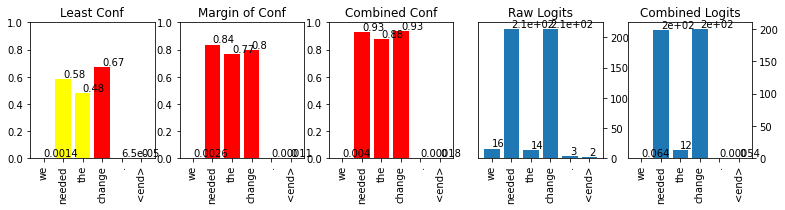



Target:  try to hang on .
Aggregate Sequence Uncertainty: 0.27409259909763933

Input: <start> תנסה לא להרפות . <end>
Predicted translation: try not to hang on . <end> 
Runner-up translation: take to your move . half . 


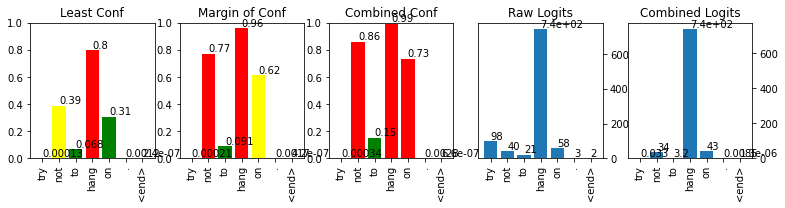



Target:  it'd be good .
Aggregate Sequence Uncertainty: 0.27175843277946116

Input: <start> זה עשוי להיות טוב . <end>
Predicted translation: that might good good . <end> 
Runner-up translation: it would be . one . 


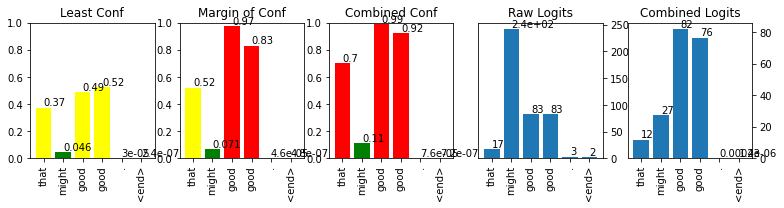



Target:  never tell a lie .
Aggregate Sequence Uncertainty: 0.27144624255597594

Input: <start> אל תשקר אף פעם ! <end>
Predicted translation: never tell me . <end> 
Runner-up translation: don't give up ! ? 


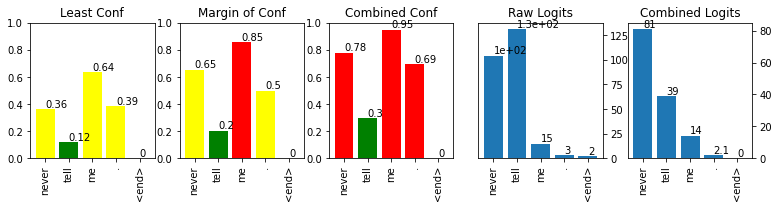



Target:  put on your coat .
Aggregate Sequence Uncertainty: 0.2706423236988485

Input: <start> לבש את מעילך ! <end>
Predicted translation: raise your pockets ! <end> 
Runner-up translation: wear the luck . what's 


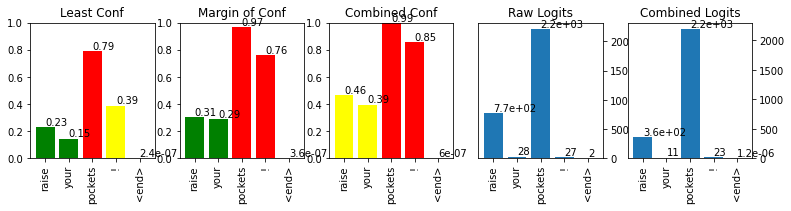



Target:  let no one escape .
Aggregate Sequence Uncertainty: 0.26766982674598694

Input: <start> שלא תאפשר לאיש להימלט . <end>
Predicted translation: let nobody downtown . <end> 
Runner-up translation: give give around up fuji 


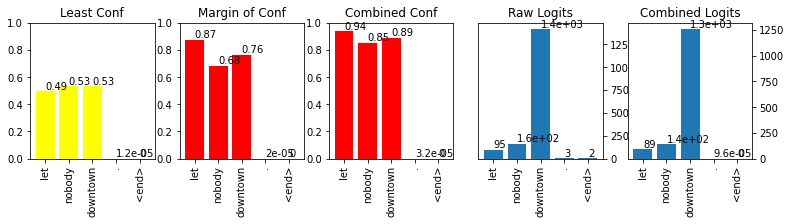



Target:  get some help .
Aggregate Sequence Uncertainty: 0.2666111983591691

Input: <start> תזעיק עזרה . <end>
Predicted translation: i refuse help . <end> 
Runner-up translation: help needed for now . 


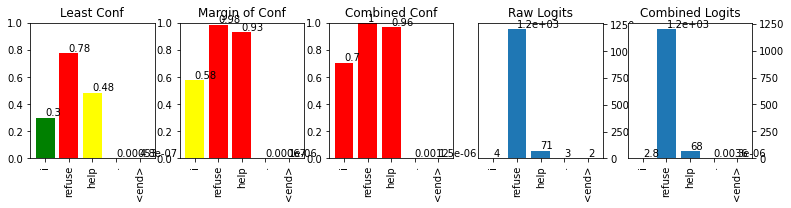



Target:  i do have a plan .
Aggregate Sequence Uncertainty: 0.26534781662048773

Input: <start> דווקא יש לי תכנית . <end>
Predicted translation: i have a short . <end> 
Runner-up translation: i've made i child a . 


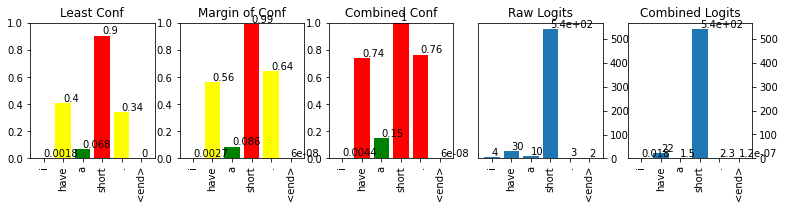



Target:  i cracked up .
Aggregate Sequence Uncertainty: 0.2638383150100708

Input: <start> התמוטטתי . <end>
Predicted translation: i had a seat . <end> 
Runner-up translation: i've was it walk out you 


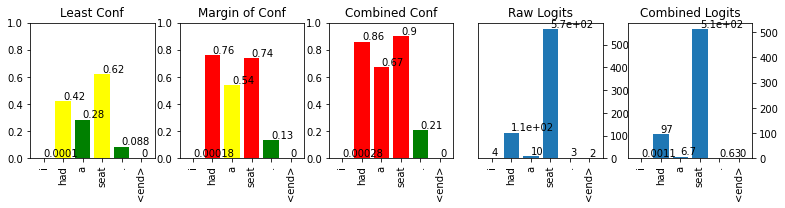



Target:  do it by yourself .
Aggregate Sequence Uncertainty: 0.26279675704427063

Input: <start> עשֶה זאת במו ידיך . <end>
Predicted translation: i took it to myself . <end> 
Runner-up translation: it was a in scream ? . 


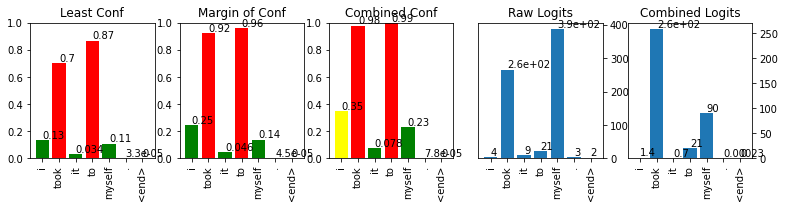



Target:  he seems hungry .
Aggregate Sequence Uncertainty: 0.25968733951449396

Input: <start> נראה שהוא רעב . <end>
Predicted translation: he's looking hungry . <end> 
Runner-up translation: she angry young ! . 


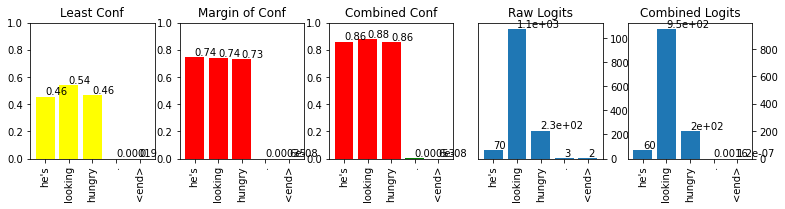



Target:  let's all do it .
Aggregate Sequence Uncertainty: 0.25764974784106015

Input: <start> בואו נעשה זאת כולנו . <end>
Predicted translation: let's all do that . <end> 
Runner-up translation: he's do all it ? that 


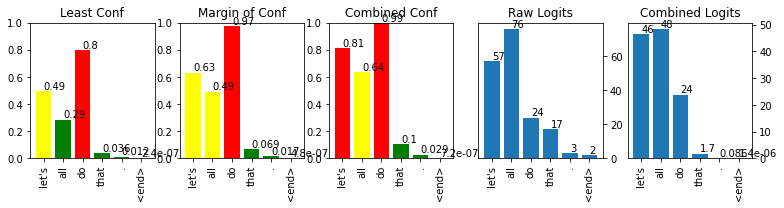



Target:  that will do .
Aggregate Sequence Uncertainty: 0.2563178255571984

Input: <start> די בכך . <end>
Predicted translation: it's well over . <end> 
Runner-up translation: it too for that that 


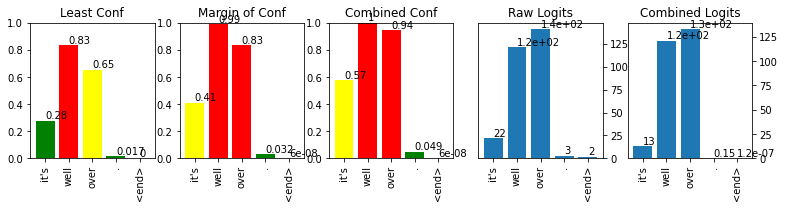



Target:  i hid in the closet .
Aggregate Sequence Uncertainty: 0.25623613614588975

Input: <start> הסתתרתי בארון . <end>
Predicted translation: i adopted in the closet . <end> 
Runner-up translation: i'd was the london bet ? . 


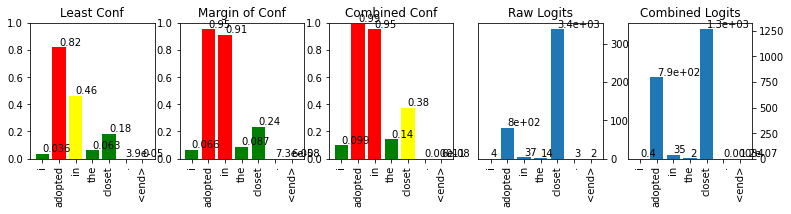



Target:  that's much worse .
Aggregate Sequence Uncertainty: 0.25572614641860125

Input: <start> זה הרבה יותר גרוע . <end>
Predicted translation: it's helping it's bad . <end> 
Runner-up translation: that's much of much ! . 


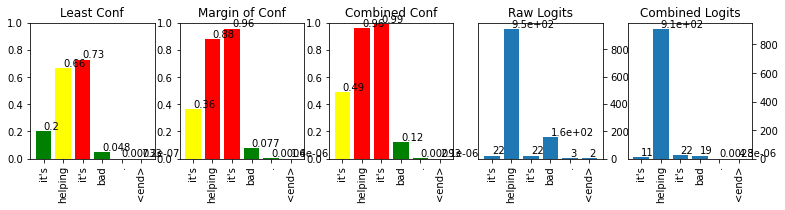



Target:  never let me go .
Aggregate Sequence Uncertainty: 0.25566051341593266

Input: <start> אל תרפה ממני לעולם . <end>
Predicted translation: let let me go . <end> 
Runner-up translation: never go go away down me 


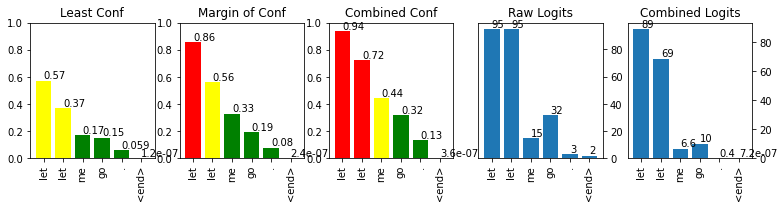



Target:  i'll manage .
Aggregate Sequence Uncertainty: 0.254255261644721

Input: <start> אנהל . <end>
Predicted translation: we were retreating . <end> 
Runner-up translation: i grinned tempted off . 


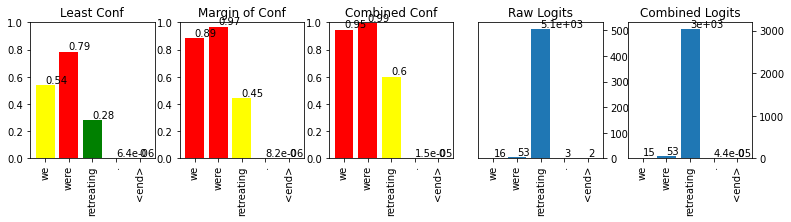



Target:  everybody needs one .
Aggregate Sequence Uncertainty: 0.251586976274848

Input: <start> כל אדם זקוק לאחד . <end>
Predicted translation: everyone needs one . <end> 
Runner-up translation: all must his suddenly fuji 


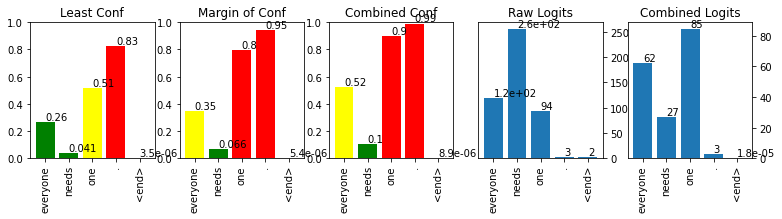



Target:  what might that be ?
Aggregate Sequence Uncertainty: 0.24625336127355696

Input: <start> מה זה אמור להיות ? <end>
Predicted translation: what should that be ? <end> 
Runner-up translation: what'll might it say like ? 


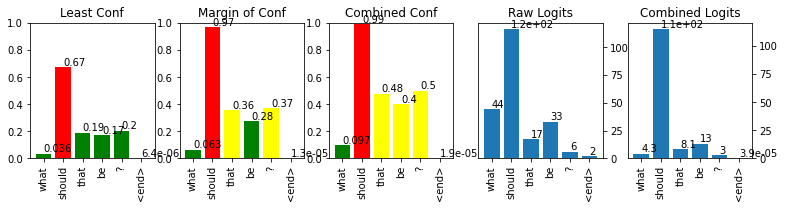



Target:  i literally blew it .
Aggregate Sequence Uncertainty: 0.24551595076918603

Input: <start> הוא פישל במלוא מובן המילה . <end>
Predicted translation: he deserves the same . <end> 
Runner-up translation: does warmed my change myself that 


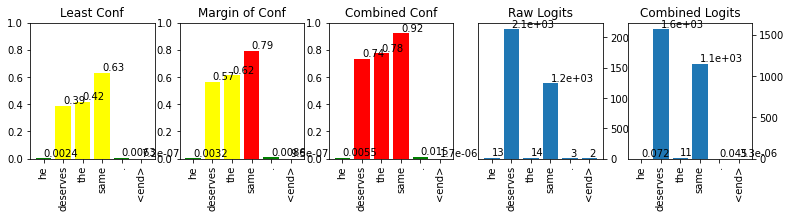



Target:  what'll happen ?
Aggregate Sequence Uncertainty: 0.24497295320034027

Input: <start> מה יקרה ? <end>
Predicted translation: what will you ? <end> 
Runner-up translation: what'll shall happen do ? 


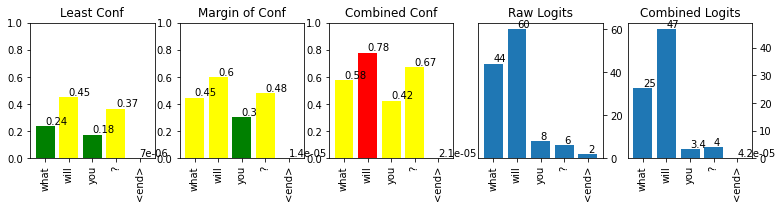



Target:  caption this photo .
Aggregate Sequence Uncertainty: 0.24425709322094918

Input: <start> תן כותרת לתצלום הזה . <end>
Predicted translation: give this brochure . <end> 
Runner-up translation: let me juice that ? 


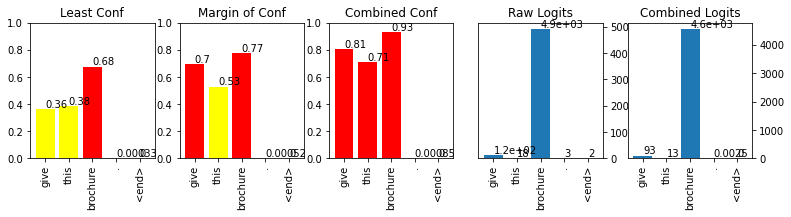



Target:  i have a runny nose .
Aggregate Sequence Uncertainty: 0.2429993527941406

Input: <start> האף שלי נוזל . <end>
Predicted translation: i nose is a answer . <end> 
Runner-up translation: my have has an earache nose . 


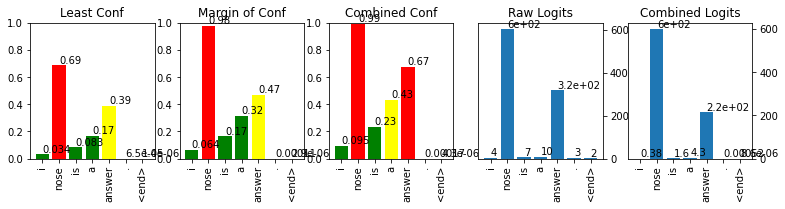



Target:  i was in love once .
Aggregate Sequence Uncertainty: 0.23974372819066048

Input: <start> הייתי פעם מאוהב . <end>
Predicted translation: i was in the man . <end> 
Runner-up translation: i'd could've the love river once . 


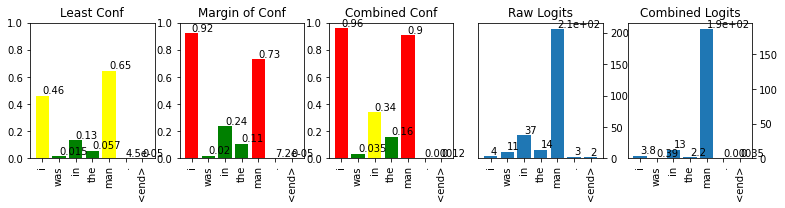



Target:  i was almost naked .
Aggregate Sequence Uncertainty: 0.23765176124870777

Input: <start> הייתי כמעט עירומה . <end>
Predicted translation: i was with mary . <end> 
Runner-up translation: it used used everyone ! . 


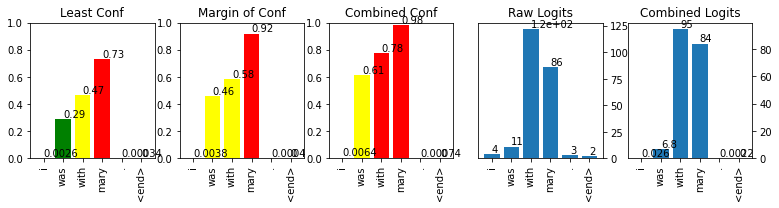



Target:  how i've missed you !
Aggregate Sequence Uncertainty: 0.23612161152996122

Input: <start> כמה שאני התגעגעתי אלייך . <end>
Predicted translation: i'm missed you . <end> 
Runner-up translation: how better i ! you 


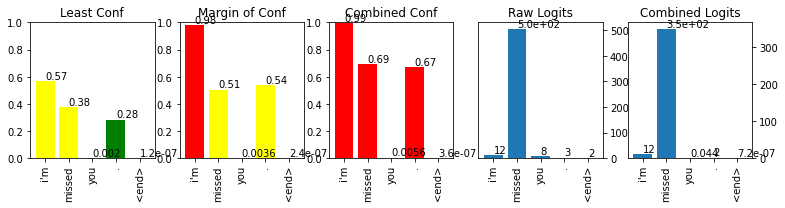



Target:  should i leave ?
Aggregate Sequence Uncertainty: 0.2348547473549843

Input: <start> לעזוב ? <end>
Predicted translation: will leave me ? <end> 
Runner-up translation: should you ? out ? 


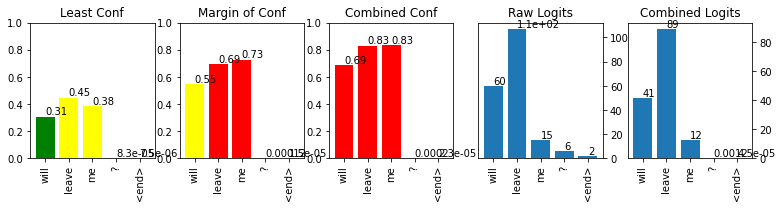



Target:  hit it with a stick .
Aggregate Sequence Uncertainty: 0.23481154916808009

Input: <start> תכה על זה עם מקל . <end>
Predicted translation: it used to win . <end> 
Runner-up translation: i free it myself ? . 


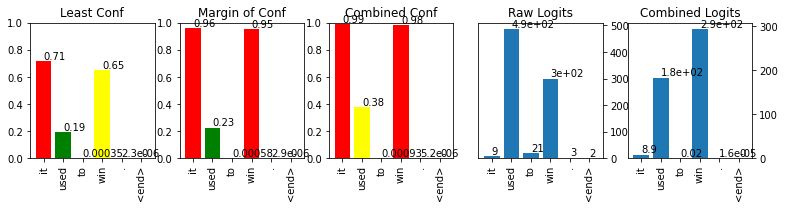



Target:  tom stood quickly .
Aggregate Sequence Uncertainty: 0.2335667610168457

Input: <start> תום נעמד מהר . <end>
Predicted translation: tom stood up . <end> 
Runner-up translation: tom's got quickly quick . 


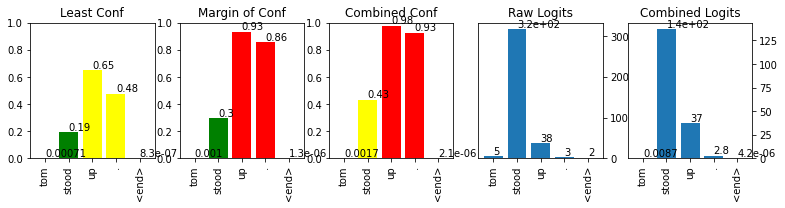



Target:  that's not for you .
Aggregate Sequence Uncertainty: 0.23250465393066405

Input: <start> זה לא עבורך . <end>
Predicted translation: it's not a help . <end> 
Runner-up translation: it won't for wait it . 


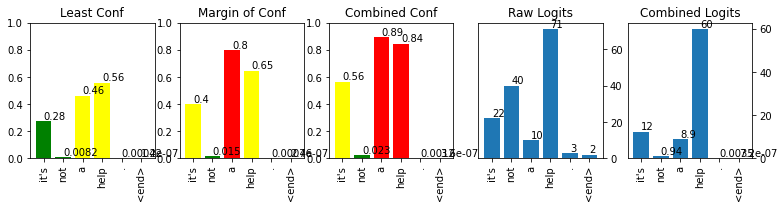



Target:  my stomach's full .
Aggregate Sequence Uncertainty: 0.2301415378926322

Input: <start> יש לי בטן מלאה . <end>
Predicted translation: my head aches . <end> 
Runner-up translation: i stomach's full ! . 


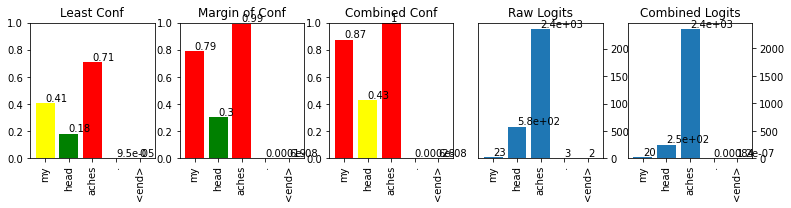



Target:  i can't tell yet .
Aggregate Sequence Uncertainty: 0.22843097895383835

Input: <start> אני עדיין לא יכול לספר . <end>
Predicted translation: i can't still . <end> 
Runner-up translation: i'm still can't , . 


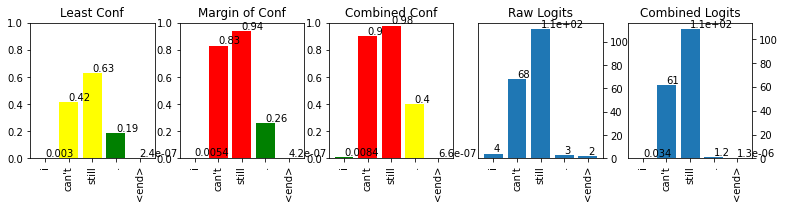



Target:  i see their point .
Aggregate Sequence Uncertainty: 0.2234199032187462

Input: <start> אני מבין את נקודת השקפתם . <end>
Predicted translation: i see the change . <end> 
Runner-up translation: i'm understand my bird myself fuji 


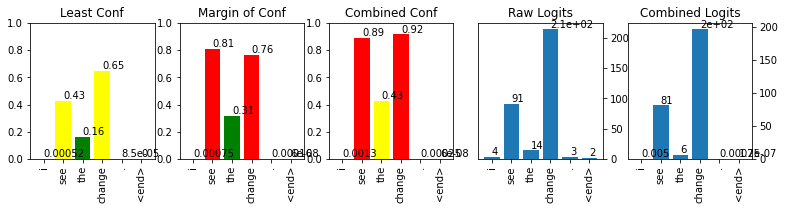



Target:  tom is behind you .
Aggregate Sequence Uncertainty: 0.2225106494501233

Input: <start> תום מאחוריך . <end>
Predicted translation: tom is standing . <end> 
Runner-up translation: tom's will first back . 


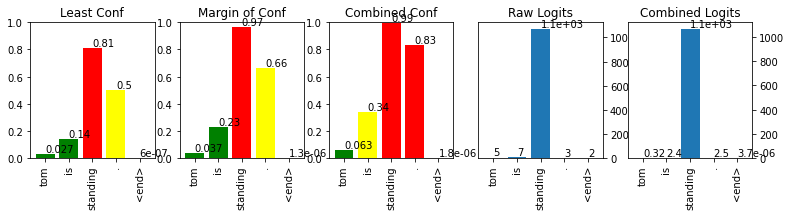



Target:  how did you know ?
Aggregate Sequence Uncertainty: 0.22171379998326302

Input: <start> מאין ידעת ? <end>
Predicted translation: where are know ? <end> 
Runner-up translation: how can you , ? 


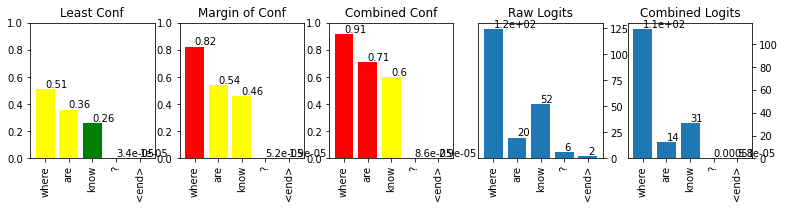



Target:  i was cheated .
Aggregate Sequence Uncertainty: 0.2212451484054327

Input: <start> רימו אותי . <end>
Predicted translation: tom was me . <end> 
Runner-up translation: i cheated stabbed up me 


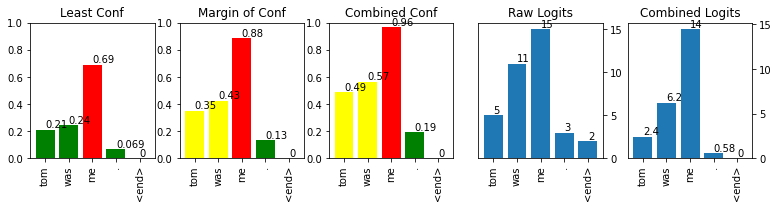



Target:  i eat with my hands .
Aggregate Sequence Uncertainty: 0.22098032627254724

Input: <start> אני אוכל בידיים . <end>
Predicted translation: i eat the backyard . <end> 
Runner-up translation: i'm drive with risks out you 


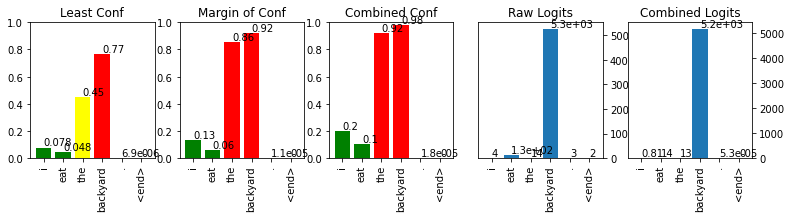



Target:  i can do without it .
Aggregate Sequence Uncertainty: 0.22086826469749213

Input: <start> אני יכול להסתדר בלי זה . <end>
Predicted translation: i can do this along . <end> 
Runner-up translation: can could try it , it it 


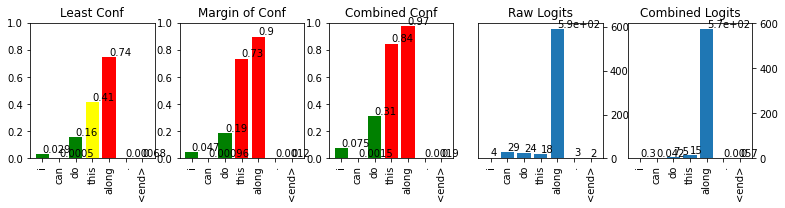



Target:  he deals in whiskey .
Aggregate Sequence Uncertainty: 0.21987227592617273

Input: <start> הוא סוחר בוויסקי . <end>
Predicted translation: he is about forty . <end> 
Runner-up translation: he's deals a grain agent . 


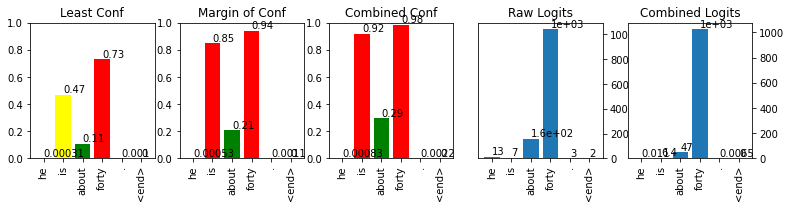



Target:  i just don't buy it .
Aggregate Sequence Uncertainty: 0.21853164136409758

Input: <start> אני פשוט לא קונה את זה . <end>
Predicted translation: i just buy that . <end> 
Runner-up translation: i'm can't don't it ! that 


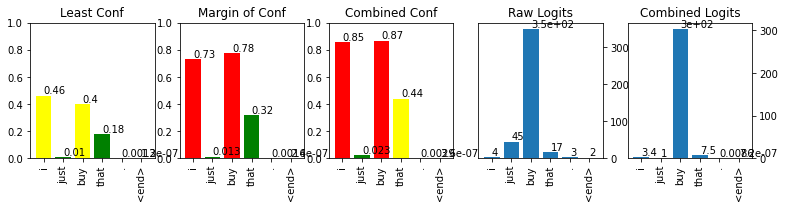



Target:  i lack imagination .
Aggregate Sequence Uncertainty: 0.21810157879081088

Input: <start> אין לי דמיון . <end>
Predicted translation: i have no comment . <end> 
Runner-up translation: i'm don't a doubts ! . 


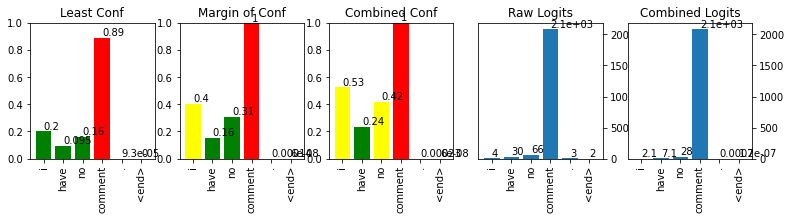



Target:  that's ok with tom .
Aggregate Sequence Uncertainty: 0.21759977638721467

Input: <start> זה בסדר מבחינתו של תום . <end>
Predicted translation: that's ok . <end> 
Runner-up translation: it's all , tom 


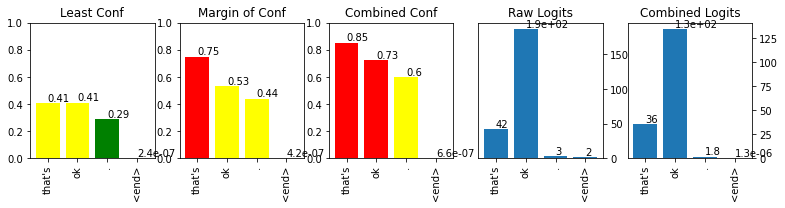



Target:  when do we leave ?
Aggregate Sequence Uncertainty: 0.2148605464026332

Input: <start> מתי יוצאים לדרך ? <end>
Predicted translation: when didn't you call ? <end> 
Runner-up translation: why will get hurt me ? 


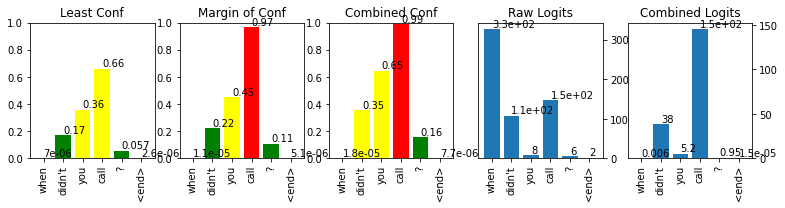



Target:  attack !
Aggregate Sequence Uncertainty: 0.213696838542819

Input: <start> תקוף ! <end>
Predicted translation: get up ! <end> 
Runner-up translation: stand down to you 


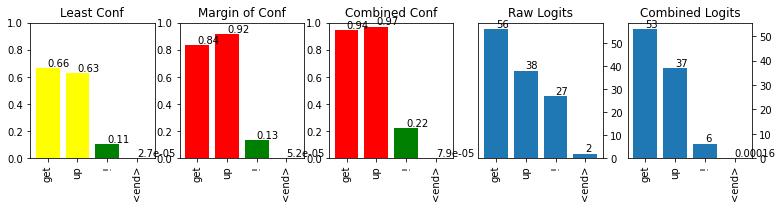



Target:  you're reliable .
Aggregate Sequence Uncertainty: 0.21301244483329357

Input: <start> אפשר לסמוך עליך . <end>
Predicted translation: you're going to win . <end> 
Runner-up translation: you replaceable about go you you 


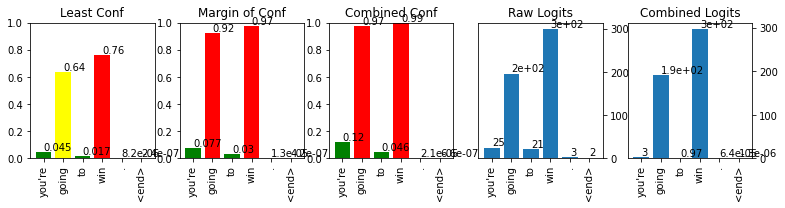



Target:  i'm sure of it .
Aggregate Sequence Uncertainty: 0.211613779515028

Input: <start> אני בטוח בכך <end>
Predicted translation: i'm used to i ? <end> 
Runner-up translation: i certain it you ! ? 


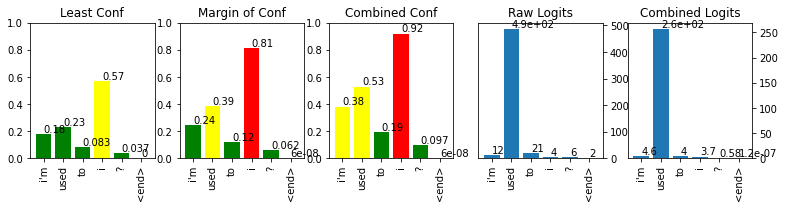



Target:  he must be innocent .
Aggregate Sequence Uncertainty: 0.21022230684757232

Input: <start> הוא חייב להיות זכאי . <end>
Predicted translation: he must be all . <end> 
Runner-up translation: it just succeed clean coming . 


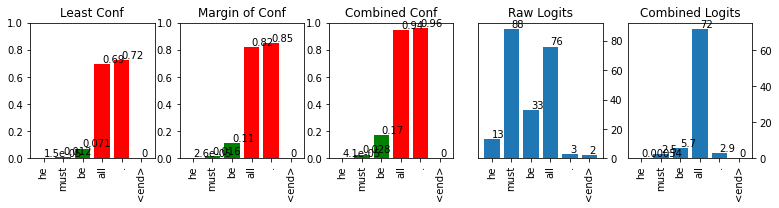



Target:  she waved at him .
Aggregate Sequence Uncertainty: 0.208008124679327

Input: <start> היא נופפה לו . <end>
Predicted translation: she is him . <end> 
Runner-up translation: she's listens kissing off him 


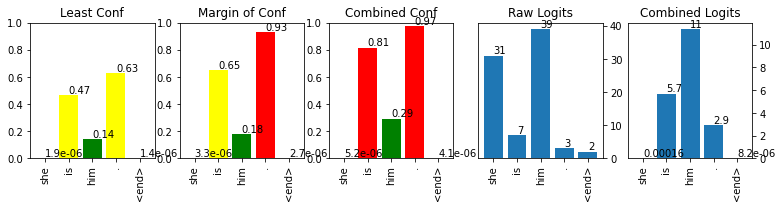



Target:  i don't usually lie .
Aggregate Sequence Uncertainty: 0.20776753502432257

Input: <start> אינני מרבה לשקר . <end>
Predicted translation: i don't buy best . <end> 
Runner-up translation: i'm can't usually lie ! . 


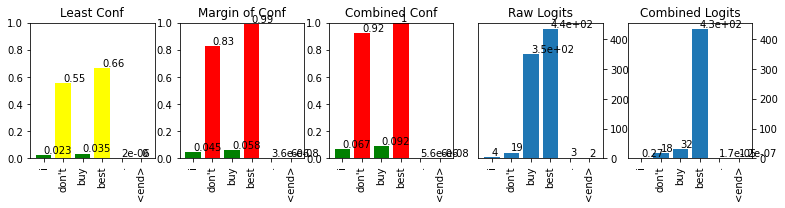



Target:  tom got the hint .
Aggregate Sequence Uncertainty: 0.20770803852938116

Input: <start> נפל לתום האסימון . <end>
Predicted translation: i turned hired . <end> 
Runner-up translation: tom abandoned betrayed myself . 


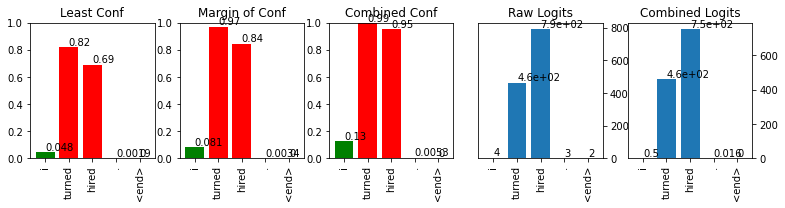



Target:  when shall we eat ?
Aggregate Sequence Uncertainty: 0.20717559866607188

Input: <start> מתי נאכל ? <end>
Predicted translation: when do we eat ? <end> 
Runner-up translation: can shall anybody start asleep ? 


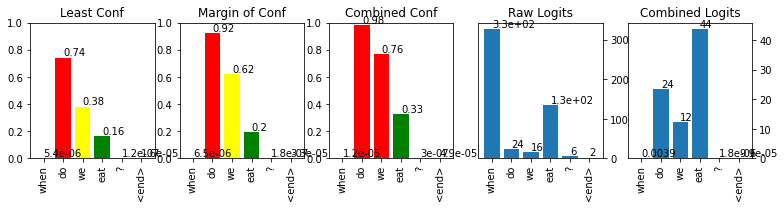



Target:  i need sleep .
Aggregate Sequence Uncertainty: 0.20610530353151263

Input: <start> אני צריך שינה . <end>
Predicted translation: i need the wheel . <end> 
Runner-up translation: i've needed more barber out . 


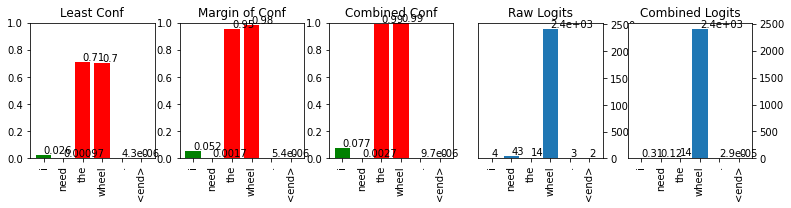



Target:  help tom out .
Aggregate Sequence Uncertainty: 0.20477191153913737

Input: <start> סייע לתום . <end>
Predicted translation: i helped tom out . <end> 
Runner-up translation: go shot out in tom tom 


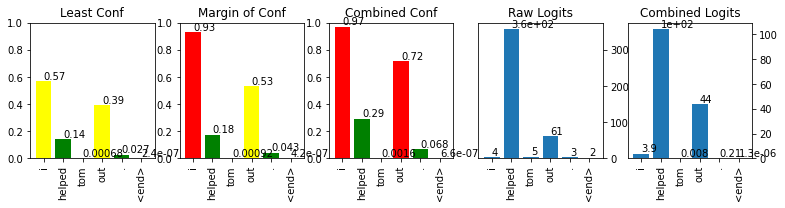



Target:  we looked for her .
Aggregate Sequence Uncertainty: 0.2047356866300106

Input: <start> חיפשנו אותה . <end>
Predicted translation: i laughed at her angry . <end> 
Runner-up translation: we moved her angry back ? her 


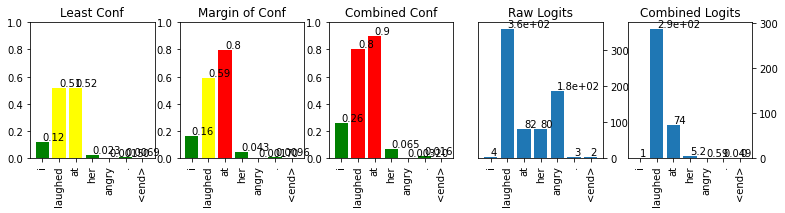



Target:  the fight is over .
Aggregate Sequence Uncertainty: 0.20101540610194207

Input: <start> המאבק הסתיים . <end>
Predicted translation: the meeting over . <end> 
Runner-up translation: it's fight all here . 


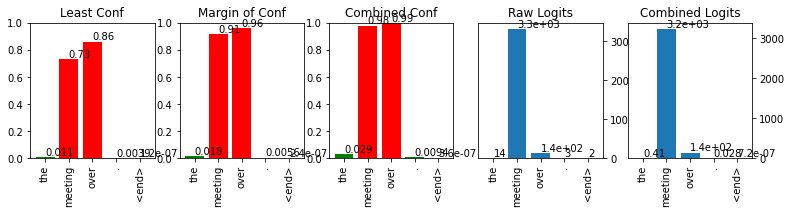



Target:  water the plants .
Aggregate Sequence Uncertainty: 0.20003465227782727

Input: <start> תשקה את הצמחים . <end>
Predicted translation: water the oldest . <end> 
Runner-up translation: shame are dose ! you 


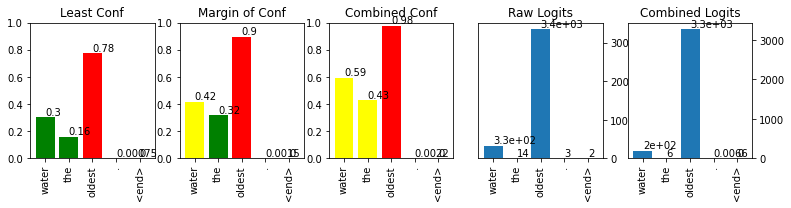

(array([], dtype=float64), array([], dtype=float64))

In [79]:
get_ranked_uncertainty(val_sequences_means, len(val_unsure_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_unsure_non_matches, results=val_results)

Wow!  Pretty bad stuff there - but that was exactly what we were looking for as candidates for a first pass in an Active Learning cycle.  Also, it shows that the model is aware of its "known unknowns".  Finally, let's touch on the overall look of the validation set apart from the high uncertainty set:

In [80]:
val_matches, val_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size-val_high_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set less confused matches: " + str(len(val_matches)))
print("Validation set less confused non-Matches: " + str(len(val_non_matches)))
print("Matching: {:.1%}".format((len(val_matches)/(len(val_matches)+len(val_non_matches)))))

Validation set less confused matches: 436
Validation set less confused non-Matches: 468
Matching: 48.2%


In various runs, I range from about 25% to even 75% matching, and therefore known to be accurate - much better than our highly uncertain set.  And of course, many of these non-matches may be viable translations.  Exploring and optimizing the thresholds should help, so let's try a different way of discovering non-matches (and, among those, errors) than just a single threshold:

##Confirming that Scores do successfully model Accuracy Confidence

So our thresholds we chose to do some exploratory analysis were arbitrary:

In [81]:
import scipy as sp
high_uncertainty_threshold_percentile = sp.stats.percentileofscore(val_sequences_means, uncertainty_sampling_treshold)
print ("Percentile of our high uncertainty threshold for validation scores: " + str(high_uncertainty_threshold_percentile))

Percentile of our high uncertainty threshold for validation scores: 90.4


Let's try to do a more formal job in exploring uncertainty as a predictor for potential errors, using a range percentile thresholds instead:

In [82]:
val_total_matches, val_total_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Total Validation set matches: " + str(len(val_total_matches)))
print("Validation set non-Matches: " + str(len(val_total_non_matches)))
print("Matching: {:.1%}".format((len(val_total_matches)/(len(val_total_matches)+len(val_total_non_matches)))))

Total Validation set matches: 449
Validation set non-Matches: 551
Matching: 44.9%


Depending on the validation set, non-match percentages can vary widely, both very much above and very much below 50%.  If much above 50%, non-matches will tend to be concentrated in the high-uncertainty percentiles much more than if not.  If below 50%, we'll want to still use analysis sampling from different percentile ranges.  

In [83]:
def find_uncertainty_predictivity(percentile=90): #higher the percentile, higher the uncertainty
  percentile_threshold = np.percentile(val_sequences_means, percentile)
  print("Percentile score threshold: " + str(percentile_threshold))
  #first_decile = [v for v in val_sequences_means if v <= tenth_percentile]
  percentile_len = total_test_size*(100-percentile)//100
  #print(val_sequences_means)

  val_percentile_matches, val_percentile_non_matches = get_ranked_uncertainty(val_sequences_means, percentile_len, target_tensor_val, 
                       input_tensor=input_tensor_val, direction='DESCENDING', display=False, results=val_results)
  print("Matches for the " + str(percentile) + "th percentile: " + str(len(val_percentile_matches)))
  print("Non-Matches for the " + str(percentile) + "th percentile: " + str(len(val_percentile_non_matches)))
  print("Non-Matching: {:.1%}".format((len(val_percentile_non_matches)/(len(val_percentile_matches)+len(val_percentile_non_matches)))))
  print("\033[1m{:.1%}\033[0m".format(len(val_percentile_non_matches)/(len(val_total_non_matches))) +
        " of the potential errors are found by \033[1m{:.1%}\033[0m".format((100-percentile)/100) +
        " of the target sentences with the highest uncertainty score.")
  #return val_percentile_matches, val_percentile_non_matches

So now we have our validation set matches, (i.e. known to be accurate because the match), and non-matches (potential errors in prediction). Let's try to find out how uncertainty scoring can predict the non-matches, (and therefore, potential errors), by stepping 10 percentiles (deciles):

In [84]:
find_uncertainty_predictivity(90)

Percentile score threshold: 0.19808512728661298
Matches for the 90th percentile: 13
Non-Matches for the 90th percentile: 87
Non-Matching: 87.0%
15.8% of the potential errors are found by 10.0% of the target sentences with the highest uncertainty score.


In [85]:
find_uncertainty_predictivity(80)

Percentile score threshold: 0.15749821394681934
Matches for the 80th percentile: 25
Non-Matches for the 80th percentile: 175
Non-Matching: 87.5%
31.8% of the potential errors are found by 20.0% of the target sentences with the highest uncertainty score.


In [86]:
find_uncertainty_predictivity(70)

Percentile score threshold: 0.11812805581837893
Matches for the 70th percentile: 56
Non-Matches for the 70th percentile: 244
Non-Matching: 81.3%
44.3% of the potential errors are found by 30.0% of the target sentences with the highest uncertainty score.


In [87]:
find_uncertainty_predictivity(20)

Percentile score threshold: 0.017820106744766237
Matches for the 20th percentile: 311
Non-Matches for the 20th percentile: 489
Non-Matching: 61.1%
88.7% of the potential errors are found by 80.0% of the target sentences with the highest uncertainty score.


In [88]:
find_uncertainty_predictivity(10)

Percentile score threshold: 0.006455828547477721
Matches for the 10th percentile: 378
Non-Matches for the 10th percentile: 522
Non-Matching: 58.0%
94.7% of the potential errors are found by 90.0% of the target sentences with the highest uncertainty score.


So it looks like the trend is clear, (not very dramatically for some validation sets), that the higher the uncertainty, the higher the potential errors (mismatches to reference translation) 
Let's dive into sampling and look at the mismatches in different deciles:

In [89]:
def show_mismatches_in_percentile_range_results(low_percentile, high_percentile, number_to_display=None):
  low_percentile_threshold = np.percentile(val_sequences_means, low_percentile)
  high_percentile_threshold = np.percentile(val_sequences_means, high_percentile)
  print("Low Percentile score threshold: " + str(low_percentile_threshold))
  print("High Percentile score threshold: " + str(high_percentile_threshold))
  #print(len(val_sequences_means))
  percentile_results = [list(val_sequences_means).index(v) for v in val_sequences_means if v > low_percentile_threshold 
                                                                                        if v <= high_percentile_threshold]
  #print(percentile_results)    
  #get_ranked_uncertainty(training_sequences_means, len(training_non_matches), target_tensor_train, 
  #                     input_tensor=input_tensor_train, ranking=training_non_matches, results=training_results)                                                            
  val_percentile_range_matches, val_percentile_range_non_matches = get_ranked_uncertainty(val_sequences_means, len(percentile_results), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=percentile_results, direction='DESCENDING', display=False, results=val_results)
  if not number_to_display:
    number_to_display = len(val_percentile_range_non_matches)
  get_ranked_uncertainty(val_sequences_means, number_to_display, target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_percentile_range_non_matches, results=val_results)

**High Uncertainty -> Low Accuracy**:

Low Percentile score threshold: 0.19808512728661298
High Percentile score threshold: 0.4327251685783267


Target:  i'll manage .
Aggregate Sequence Uncertainty: 0.254255261644721

Input: <start> אנהל . <end>
Predicted translation: we were retreating . <end> 
Runner-up translation: i grinned tempted off . 


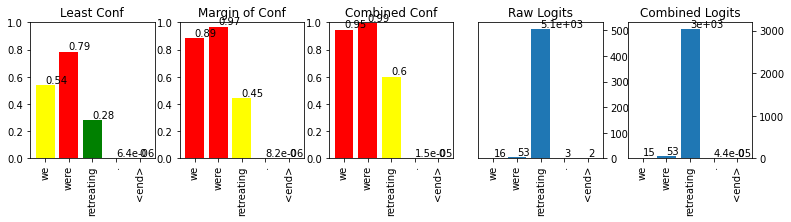



Target:  do it by yourself .
Aggregate Sequence Uncertainty: 0.26279675704427063

Input: <start> עשֶה זאת במו ידיך . <end>
Predicted translation: i took it to myself . <end> 
Runner-up translation: it was a in scream ? . 


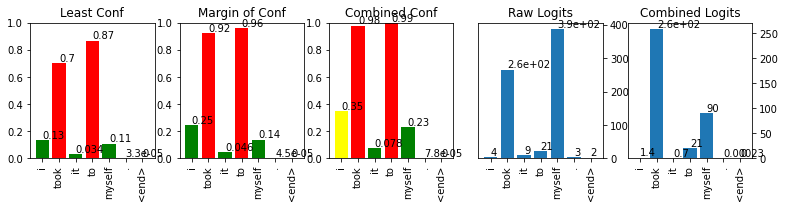



Target:  the fight is over .
Aggregate Sequence Uncertainty: 0.20101540610194207

Input: <start> המאבק הסתיים . <end>
Predicted translation: the meeting over . <end> 
Runner-up translation: it's fight all here . 


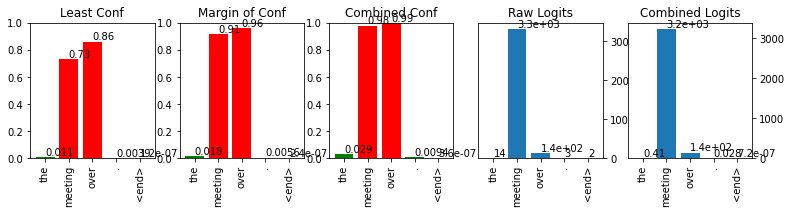



Target:  today is my treat .
Aggregate Sequence Uncertainty: 0.33244844879955054

Input: <start> היום אני מזמין . <end>
Predicted translation: it's not my treat . <end> 
Runner-up translation: i'm my the place now . 


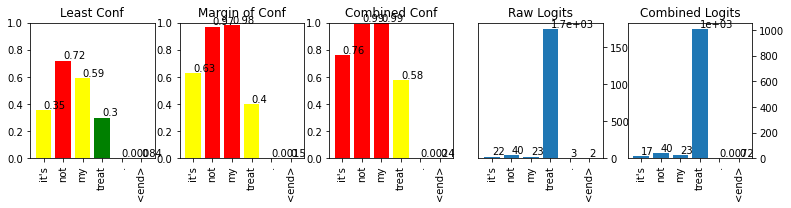



Target:  i hid in the closet .
Aggregate Sequence Uncertainty: 0.25623613614588975

Input: <start> הסתתרתי בארון . <end>
Predicted translation: i adopted in the closet . <end> 
Runner-up translation: i'd was the london bet ? . 


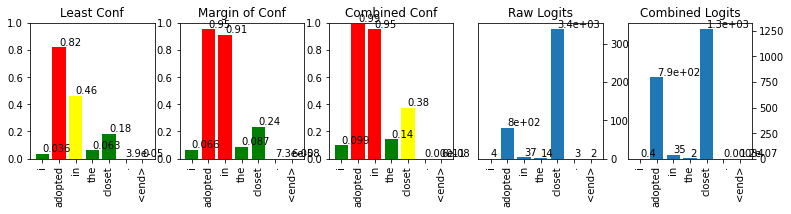



Target:  i caught the flu .
Aggregate Sequence Uncertainty: 0.3441784563008696

Input: <start> תפסה אותי שפעת . <end>
Predicted translation: i let you go . <end> 
Runner-up translation: now sent me changed in you 


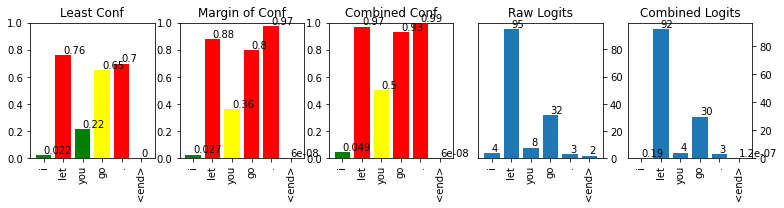



Target:  that will do .
Aggregate Sequence Uncertainty: 0.2563178255571984

Input: <start> די בכך . <end>
Predicted translation: it's well over . <end> 
Runner-up translation: it too for that that 


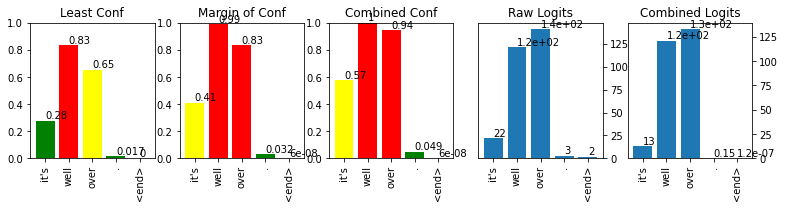



Target:  get some help .
Aggregate Sequence Uncertainty: 0.2666111983591691

Input: <start> תזעיק עזרה . <end>
Predicted translation: i refuse help . <end> 
Runner-up translation: help needed for now . 


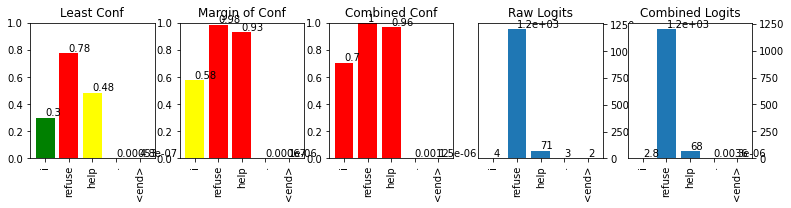



Target:  we need both .
Aggregate Sequence Uncertainty: 0.27485389858484266

Input: <start> הצטרכנו את שניהם . <end>
Predicted translation: we needed the change . <end> 
Runner-up translation: you betrayed both talking ? . 


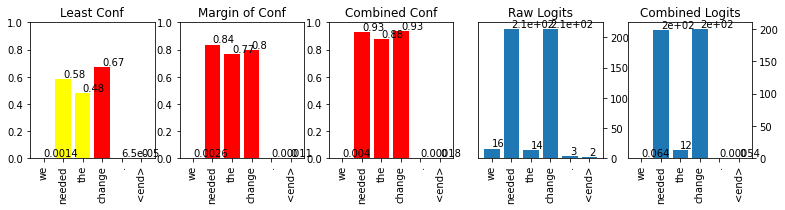



Target:  it'd be good .
Aggregate Sequence Uncertainty: 0.27175843277946116

Input: <start> זה עשוי להיות טוב . <end>
Predicted translation: that might good good . <end> 
Runner-up translation: it would be . one . 


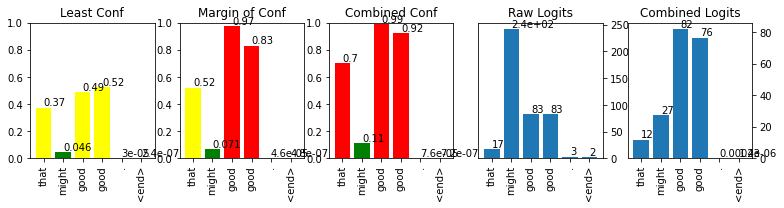



Target:  nothing comes easy .
Aggregate Sequence Uncertainty: 0.2828369652852416

Input: <start> שום דבר לא בא בקלות . <end>
Predicted translation: nothing is easily . <end> 
Runner-up translation: all came up go . 


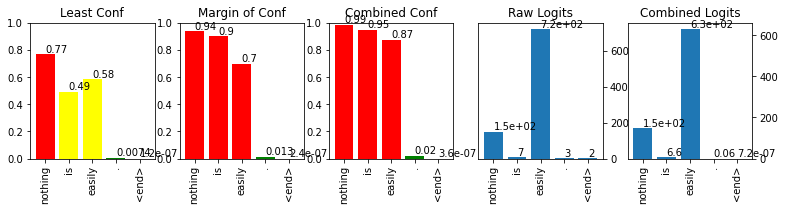



Target:  i do have a plan .
Aggregate Sequence Uncertainty: 0.26534781662048773

Input: <start> דווקא יש לי תכנית . <end>
Predicted translation: i have a short . <end> 
Runner-up translation: i've made i child a . 


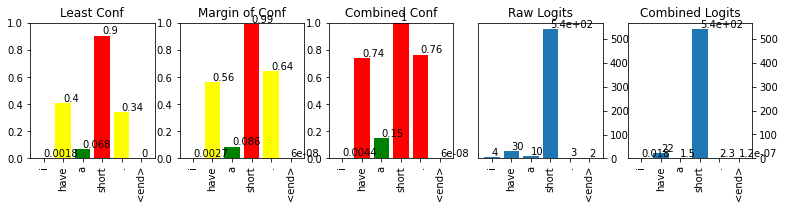



Target:  there she stands .
Aggregate Sequence Uncertainty: 0.3100893993396312

Input: <start> שם היא עומדת . <end>
Predicted translation: she is standing up . <end> 
Runner-up translation: there stood a back quick . 


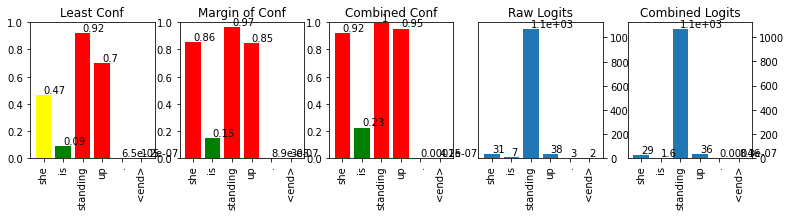



Target:  watch your step .
Aggregate Sequence Uncertainty: 0.19991233199834824

Input: <start> זהירות מדרגה ! <end>
Predicted translation: watch your careful ! <end> 
Runner-up translation: look yourself step . you 


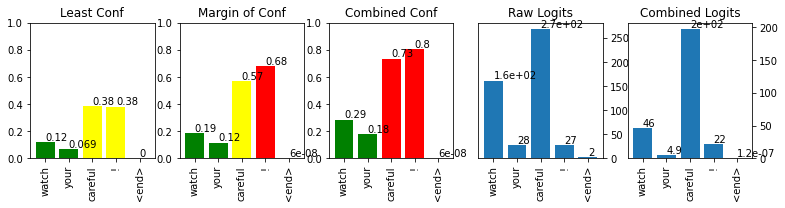



Target:  let no one escape .
Aggregate Sequence Uncertainty: 0.26766982674598694

Input: <start> שלא תאפשר לאיש להימלט . <end>
Predicted translation: let nobody downtown . <end> 
Runner-up translation: give give around up fuji 


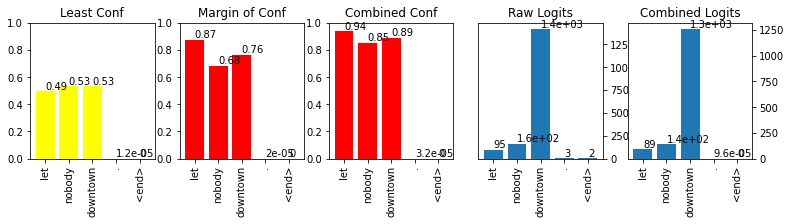



Target:  i don't usually lie .
Aggregate Sequence Uncertainty: 0.20776753502432257

Input: <start> אינני מרבה לשקר . <end>
Predicted translation: i don't buy best . <end> 
Runner-up translation: i'm can't usually lie ! . 


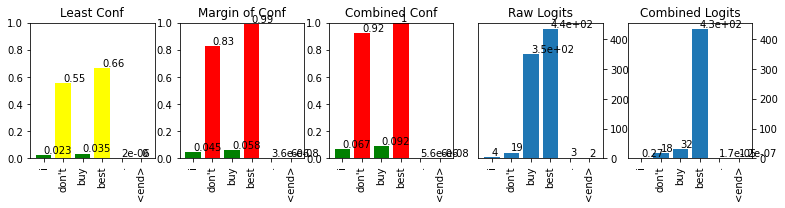



Target:  how i've missed you !
Aggregate Sequence Uncertainty: 0.23612161152996122

Input: <start> כמה שאני התגעגעתי אלייך . <end>
Predicted translation: i'm missed you . <end> 
Runner-up translation: how better i ! you 


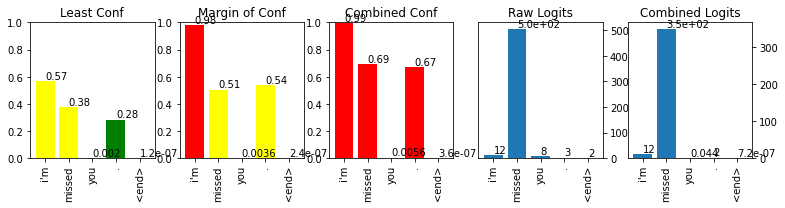



Target:  i cracked up .
Aggregate Sequence Uncertainty: 0.2638383150100708

Input: <start> התמוטטתי . <end>
Predicted translation: i had a seat . <end> 
Runner-up translation: i've was it walk out you 


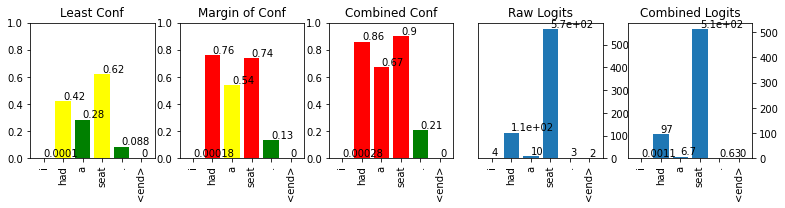



Target:  caption this photo .
Aggregate Sequence Uncertainty: 0.24425709322094918

Input: <start> תן כותרת לתצלום הזה . <end>
Predicted translation: give this brochure . <end> 
Runner-up translation: let me juice that ? 


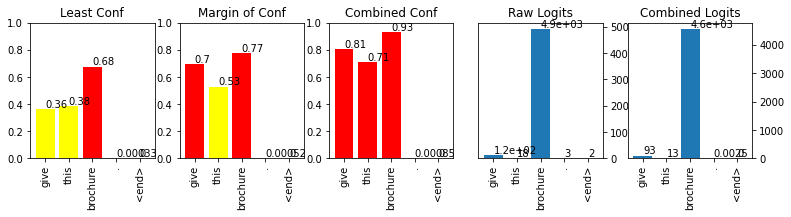



Target:  i got paid today .
Aggregate Sequence Uncertainty: 0.3346091156825423

Input: <start> שילמו לי היום . <end>
Predicted translation: the soldier is today . <end> 
Runner-up translation: i answer hurts boring today today 


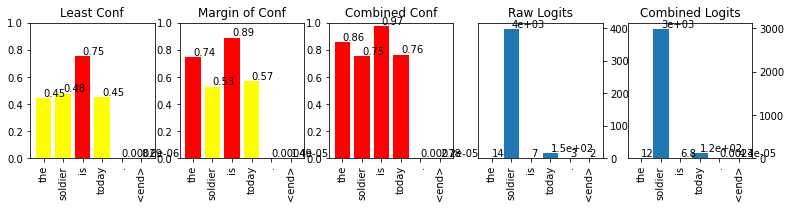



Target:  when do we leave ?
Aggregate Sequence Uncertainty: 0.2148605464026332

Input: <start> מתי יוצאים לדרך ? <end>
Predicted translation: when didn't you call ? <end> 
Runner-up translation: why will get hurt me ? 


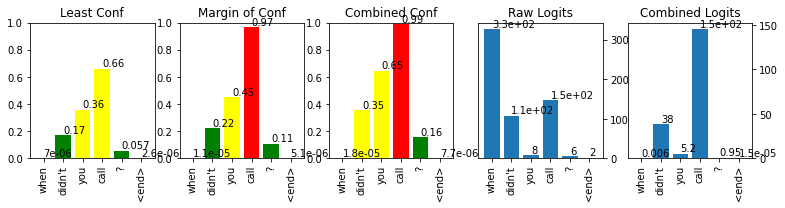



Target:  cops are everywhere .
Aggregate Sequence Uncertainty: 0.2887143546715379

Input: <start> שוטרים בכל מקום . <end>
Predicted translation: it's both died . <end> 
Runner-up translation: cops everywhere two of . 


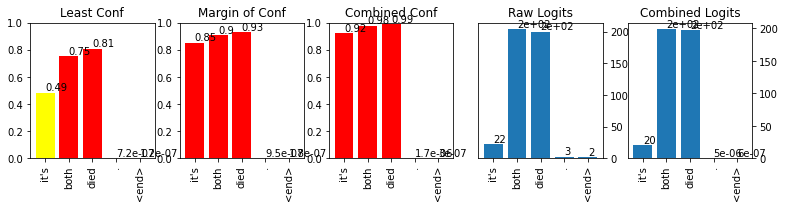



Target:  i'm late , aren't i ?
Aggregate Sequence Uncertainty: 0.2863376853987575

Input: <start> אני באיחור , לא כן ? <end>
Predicted translation: i'm out , isn't ? <end> 
Runner-up translation: am going yet aren't out ? 


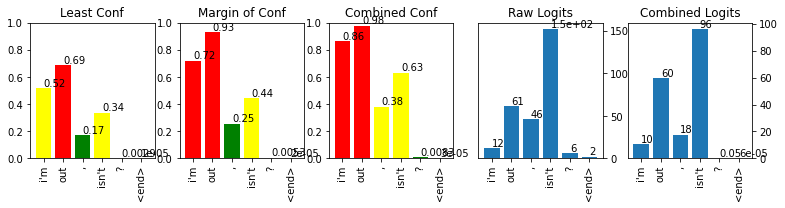



Target:  i'm behind schedule .
Aggregate Sequence Uncertainty: 0.2907161837443709

Input: <start> אני מפגר בלוח הזמנים . <end>
Predicted translation: i'm counting at once . <end> 
Runner-up translation: i the sorry i'm out fuji 


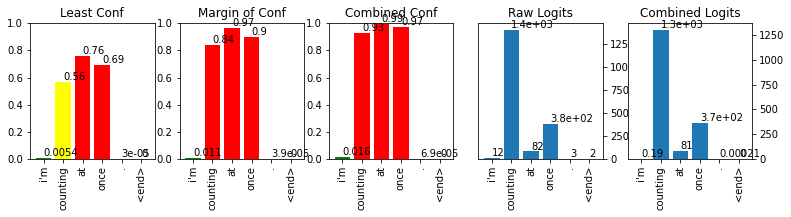



Target:  i was almost naked .
Aggregate Sequence Uncertainty: 0.23765176124870777

Input: <start> הייתי כמעט עירומה . <end>
Predicted translation: i was with mary . <end> 
Runner-up translation: it used used everyone ! . 


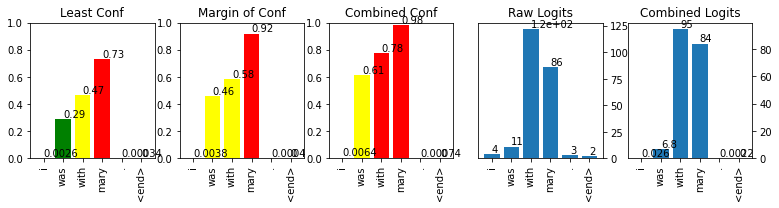



Target:  this should do it .
Aggregate Sequence Uncertainty: 0.1981779709458351

Input: <start> זה אמור להספיק . <end>
Predicted translation: that should do that . <end> 
Runner-up translation: this would make . is . 


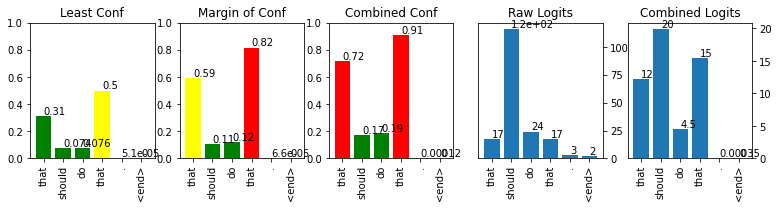



Target:  that's not for you .
Aggregate Sequence Uncertainty: 0.23250465393066405

Input: <start> זה לא עבורך . <end>
Predicted translation: it's not a help . <end> 
Runner-up translation: it won't for wait it . 


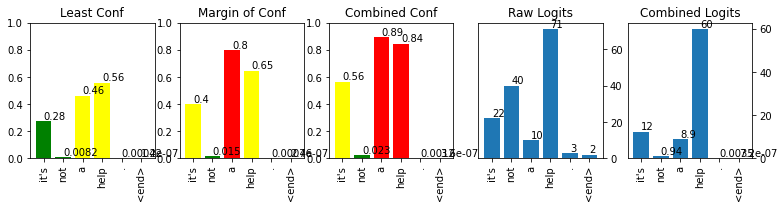



Target:  there is no doubt .
Aggregate Sequence Uncertainty: 0.3291417796164751

Input: <start> אין ספק . <end>
Predicted translation: that does no music . <end> 
Runner-up translation: we're has that way ? . 


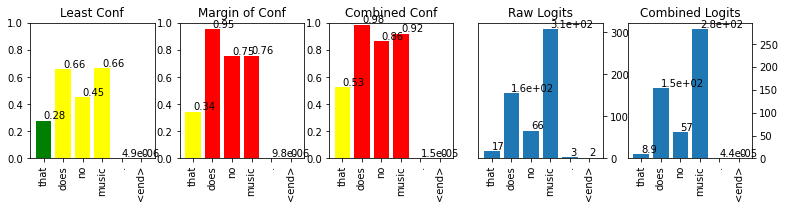



Target:  try to hang on .
Aggregate Sequence Uncertainty: 0.27409259909763933

Input: <start> תנסה לא להרפות . <end>
Predicted translation: try not to hang on . <end> 
Runner-up translation: take to your move . half . 


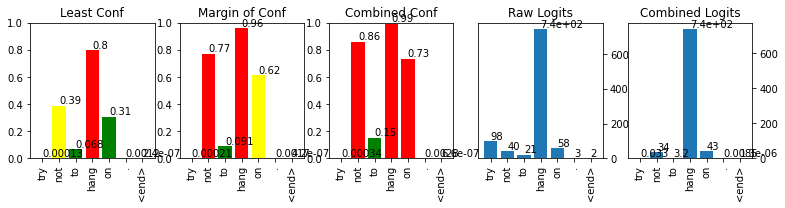



Target:  i was in love once .
Aggregate Sequence Uncertainty: 0.23974372819066048

Input: <start> הייתי פעם מאוהב . <end>
Predicted translation: i was in the man . <end> 
Runner-up translation: i'd could've the love river once . 


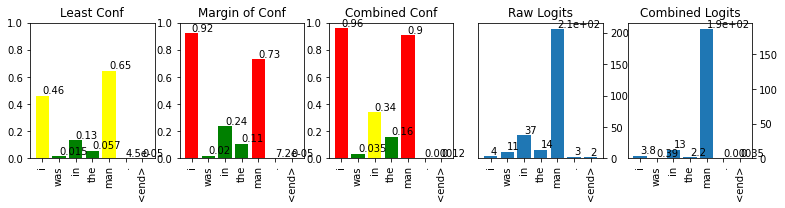



Target:  put on your coat .
Aggregate Sequence Uncertainty: 0.2706423236988485

Input: <start> לבש את מעילך ! <end>
Predicted translation: raise your pockets ! <end> 
Runner-up translation: wear the luck . what's 


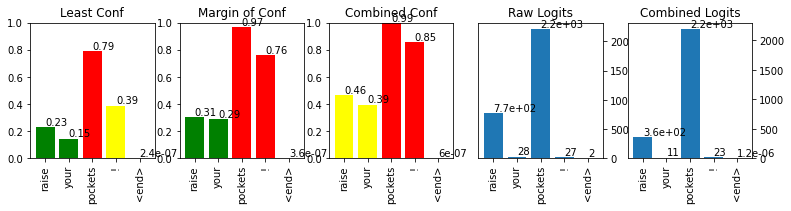



Target:  he's a creationist .
Aggregate Sequence Uncertainty: 0.2931405222043395

Input: <start> הוא מאמין בבריאת העולם . <end>
Predicted translation: he just eat on 1960 . <end> 
Runner-up translation: nobody must kept crazy town ? fuji 


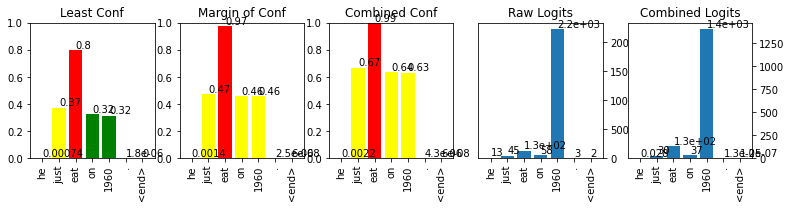



Target:  she waved at him .
Aggregate Sequence Uncertainty: 0.208008124679327

Input: <start> היא נופפה לו . <end>
Predicted translation: she is him . <end> 
Runner-up translation: she's listens kissing off him 


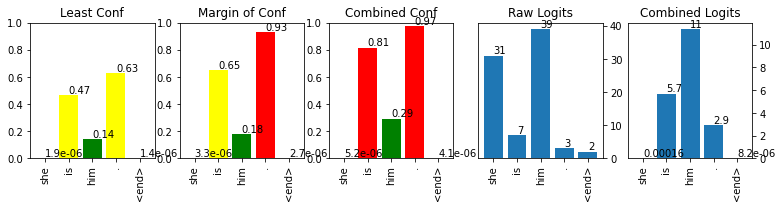



Target:  i'm afraid not .
Aggregate Sequence Uncertainty: 0.33280215319246054

Input: <start> חוששני שלא . <end>
Predicted translation: i'm sorry not . <end> 
Runner-up translation: i homesick . amused . 


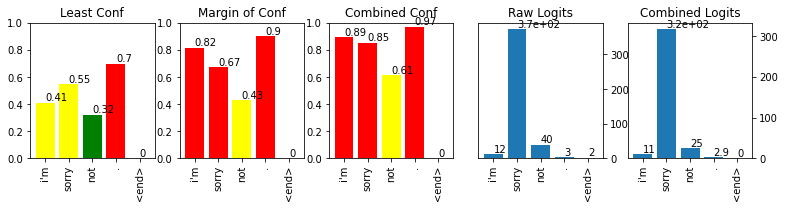



Target:  now listen up .
Aggregate Sequence Uncertainty: 0.29276331611908973

Input: <start> הסכת ושמע . <end>
Predicted translation: we'll wait up . <end> 
Runner-up translation: now be over now . 


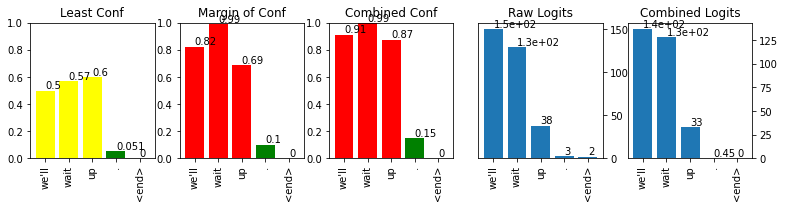



Target:  never tell a lie .
Aggregate Sequence Uncertainty: 0.27144624255597594

Input: <start> אל תשקר אף פעם ! <end>
Predicted translation: never tell me . <end> 
Runner-up translation: don't give up ! ? 


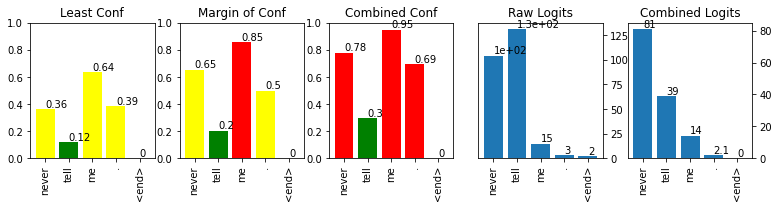



Target:  that's much worse .
Aggregate Sequence Uncertainty: 0.25572614641860125

Input: <start> זה הרבה יותר גרוע . <end>
Predicted translation: it's helping it's bad . <end> 
Runner-up translation: that's much of much ! . 


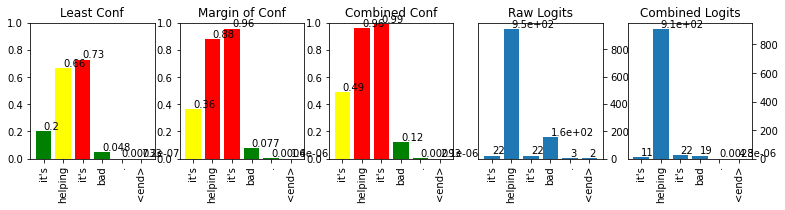



Target:  you're reliable .
Aggregate Sequence Uncertainty: 0.21301244483329357

Input: <start> אפשר לסמוך עליך . <end>
Predicted translation: you're going to win . <end> 
Runner-up translation: you replaceable about go you you 


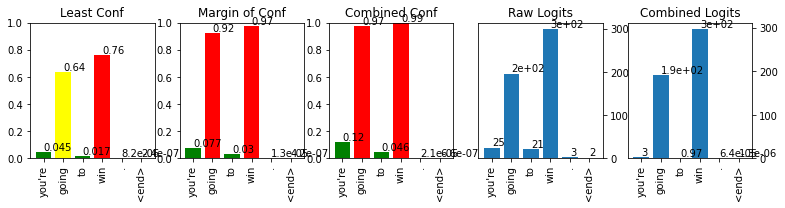



Target:  that's ok with tom .
Aggregate Sequence Uncertainty: 0.21759977638721467

Input: <start> זה בסדר מבחינתו של תום . <end>
Predicted translation: that's ok . <end> 
Runner-up translation: it's all , tom 


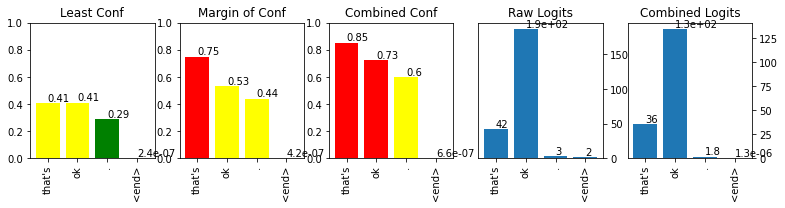



Target:  he seems hungry .
Aggregate Sequence Uncertainty: 0.25968733951449396

Input: <start> נראה שהוא רעב . <end>
Predicted translation: he's looking hungry . <end> 
Runner-up translation: she angry young ! . 


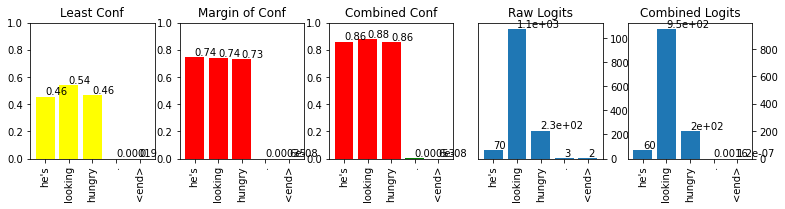



Target:  i can do without it .
Aggregate Sequence Uncertainty: 0.22086826469749213

Input: <start> אני יכול להסתדר בלי זה . <end>
Predicted translation: i can do this along . <end> 
Runner-up translation: can could try it , it it 


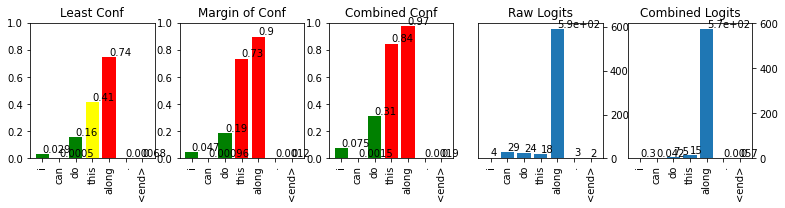



Target:  it'd be illegal .
Aggregate Sequence Uncertainty: 0.2863563006743789

Input: <start> זה יהיה בלתי חוקי . <end>
Predicted translation: it's never illegal . <end> 
Runner-up translation: it'd be use it . 


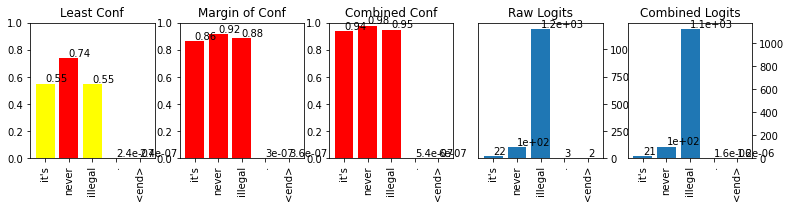



Target:  he must be innocent .
Aggregate Sequence Uncertainty: 0.21022230684757232

Input: <start> הוא חייב להיות זכאי . <end>
Predicted translation: he must be all . <end> 
Runner-up translation: it just succeed clean coming . 


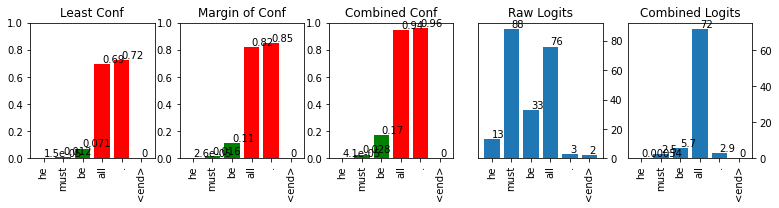



Target:  i can't tell yet .
Aggregate Sequence Uncertainty: 0.22843097895383835

Input: <start> אני עדיין לא יכול לספר . <end>
Predicted translation: i can't still . <end> 
Runner-up translation: i'm still can't , . 


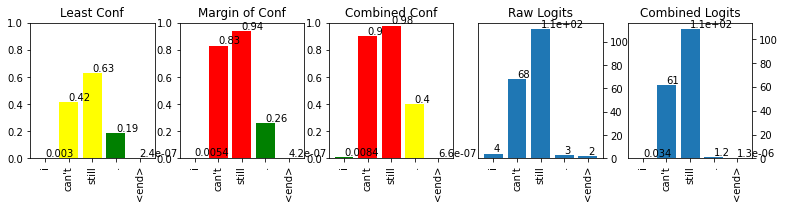



Target:  i'm sure of it .
Aggregate Sequence Uncertainty: 0.211613779515028

Input: <start> אני בטוח בכך <end>
Predicted translation: i'm used to i ? <end> 
Runner-up translation: i certain it you ! ? 


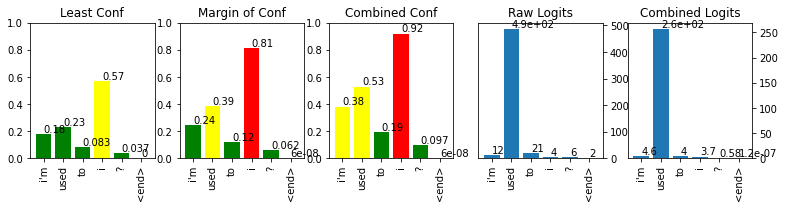



Target:  he loved the change .
Aggregate Sequence Uncertainty: 0.29242137679830194

Input: <start> השינוי נראה לו . <end>
Predicted translation: he went to her . <end> 
Runner-up translation: she hit his him came him 


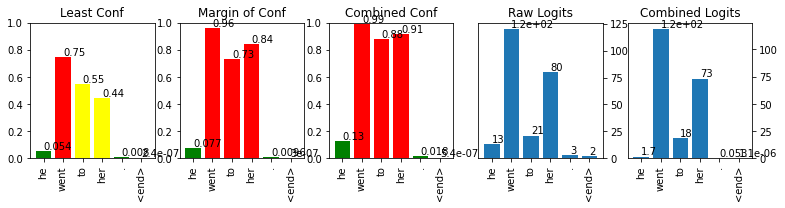



Target:  i was partly right .
Aggregate Sequence Uncertainty: 0.3246976599097252

Input: <start> צדקתי חלקית . <end>
Predicted translation: the be right back . <end> 
Runner-up translation: i pain careful down ? . 


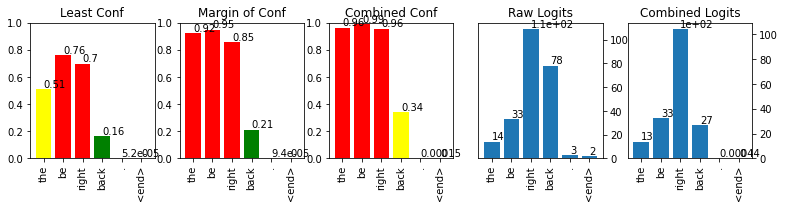



Target:  i eat with my hands .
Aggregate Sequence Uncertainty: 0.22098032627254724

Input: <start> אני אוכל בידיים . <end>
Predicted translation: i eat the backyard . <end> 
Runner-up translation: i'm drive with risks out you 


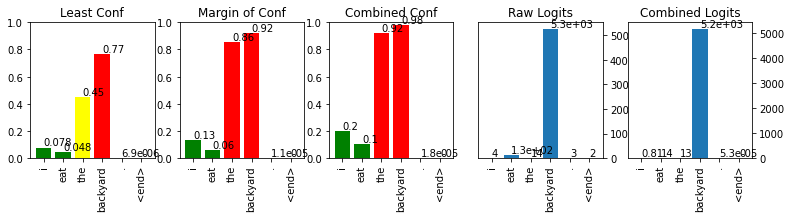



Target:  tom is behind you .
Aggregate Sequence Uncertainty: 0.2225106494501233

Input: <start> תום מאחוריך . <end>
Predicted translation: tom is standing . <end> 
Runner-up translation: tom's will first back . 


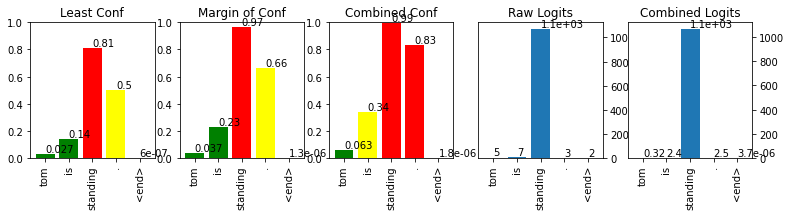



Target:  i lack imagination .
Aggregate Sequence Uncertainty: 0.21810157879081088

Input: <start> אין לי דמיון . <end>
Predicted translation: i have no comment . <end> 
Runner-up translation: i'm don't a doubts ! . 


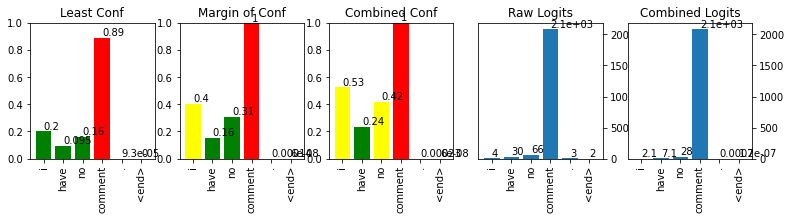



Target:  tom stood quickly .
Aggregate Sequence Uncertainty: 0.2335667610168457

Input: <start> תום נעמד מהר . <end>
Predicted translation: tom stood up . <end> 
Runner-up translation: tom's got quickly quick . 


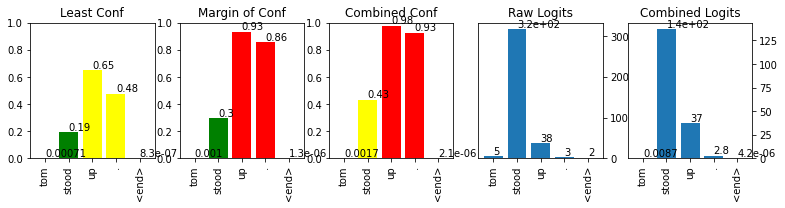



Target:  when shall we eat ?
Aggregate Sequence Uncertainty: 0.20717559866607188

Input: <start> מתי נאכל ? <end>
Predicted translation: when do we eat ? <end> 
Runner-up translation: can shall anybody start asleep ? 


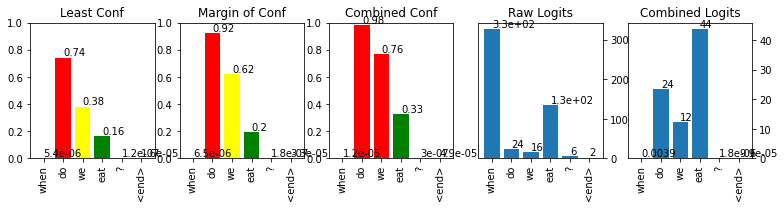



Target:  water the plants .
Aggregate Sequence Uncertainty: 0.20003465227782727

Input: <start> תשקה את הצמחים . <end>
Predicted translation: water the oldest . <end> 
Runner-up translation: shame are dose ! you 


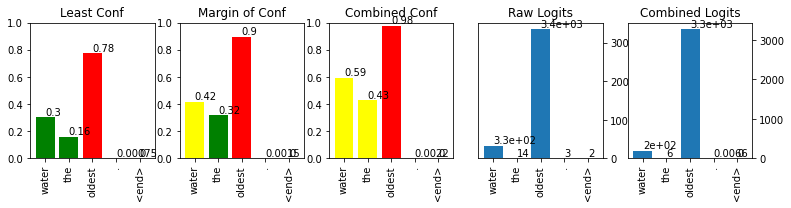



Target:  should i leave ?
Aggregate Sequence Uncertainty: 0.2348547473549843

Input: <start> לעזוב ? <end>
Predicted translation: will leave me ? <end> 
Runner-up translation: should you ? out ? 


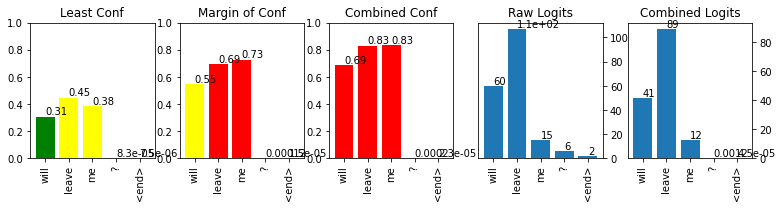



Target:  attack !
Aggregate Sequence Uncertainty: 0.213696838542819

Input: <start> תקוף ! <end>
Predicted translation: get up ! <end> 
Runner-up translation: stand down to you 


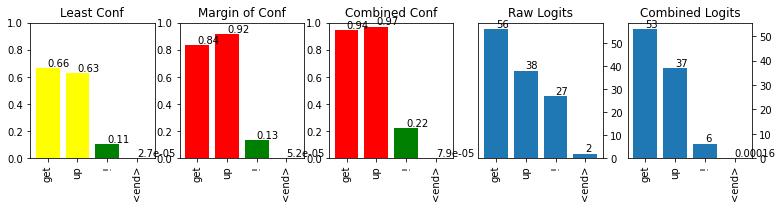

In [92]:
show_mismatches_in_percentile_range_results(90,100,55)

**Low Uncertainty -> High Accuracy (even if mismatched with reference translation)**

Low Percentile score threshold: 7.365942001342773e-05
High Percentile score threshold: 0.006455828547477721


Target:  i helped .
Aggregate Sequence Uncertainty: 0.005908441543579101

Input: <start> עזרתי . <end>
Predicted translation: i helped out . <end> 
Runner-up translation: help forgot . here . 


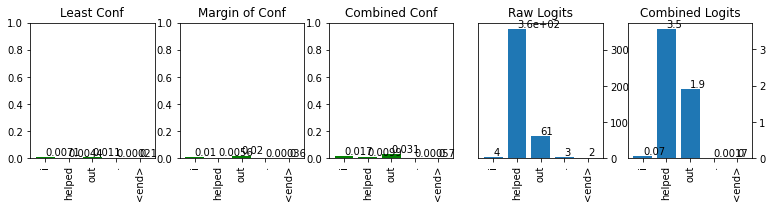



Target:  they're kids .
Aggregate Sequence Uncertainty: 0.005441933870315552

Input: <start> הם ילדים . <end>
Predicted translation: they're children . <end> 
Runner-up translation: they kids are . 


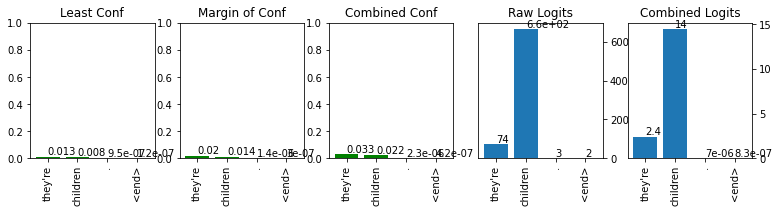



Target:  they hurried off .
Aggregate Sequence Uncertainty: 0.0021899044513702393

Input: <start> הם מיהרו הלאה . <end>
Predicted translation: they hurried on . <end> 
Runner-up translation: they'll window off here . 


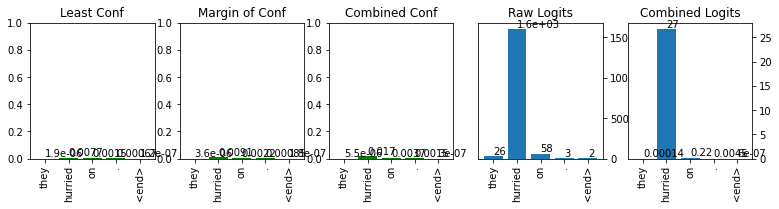



Target:  he closed the door .
Aggregate Sequence Uncertainty: 0.002068054676055908

Input: <start> הוא סגר את הדלת . <end>
Predicted translation: he shut the door . <end> 
Runner-up translation: he's away it room the you 


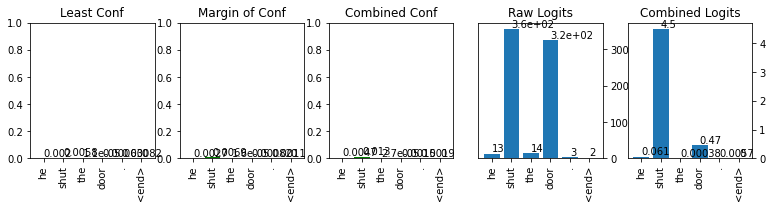



Target:  we were worried .
Aggregate Sequence Uncertainty: 0.004567807912826538

Input: <start> היינו מודאגים . <end>
Predicted translation: we were concerned . <end> 
Runner-up translation: we're talked worried ? . 


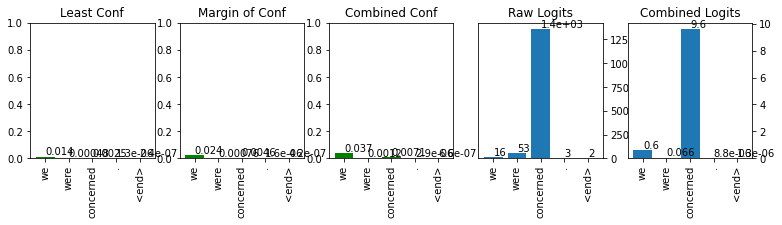



Target:  i trust you .
Aggregate Sequence Uncertainty: 0.001427936553955078

Input: <start> אני סומכת עליך . <end>
Predicted translation: i'm counting on you . <end> 
Runner-up translation: i in in you're in you 


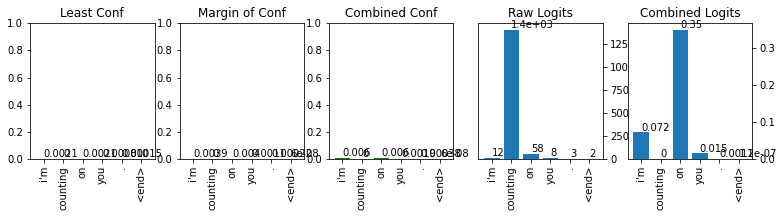



Target:  i don't doubt it .
Aggregate Sequence Uncertainty: 0.006082040071487427

Input: <start> אינני מטילה בכך ספק . <end>
Predicted translation: i don't doubt that . <end> 
Runner-up translation: i'm never buy it ? that 


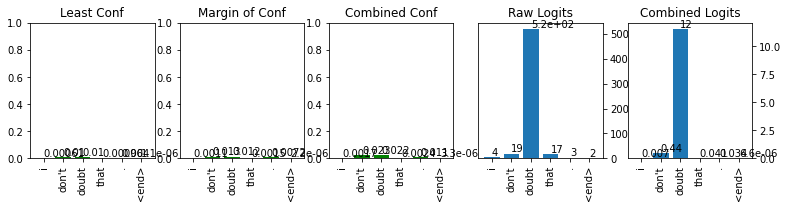



Target:  stop complaining .
Aggregate Sequence Uncertainty: 0.003395378589630127

Input: <start> תפסיקי להתלונן ! <end>
Predicted translation: quit complaining . <end> 
Runner-up translation: stop quick ! ? 


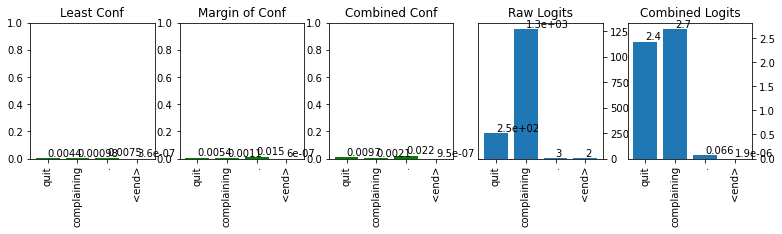



Target:  i'm so sorry .
Aggregate Sequence Uncertainty: 0.0017369568347930908

Input: <start> אני מאד מצטער . <end>
Predicted translation: i'm very sorry . <end> 
Runner-up translation: i so answer ! . 


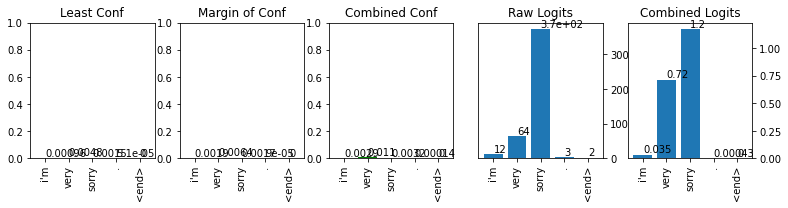



Target:  i'm feeling hungry .
Aggregate Sequence Uncertainty: 0.0011825740337371826

Input: <start> אני חש רעב . <end>
Predicted translation: i feel hungry . <end> 
Runner-up translation: i'm felt shocked ! . 


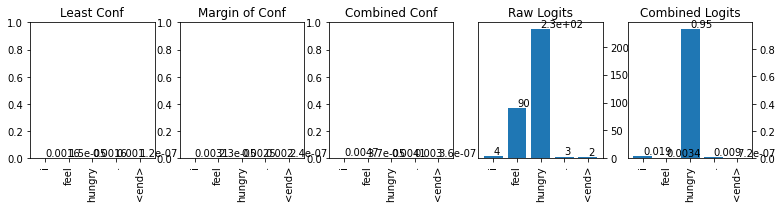



Target:  you're mean .
Aggregate Sequence Uncertainty: 0.005945026874542236

Input: <start> אתם מרושעים . <end>
Predicted translation: you're wicked . <end> 
Runner-up translation: we're mean ? . 


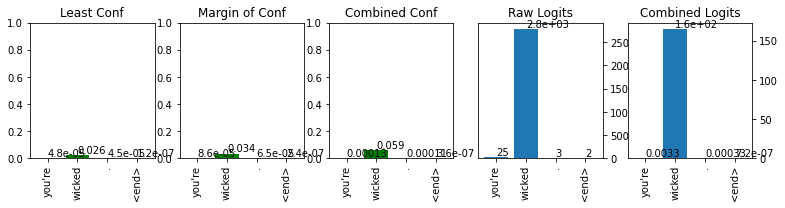



Target:  i can't quit now .
Aggregate Sequence Uncertainty: 0.0033872902393341066

Input: <start> אני לא יכול לעזוב עכשיו . <end>
Predicted translation: i can't leave now . <end> 
Runner-up translation: can't cannot find here ! you 


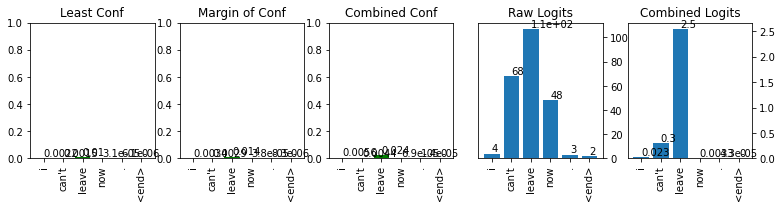



Target:  tom was nosy .
Aggregate Sequence Uncertainty: 0.006347334384918213

Input: <start> תום היה חטטן . <end>
Predicted translation: tom was nosey . <end> 
Runner-up translation: tom's came nosy up . 


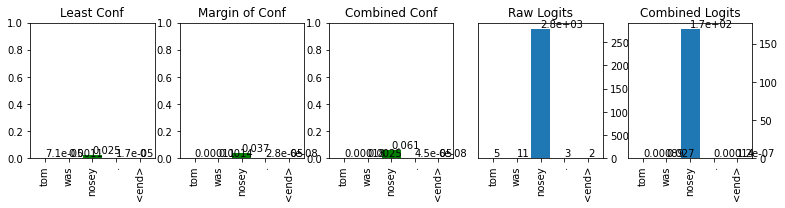



Target:  tom had a pistol .
Aggregate Sequence Uncertainty: 0.005558526515960694

Input: <start> לתום היה אקדח . <end>
Predicted translation: tom had a gun . <end> 
Runner-up translation: i was cover message on . 


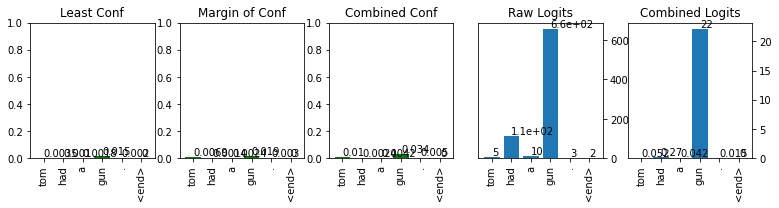



Target:  we trusted you .
Aggregate Sequence Uncertainty: 0.001938384771347046

Input: <start> האמנו לכם . <end>
Predicted translation: we believed you . <end> 
Runner-up translation: they all for ! you 


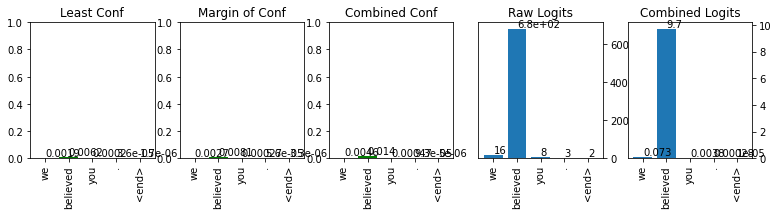

In [91]:
show_mismatches_in_percentile_range_results(0,10,15)

## Conclusion and Thanks!
The above confirms the hypothesis that these scores can be used for modelling not only uncertainty, but acuracy, and drive further analysis and uncertainty sampling iterations. 


**Some next steps:**
  - ignore end of sentence token for aggregate certainty score
  - try Entropy score? - not sure that will tell us more than what we have here but may surprise us
  - try longer sentences
  - try different base in a custom softmax function (per Robert Munro)
  - Reverse source and target (non-English targets)
  - try aggregation by minimum token confidence in sequence
  - use another algorithm (e.g. Transformers)

